In [1]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import *
# 核心模型使用第三方库
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
import lightgbm as lgb
# 交叉验证所使用的第三方库
from sklearn.model_selection import StratifiedKFold, KFold
# 评估指标所使用的的第三方库
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
# 忽略报警所使用的第三方库
import warnings
warnings.filterwarnings('ignore')


d:\anacondahoul\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_row', 1000)

In [9]:
data_1 = pd.read_csv("./dataset/t1.csv", encoding="utf-8")

In [10]:
data_2 = pd.read_csv("./dataset/t2.csv", encoding="utf-8")

In [11]:
data_3 = pd.read_csv("./dataset/t3.csv", encoding="utf-8")

In [14]:
def label_encoder(series):
    ls = list(series.unique())
    length = len(ls)
    cat_dict = dict(zip(ls, range(length)))
    return series.map(cat_dict)

In [915]:
data_1['纹饰_类型']=data_1['纹饰']+'_'+data_1['类型']
data_1['纹饰_颜色']=data_1['纹饰']+'_'+data_1['颜色']
data_1['类型_颜色']=data_1['类型']+'_'+data_1['颜色']

In [916]:
cols = [col for col in data_1.columns if col != '文物编号']
for i in tqdm(cols):
    data_1[i] = label_encoder(data_1[i])

100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1522.83it/s]


In [917]:
data_1 = pd.get_dummies(data_1, columns=['纹饰','表面风化','类型', '颜色','纹饰_类型', '纹饰_颜色', '纹饰_颜色','类型_颜色'])

In [918]:
from mlxtend.frequent_patterns import apriori

apriori(data_1, min_support=0.2, use_colnames=True).sort_values(by='support', ascending=False)

,support,itemsets
5,0.689655,(类型_1)
3,0.586207,(表面风化_1)
0,0.517241,(纹饰_0)
20,0.482759,"(类型_1, 表面风化_1)"
34,0.413793,"(类型_1, 纹饰_0, 纹饰_类型_4)"
2,0.413793,(表面风化_0)
15,0.413793,"(纹饰_0, 纹饰_类型_4)"
14,0.413793,"(类型_1, 纹饰_0)"
28,0.413793,"(类型_1, 纹饰_类型_4)"
9,0.413793,(纹饰_类型_4)


In [919]:
cols = [col for col in data_1.columns if col not in ['文物编号', '表面风化']]

In [12]:
data_1 = pd.read_csv("./dataset/t1.csv", encoding="utf-8")

In [15]:
data_1['纹饰_类型']=data_1['纹饰']+'_'+data_1['类型']
data_1['纹饰_颜色']=data_1['纹饰']+'_'+data_1['颜色']
data_1['类型_颜色']=data_1['类型']+'_'+data_1['颜色']
cols = [col for col in data_1.columns if col != '文物编号']
for i in tqdm(cols):
    data_1[i] = label_encoder(data_1[i])

100%|██████████| 7/7 [00:00<00:00, 605.28it/s]


In [16]:
x_train = data_1[cols]
y_train = data_1['表面风化']

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
model1 = SelectKBest(chi2, k=6)#选择k个最佳特征
model1.fit_transform(x_train, y_train)

array([[ 0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1],
       [ 1,  0,  0,  2,  2,  0],
       [ 1,  0,  0,  2,  2,  0],
       [ 1,  0,  0,  2,  2,  0],
       [ 1,  0,  0,  2,  2,  0],
       [ 2,  0,  1,  3,  3,  0],
       [ 0,  1,  1,  4,  4,  2],
       [ 2,  0,  1,  3,  3,  0],
       [ 2,  0,  1,  3,  3,  0],
       [ 0,  1,  1,  4,  5,  1],
       [ 2,  0,  1,  3,  3,  0],
       [ 0,  0,  0,  0,  5,  3],
       [ 0,  0,  0,  0,  6,  4],
       [ 0,  0,  0,  0,  5,  3],
       [ 0,  0,  0,  0,  5,  3],
       [ 0,  0,  0,  0,  5,  3],
       [ 1,  0,  0,  2,  7,  5],
       [ 1,  1,  1,  1,  8,  6],
       [ 1,  1,  0,  1,  1,  1],
       [ 1,  0,  0,  2,  2,  0],
       [ 2,  0,  1,  3,  3,  0],
       [ 1,  1,  1,  1,  2,  7],
       [ 0,  1,  0,  4,  4,  2],
       [ 0,  1,  1,  4,  5,  1],
       [ 0,  1,  1,  4,  4,  2],
       [ 2,  0,  1,  3,  3,  0],
       [ 1,  1,  1,  1,  1,  1],
       [ 1,  1,  1,  1,  1,  1],
       [ 1,  1,  0,  1,  7,  8],
       [ 0

In [ ]:
model1.scores_

In [59]:
model1.pvalues_

array([0.28522744, 0.14394285, 0.9123796 , 0.01906271, 0.87037096,
       0.61935384])

In [33]:
import matplotlib.pyplot as plt  
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [100]:
cols

['纹饰', '类型', '颜色', '纹饰_类型', '纹饰_颜色', '类型_颜色']

In [24]:
col = '纹饰_颜色_类型'
plt.figure(figsize=(20, 10))
sns.countplot(x=col,hue ='表面风化' ,data=data_1)

ValueError: Could not interpret input '纹饰_颜色_类型'

<Figure size 1440x720 with 0 Axes>

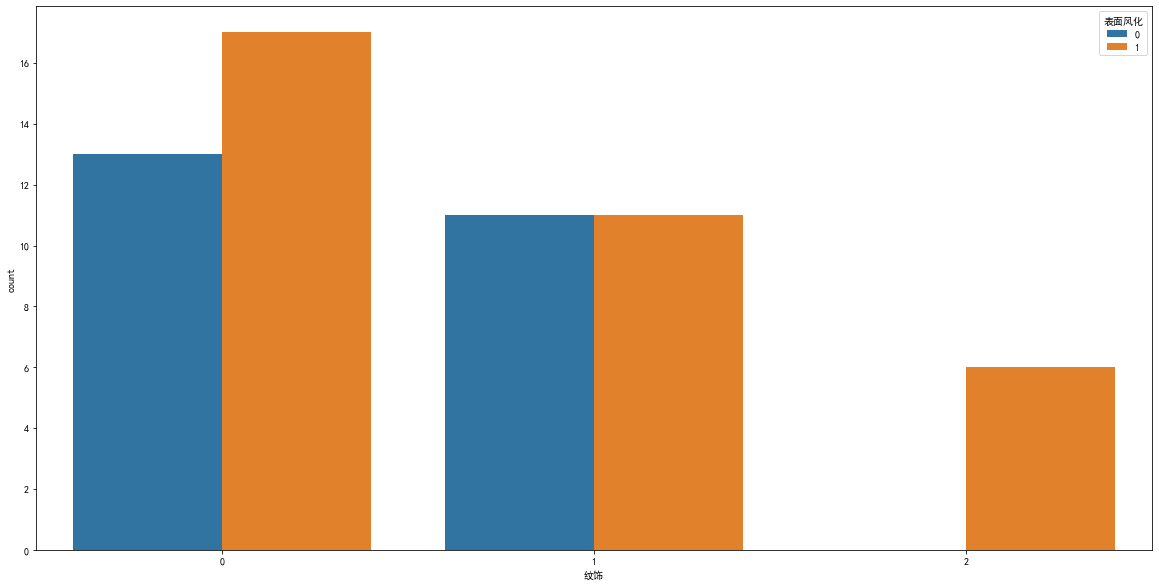

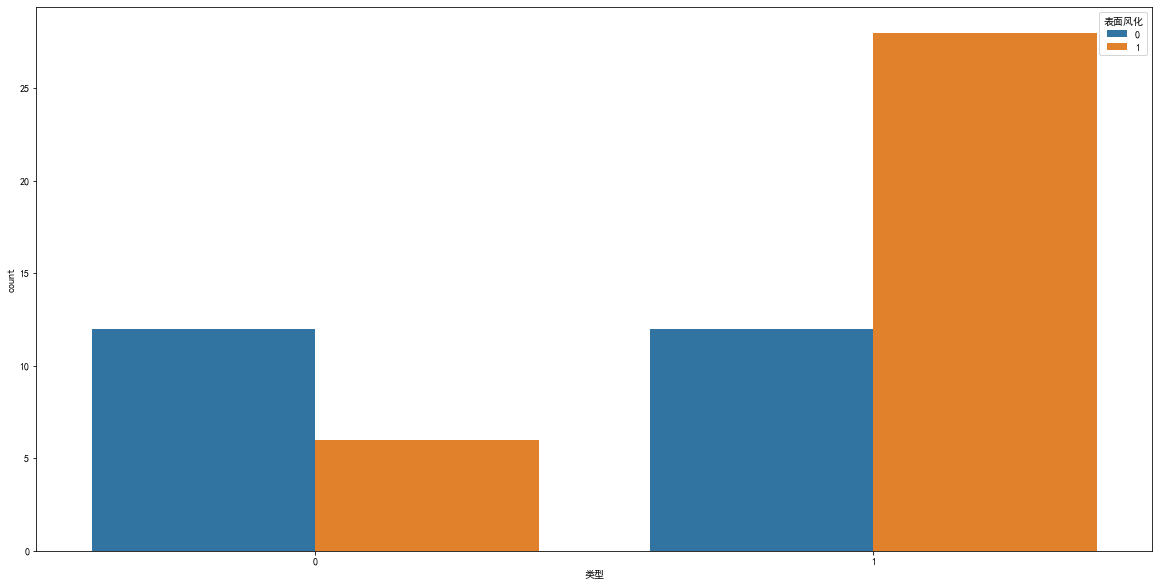

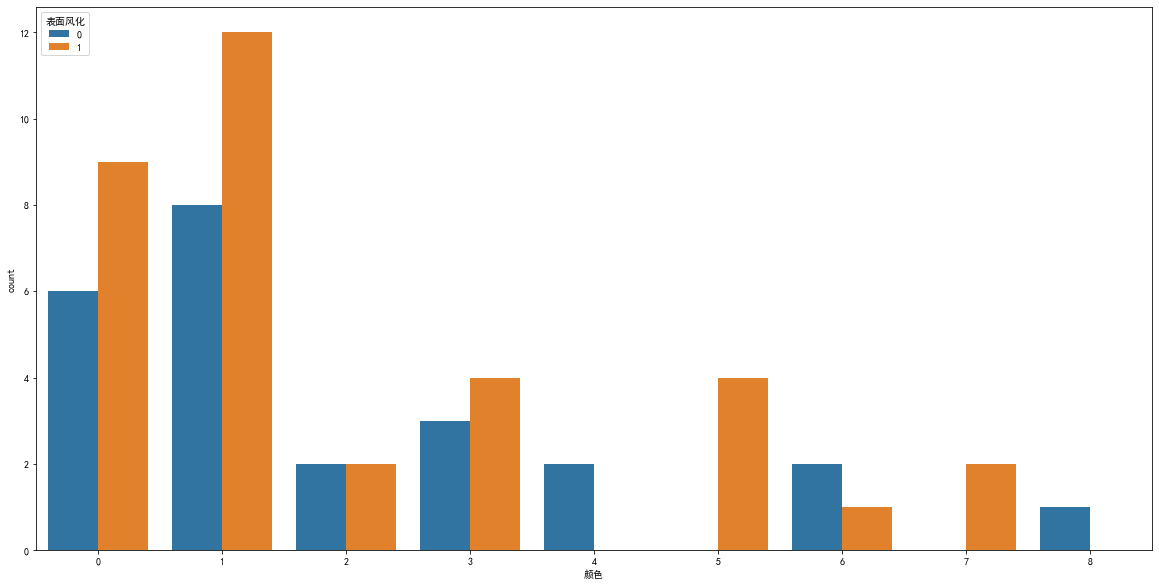

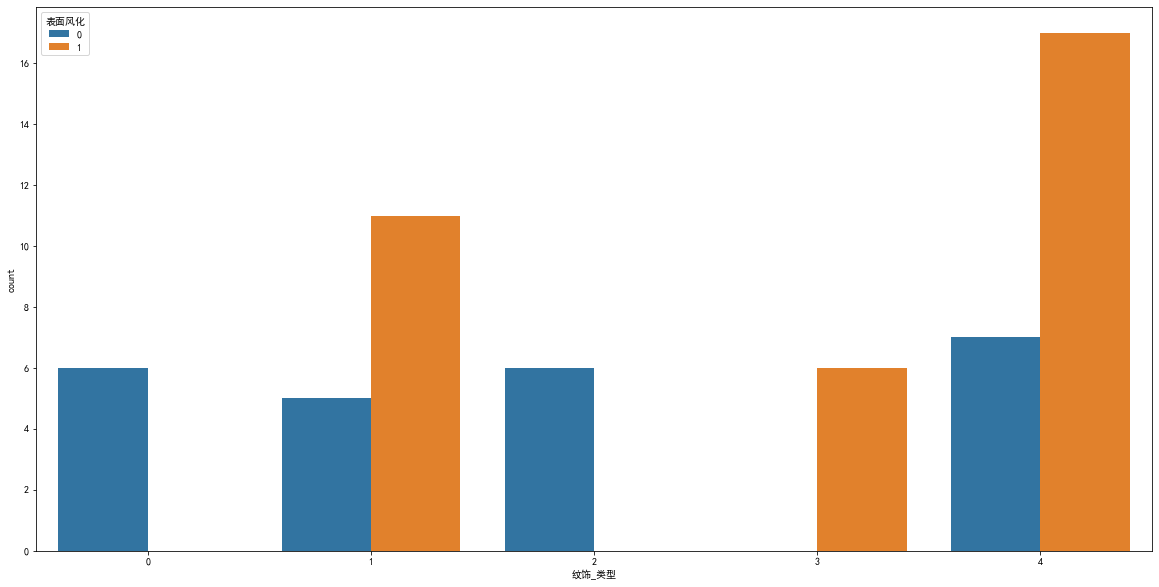

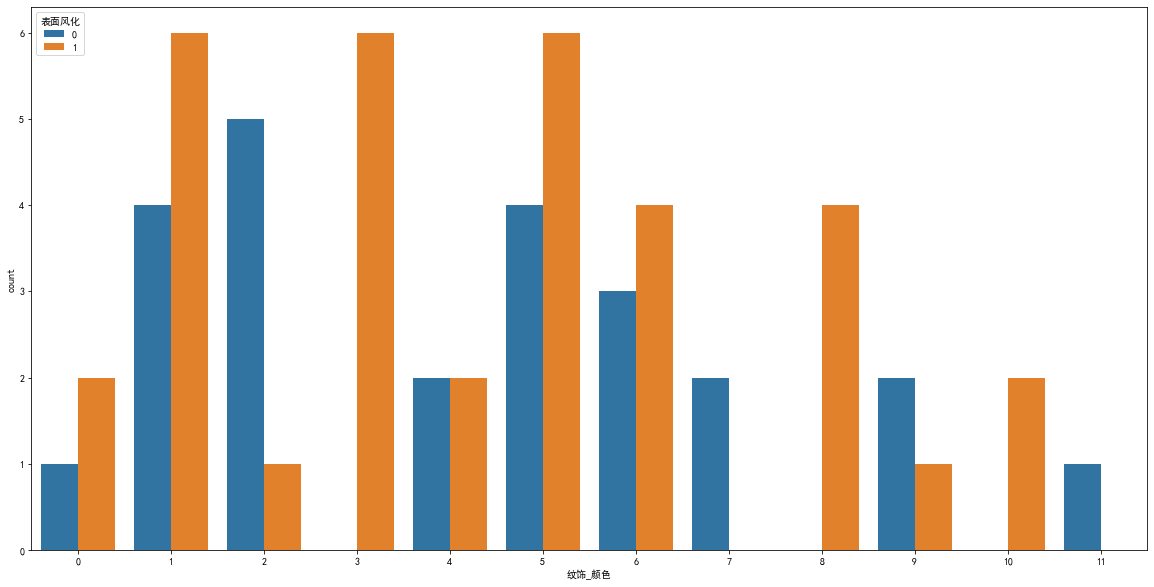

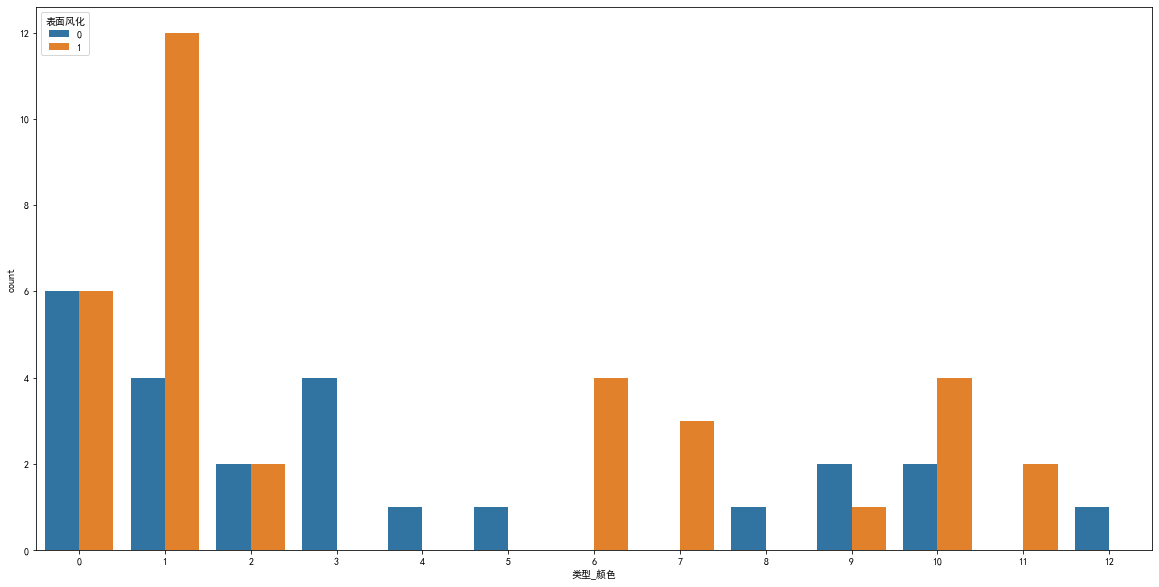

In [99]:
for col in cols:
    plt.figure(figsize=(20, 10))
    sns.countplot(x=col,hue ='表面风化' ,data=data_1)
    plt.savefig("./附件/{}_风化_count.png".format(col))

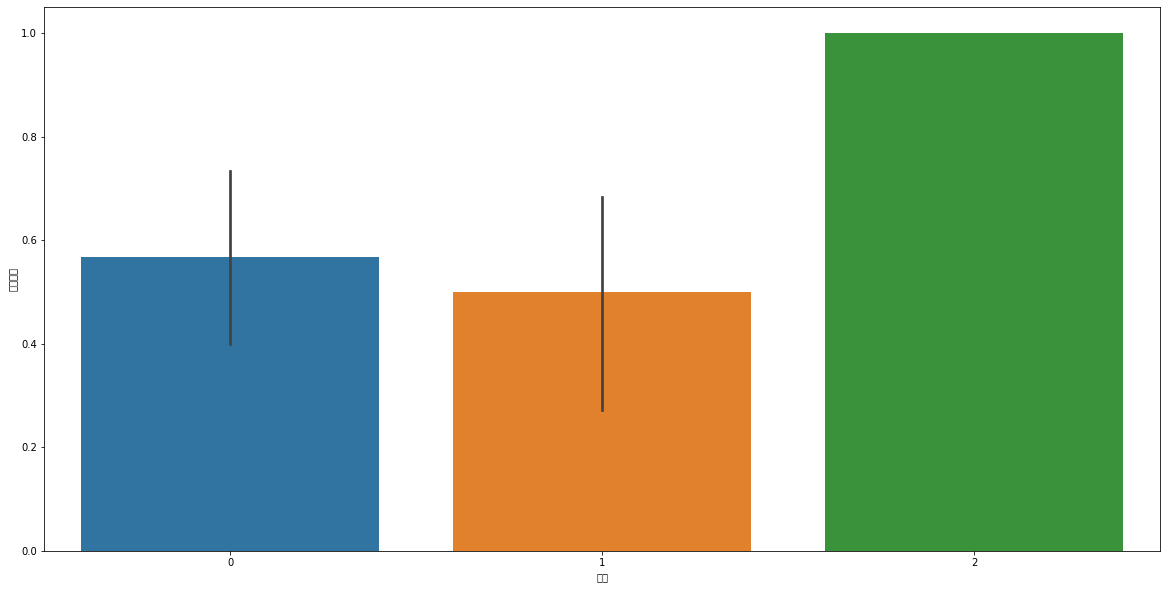

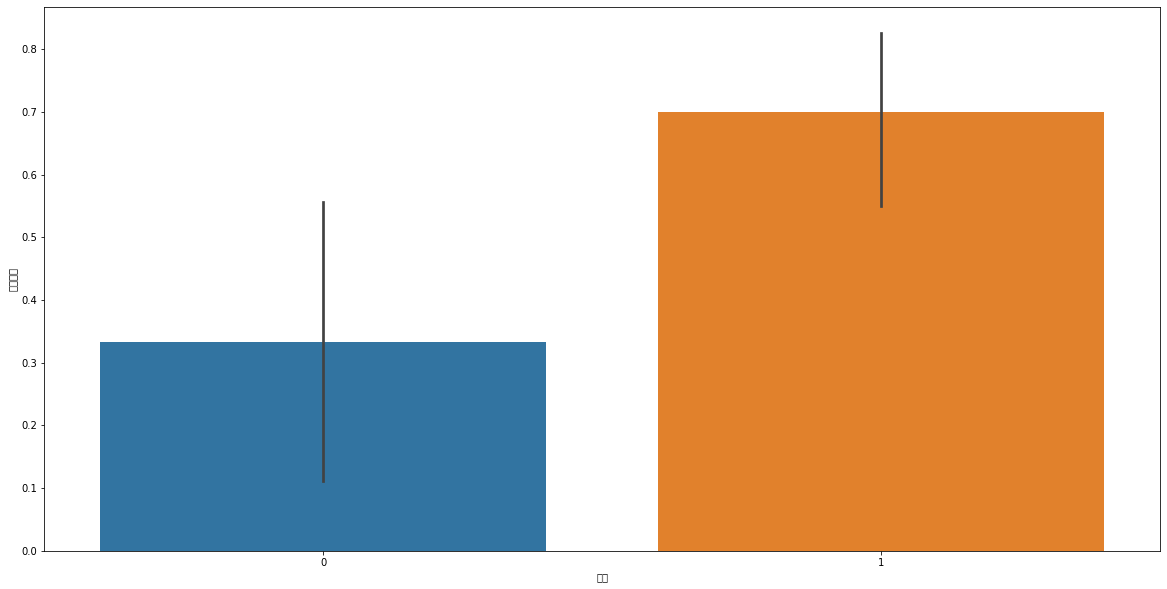

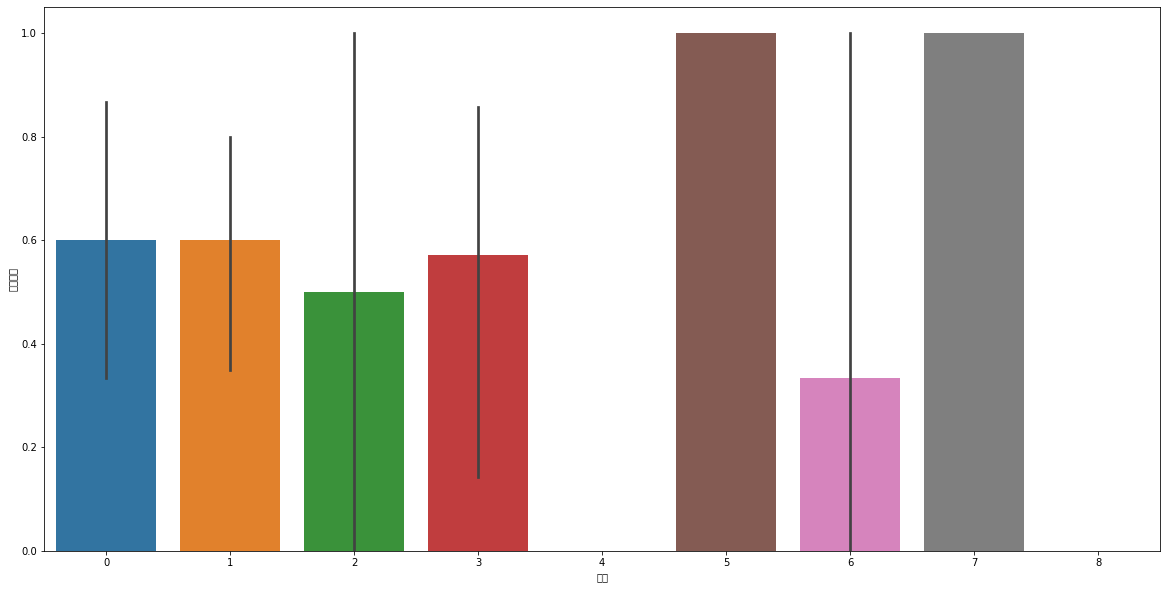

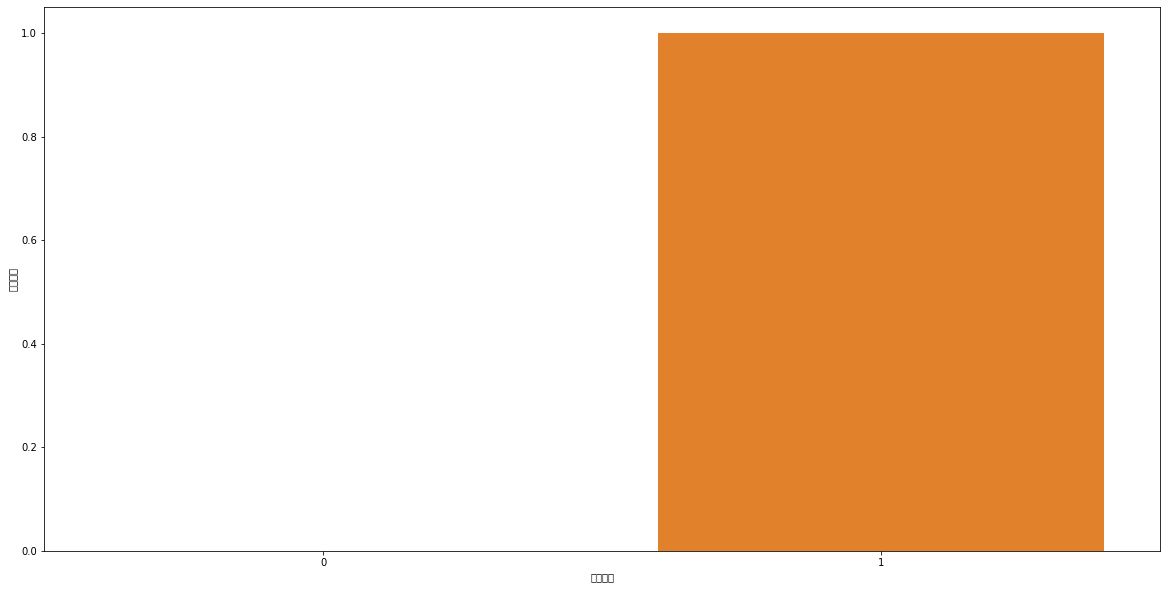

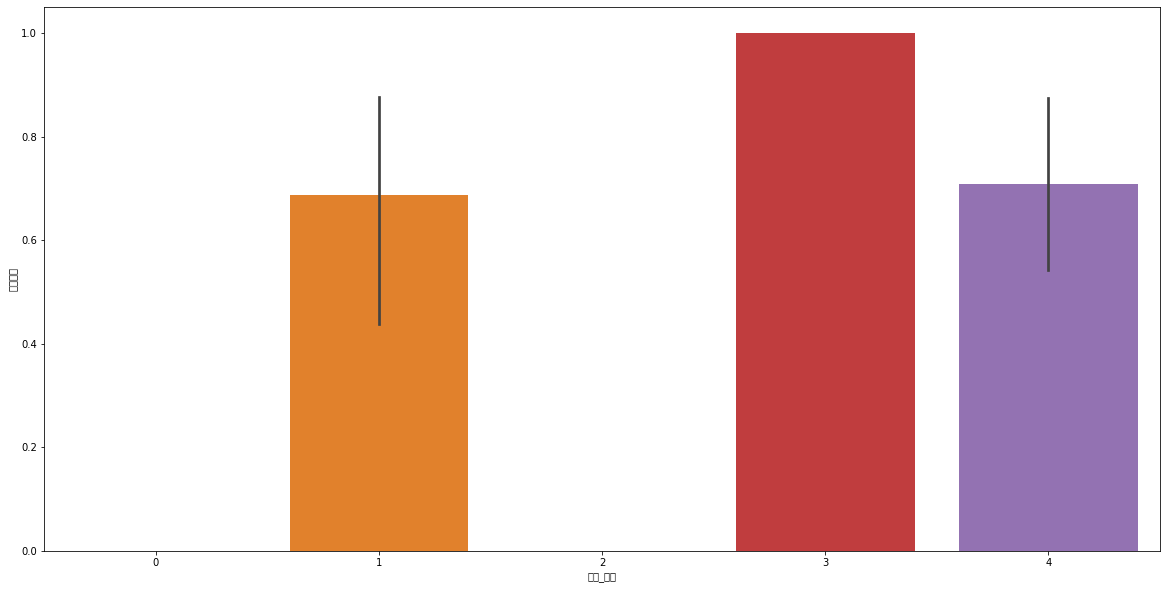

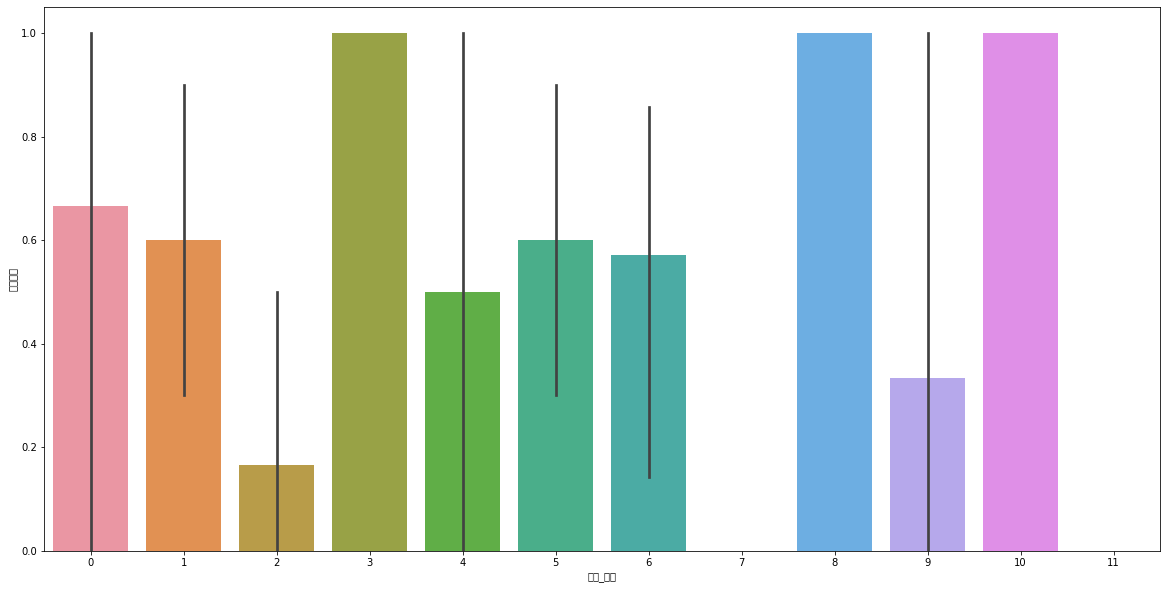

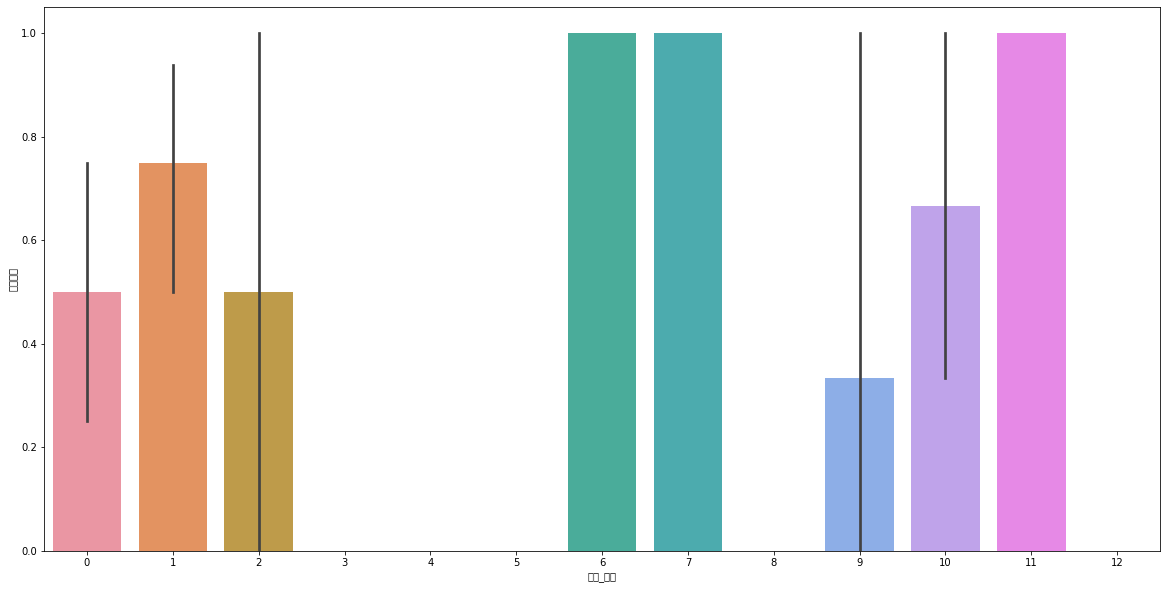

In [25]:
for col in cols:
    plt.figure(figsize=(20, 10))
    sns.barplot(x = data_1[col], y = data_1['表面风化'] )

In [26]:
data_2['文物采样点'] = data_2['文物采样点'].astype(str)

In [27]:
def get_dig(str):
    return str[:2]

In [28]:
#data_2【17】【19】
data_2['文物编号'] = data_2['文物采样点'].apply(get_dig)

In [29]:
data_2['文物编号'] = data_2['文物编号'].astype(int)

In [30]:
data_2 = pd.merge(data_2,data_1[['文物编号', '表面风化', '类型']], how='left', on='文物编号')

In [31]:
data_2 = data_2.fillna(0)
data_2.drop(labels=[17, 19], axis=0, inplace = True)#删除17， 19

In [32]:
data_2 = data_2.reset_index()

In [33]:
del data_2['index']

In [34]:
for row in data_2.index:
    if '未风化点' in data_2.loc[row,'文物采样点']:
        data_2.loc[row,'表面风化']=0
    elif '严重风化点' in data_2.loc[row,'文物采样点']:
        data_2.loc[row,'表面风化']=1

In [35]:
data_2_type0 = data_2[data_2['类型']==0]
data_2_type1 = data_2[data_2['类型']==1]

In [36]:
chem_cols = [col for col in data_2.columns if col not in ['文物采样点', '文物编号', '表面风化', '类型']]

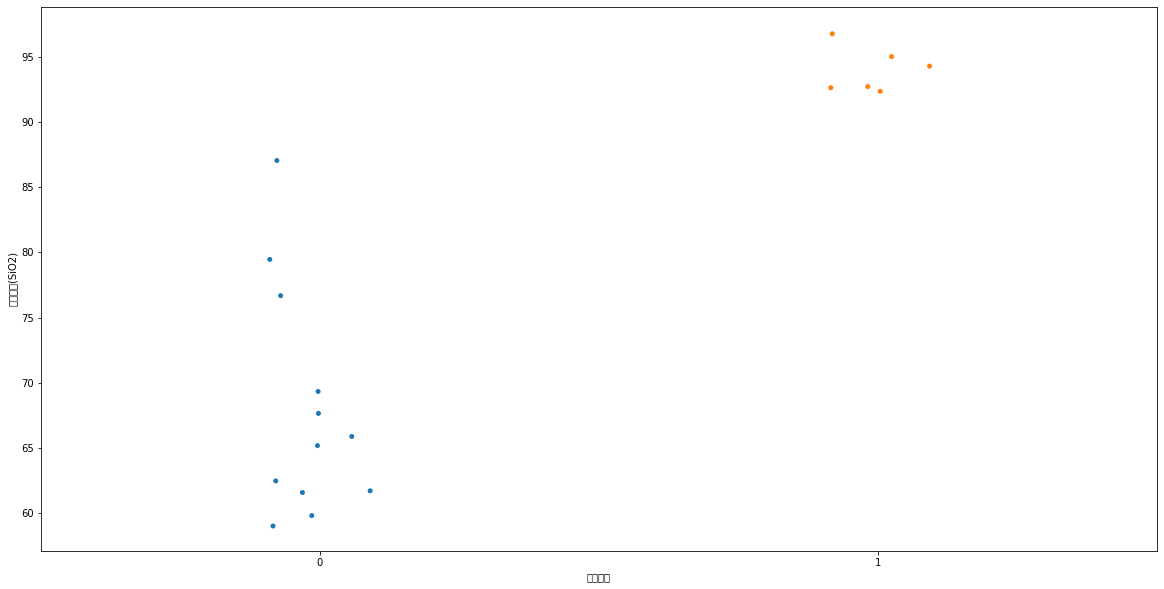

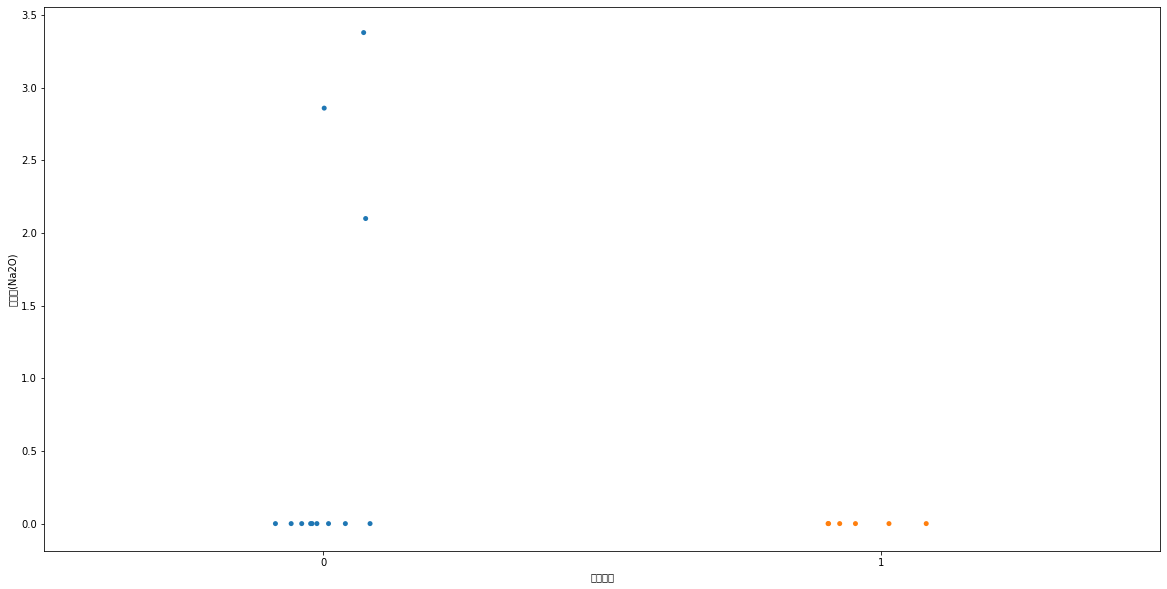

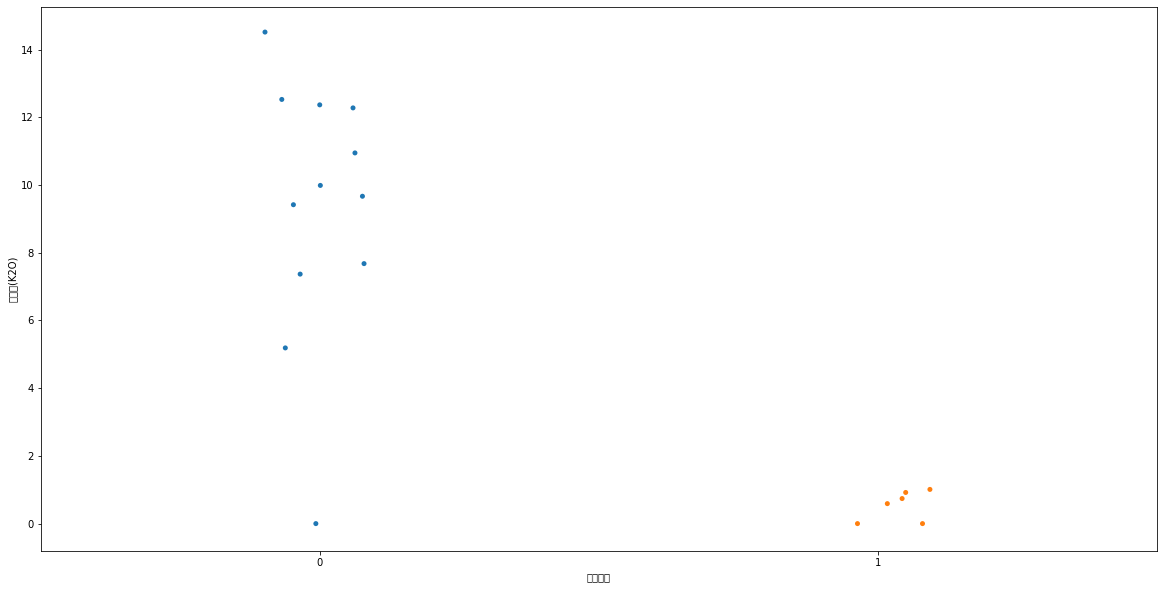

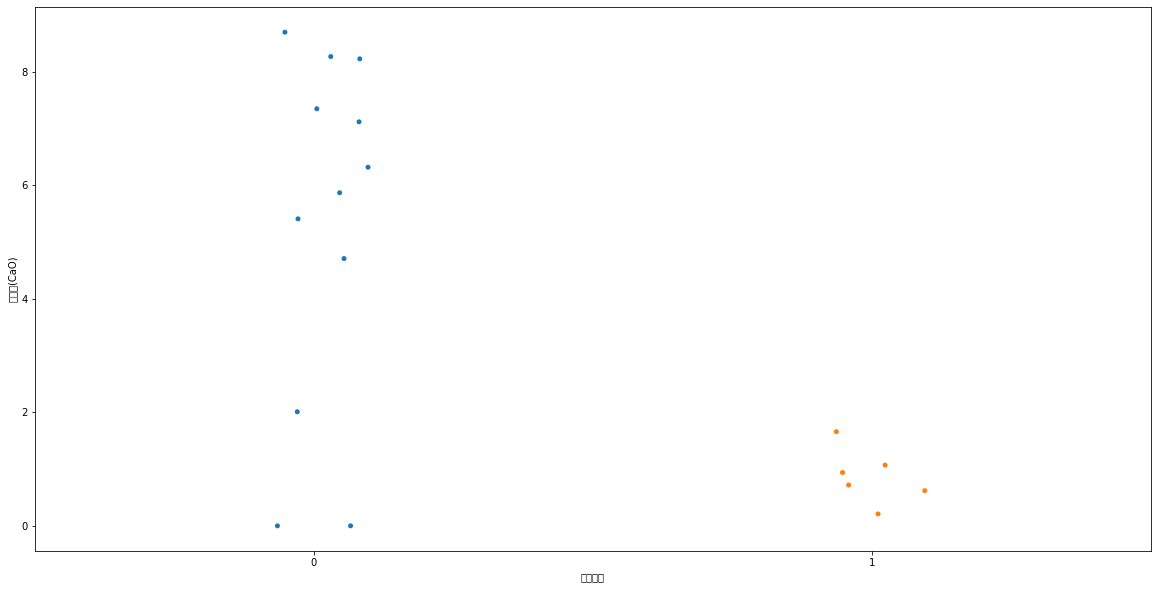

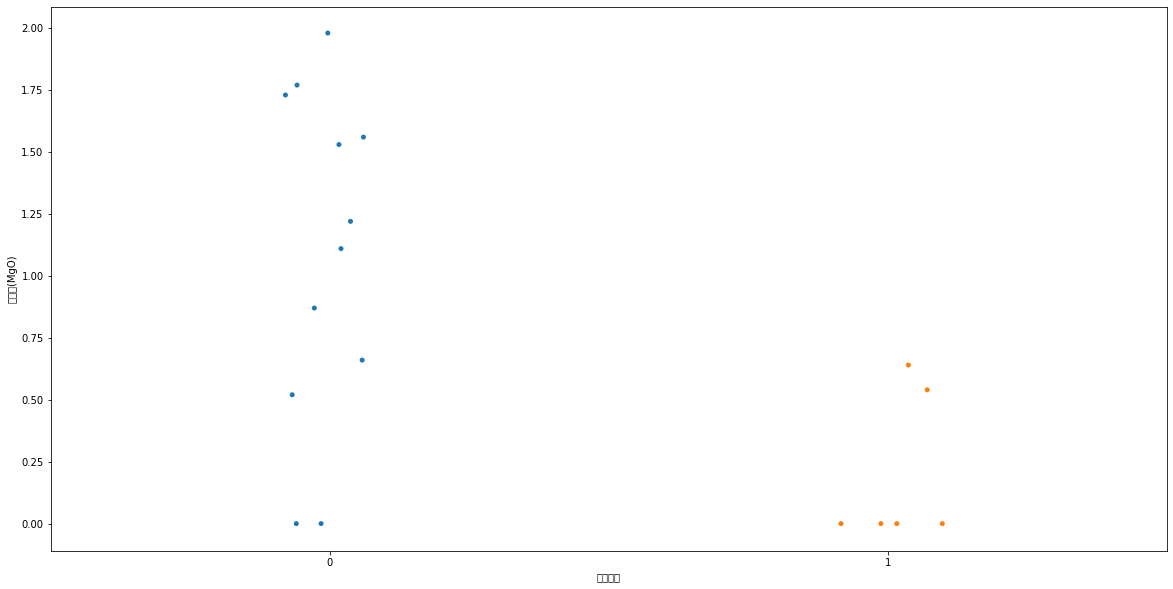

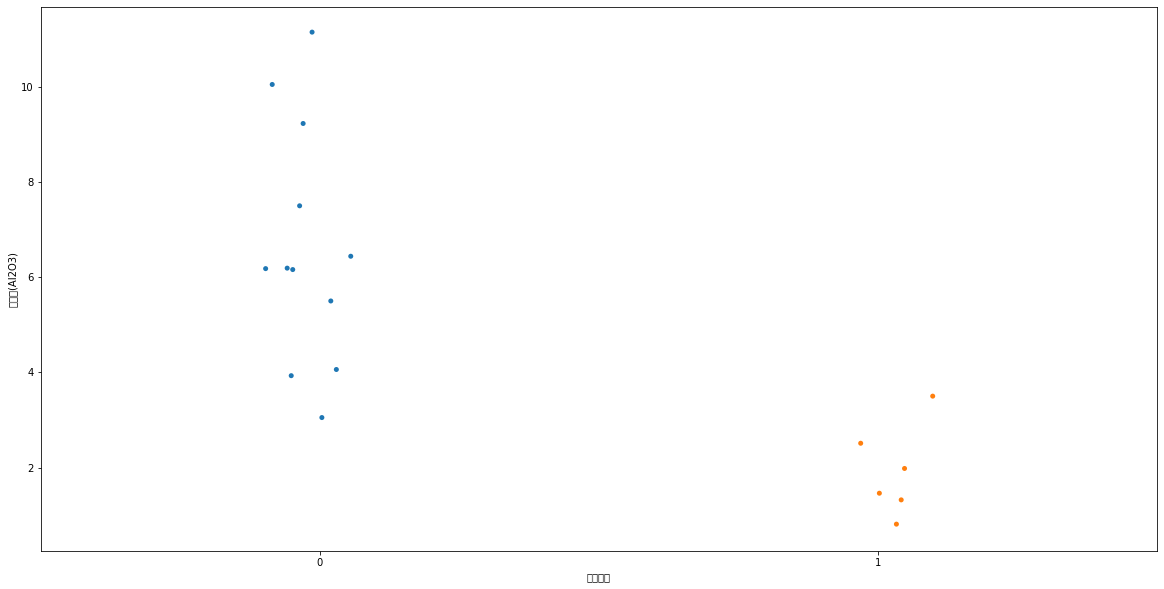

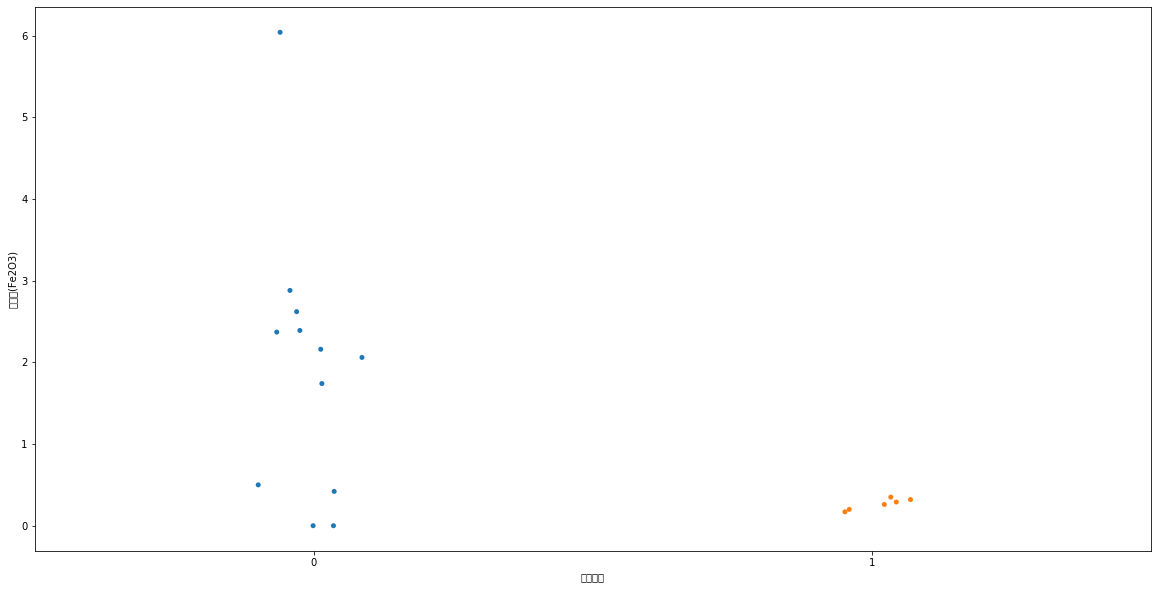

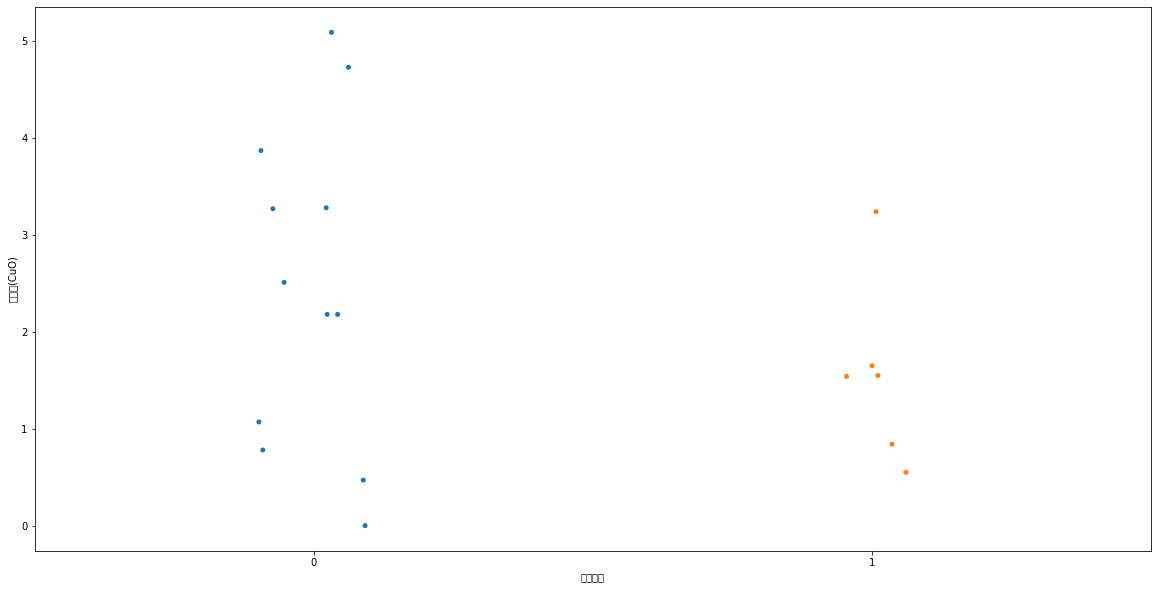

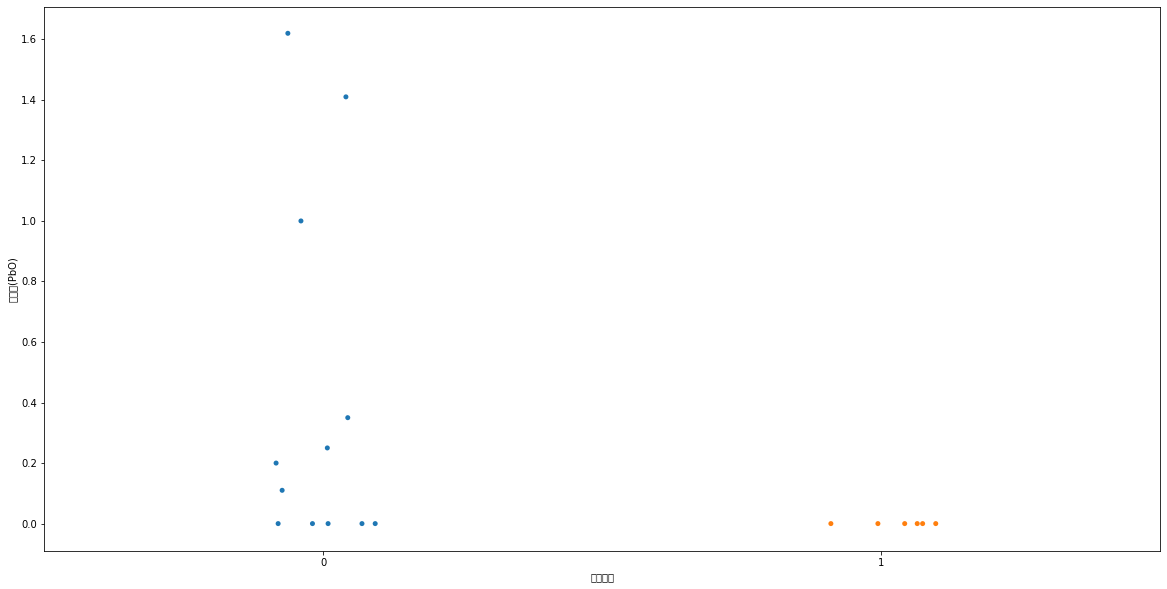

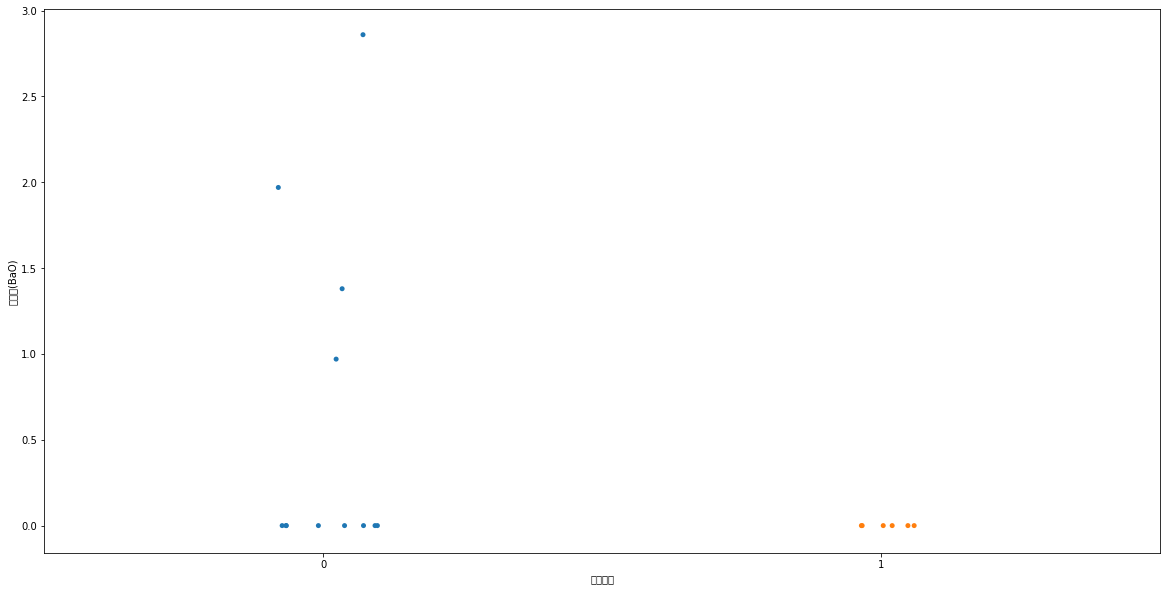

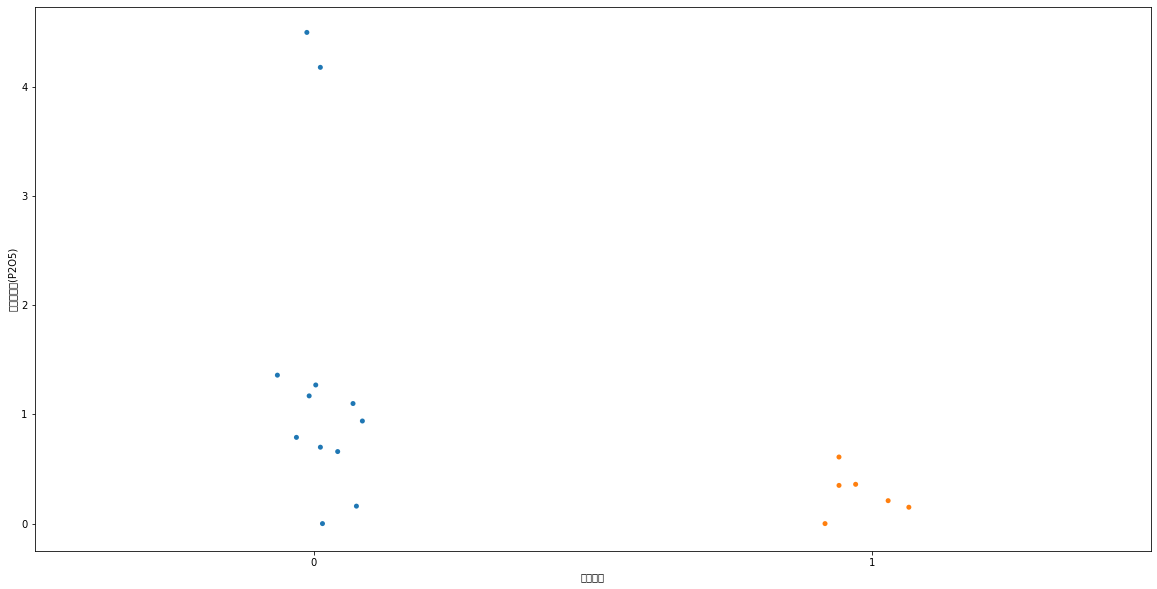

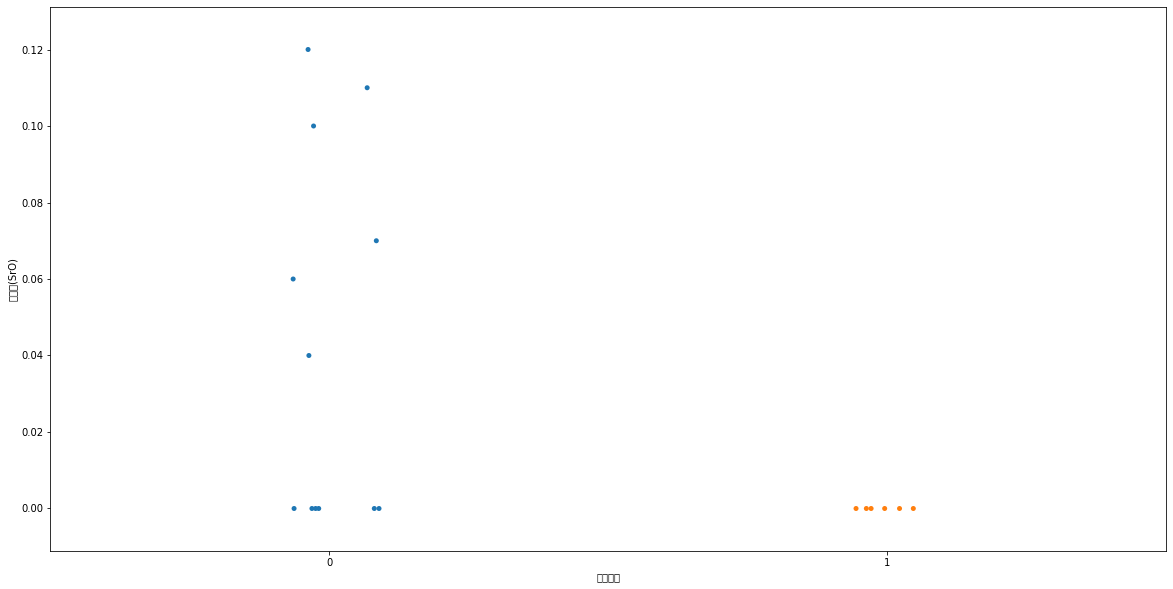

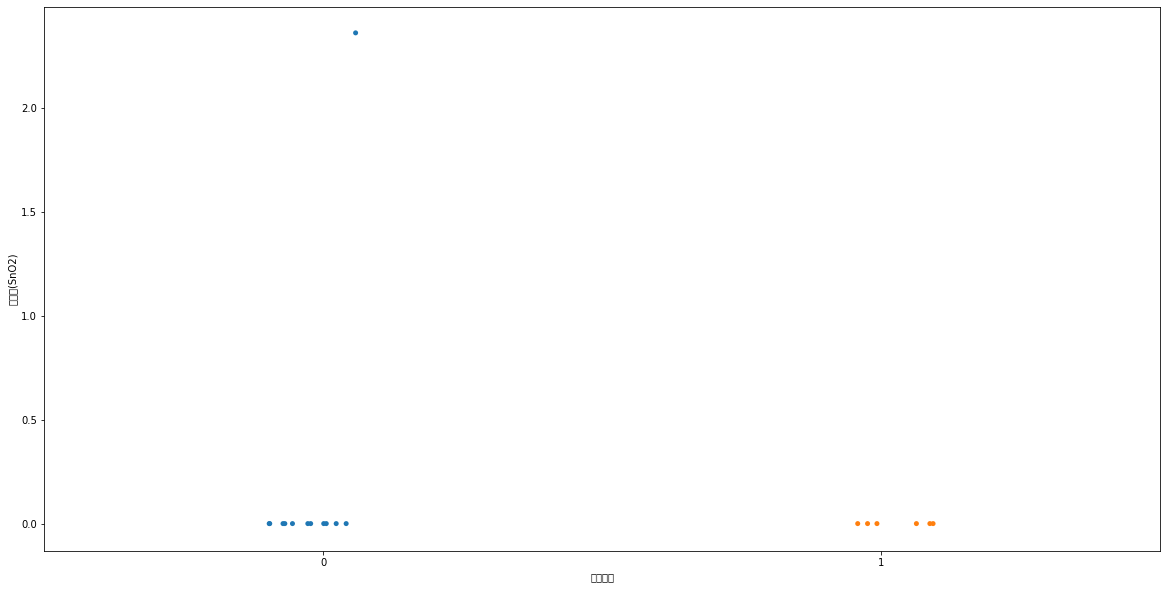

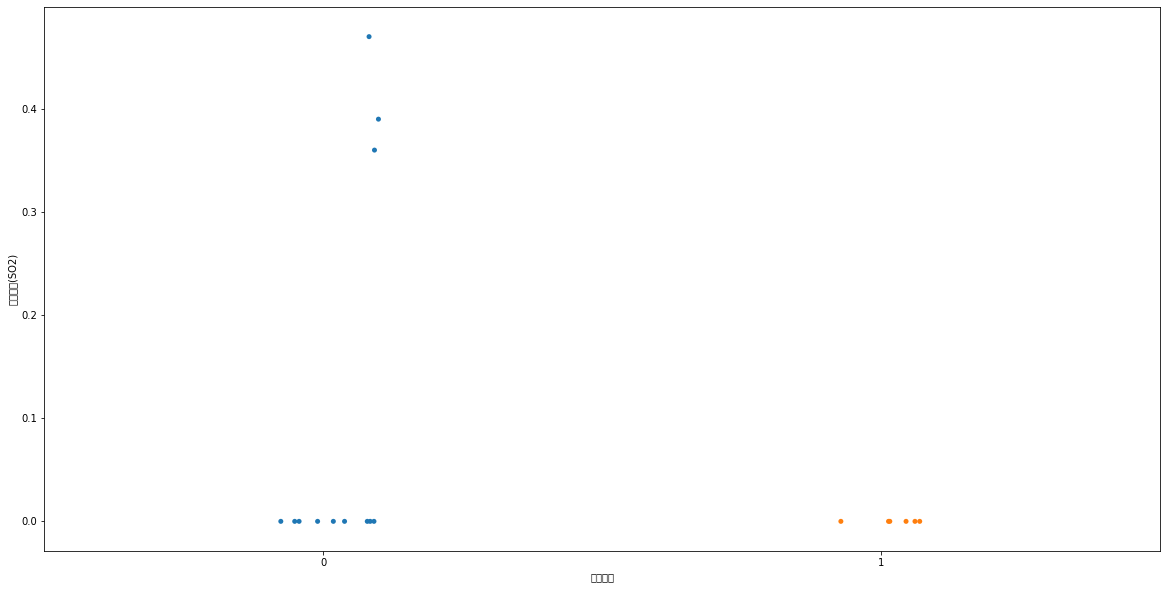

In [38]:
for col in chem_cols:
    plt.figure(figsize=(20, 10))
    sns.stripplot(x= '表面风化',y = col, data=data_2_type0)

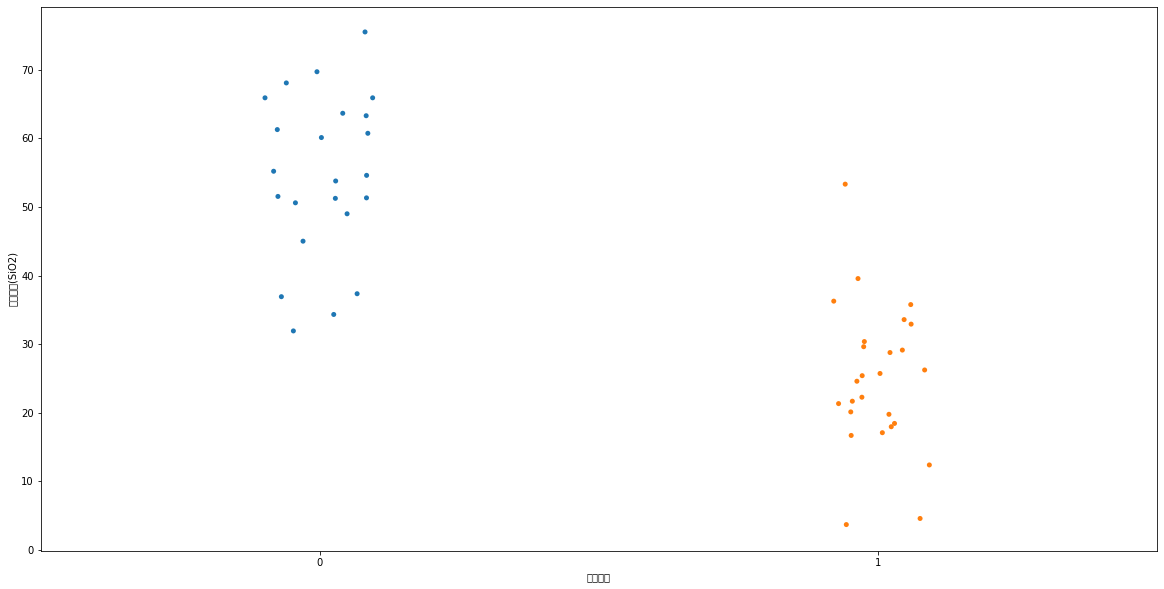

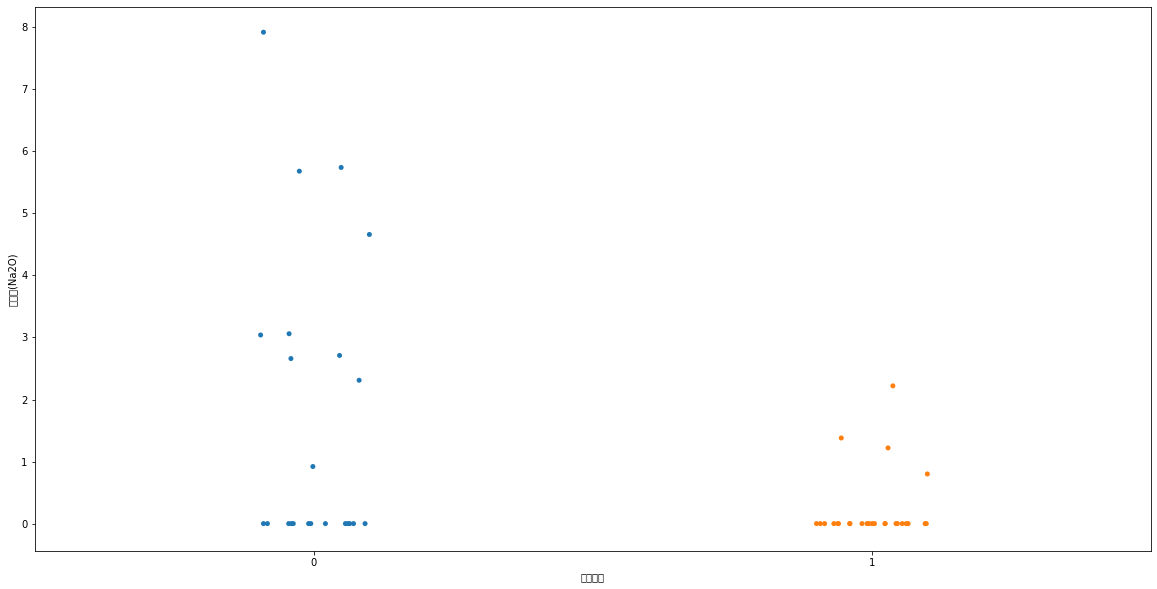

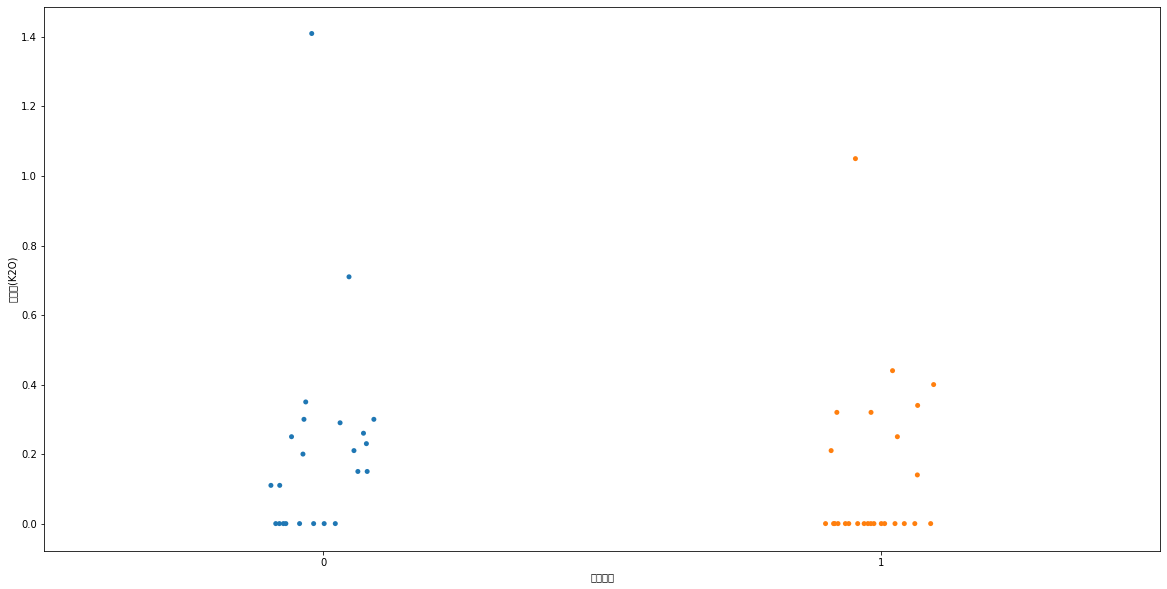

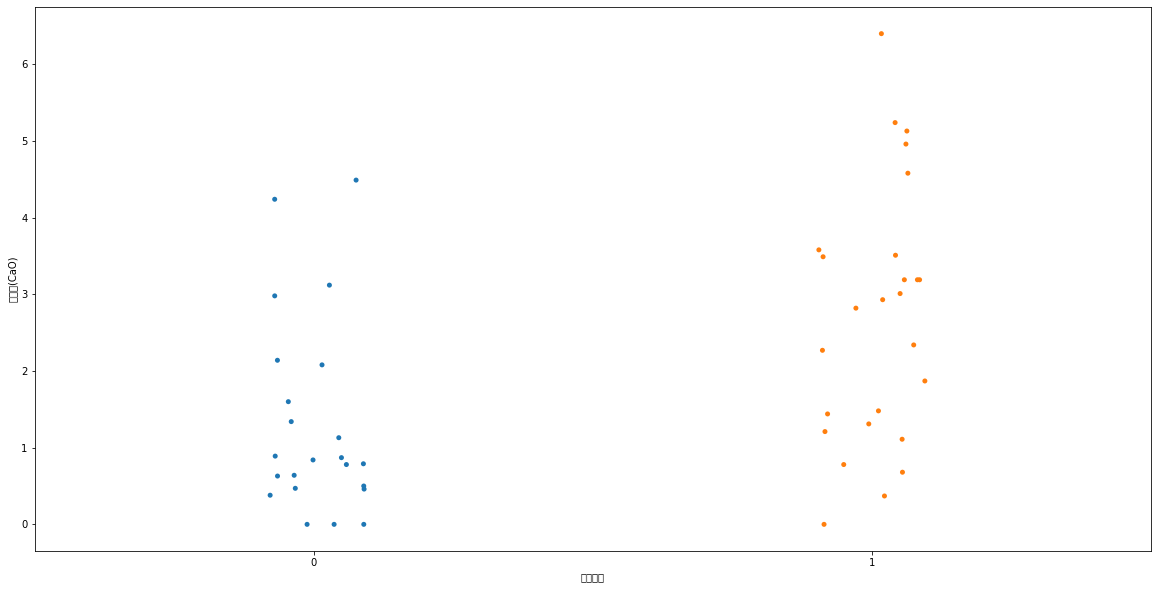

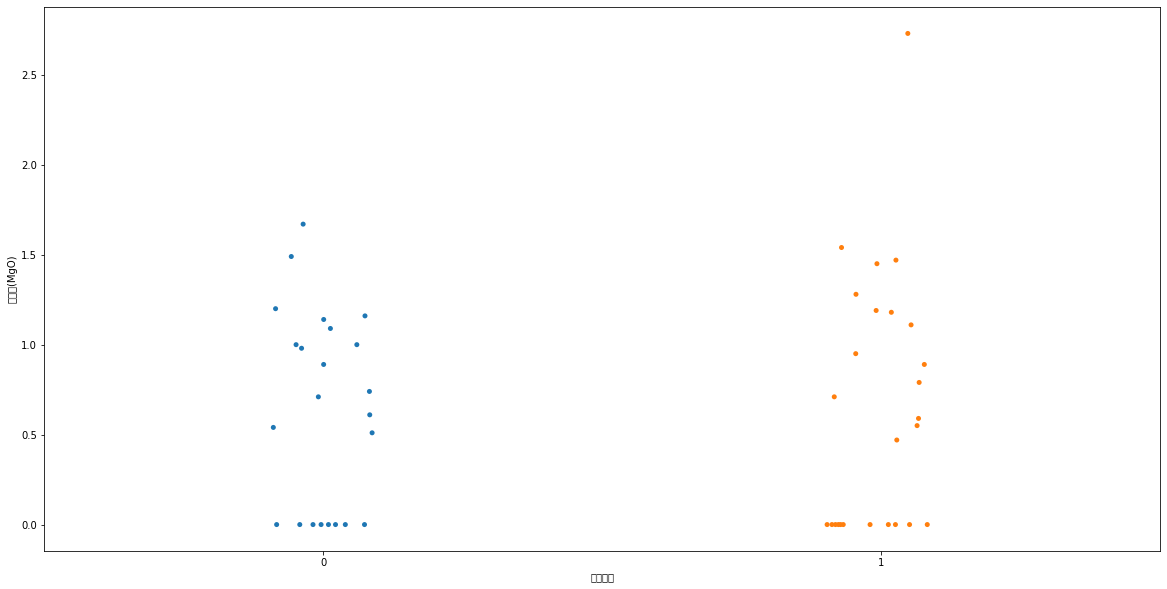

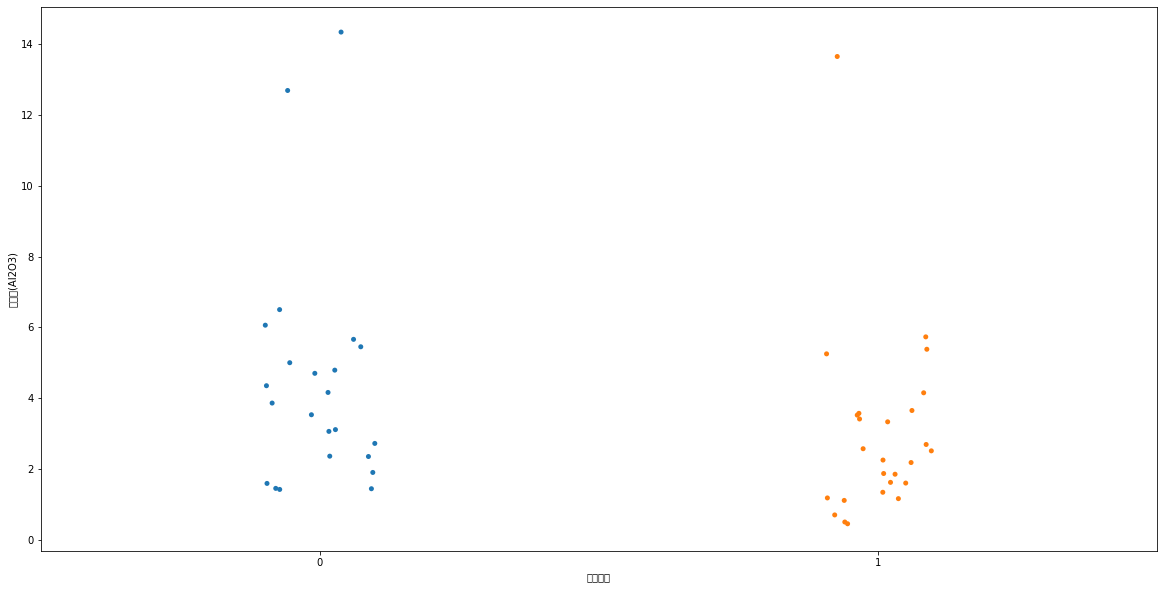

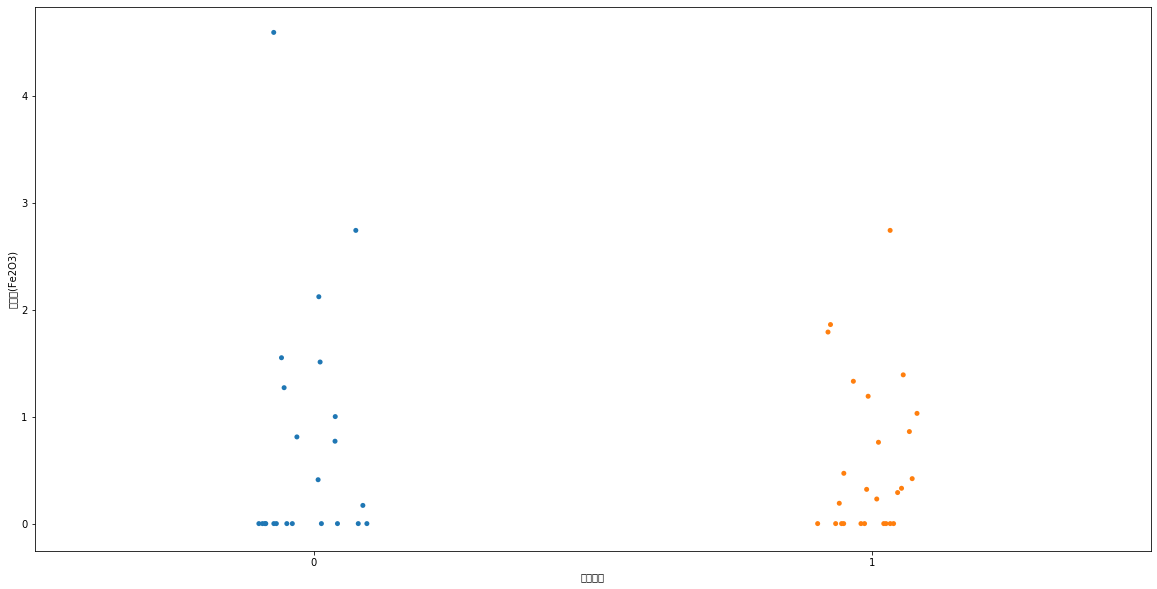

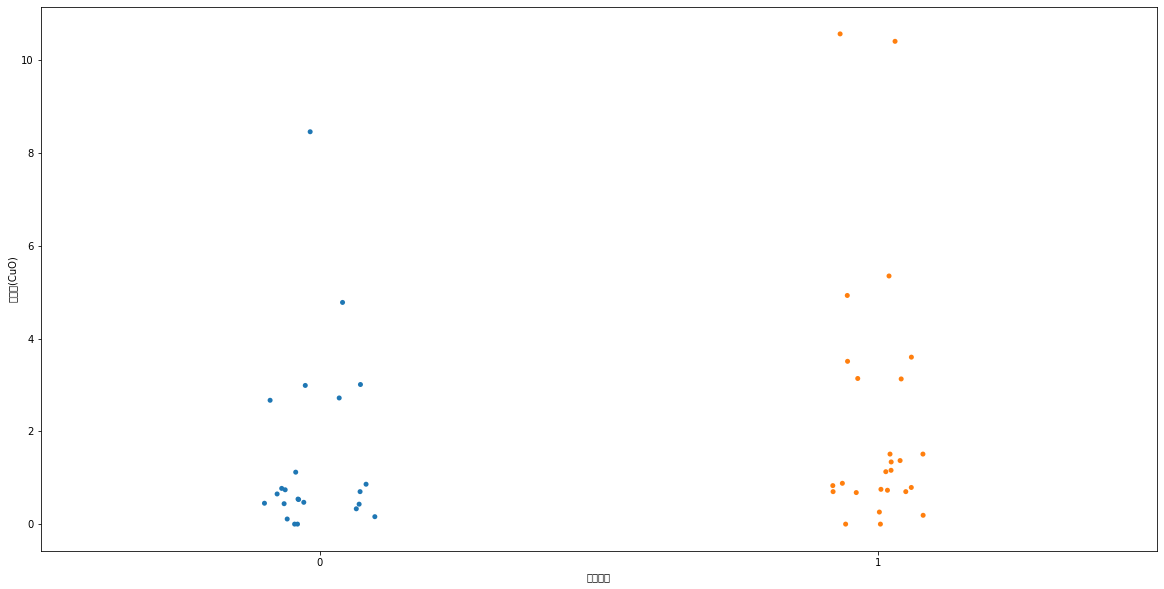

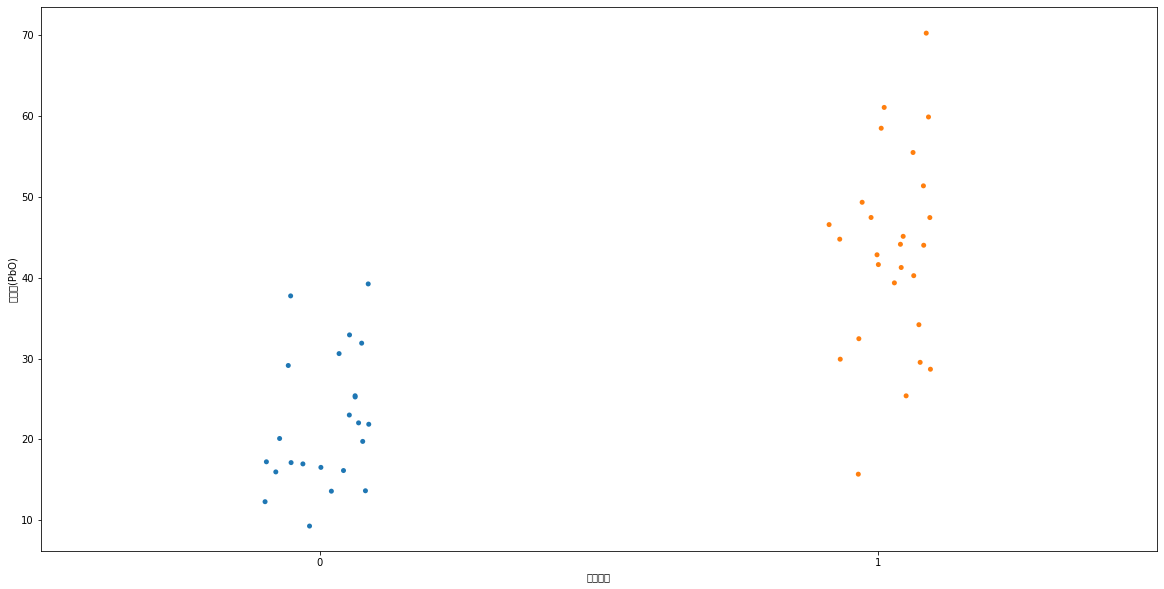

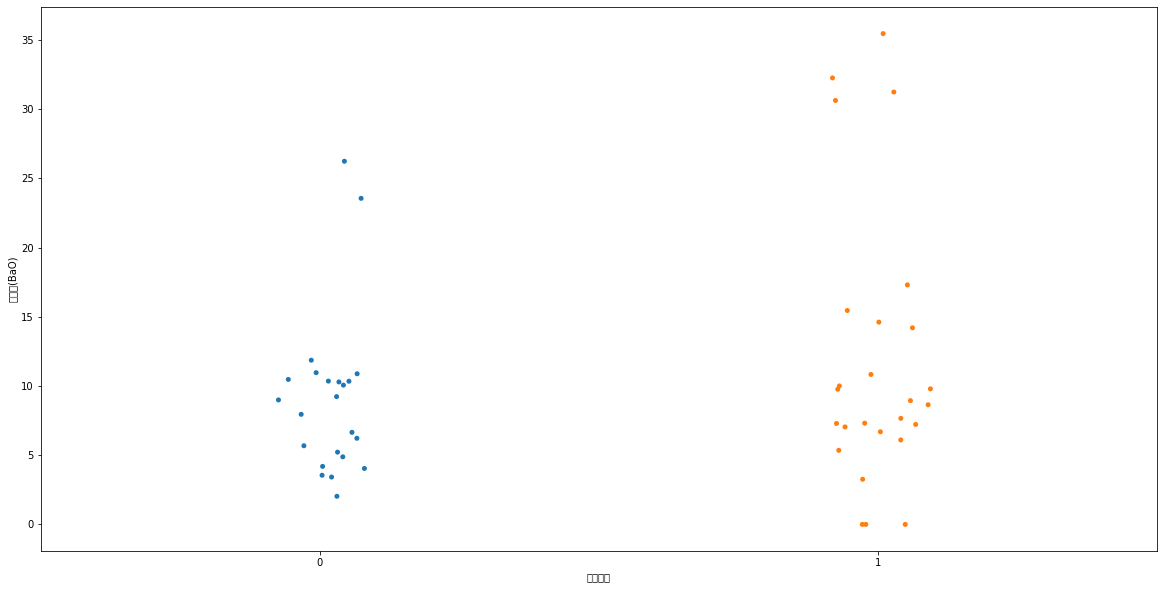

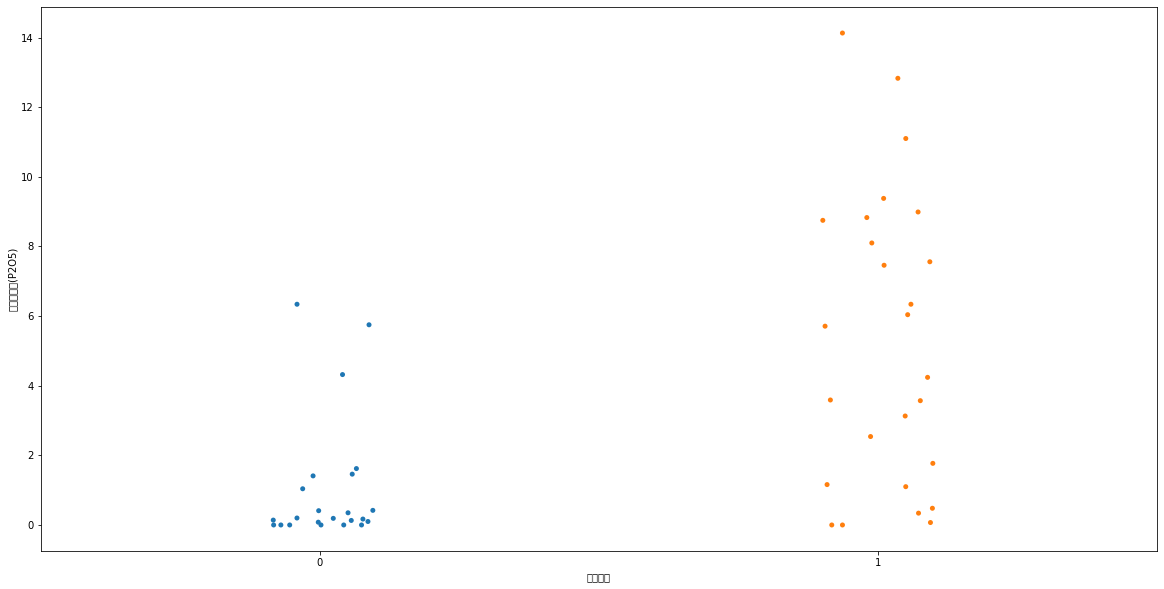

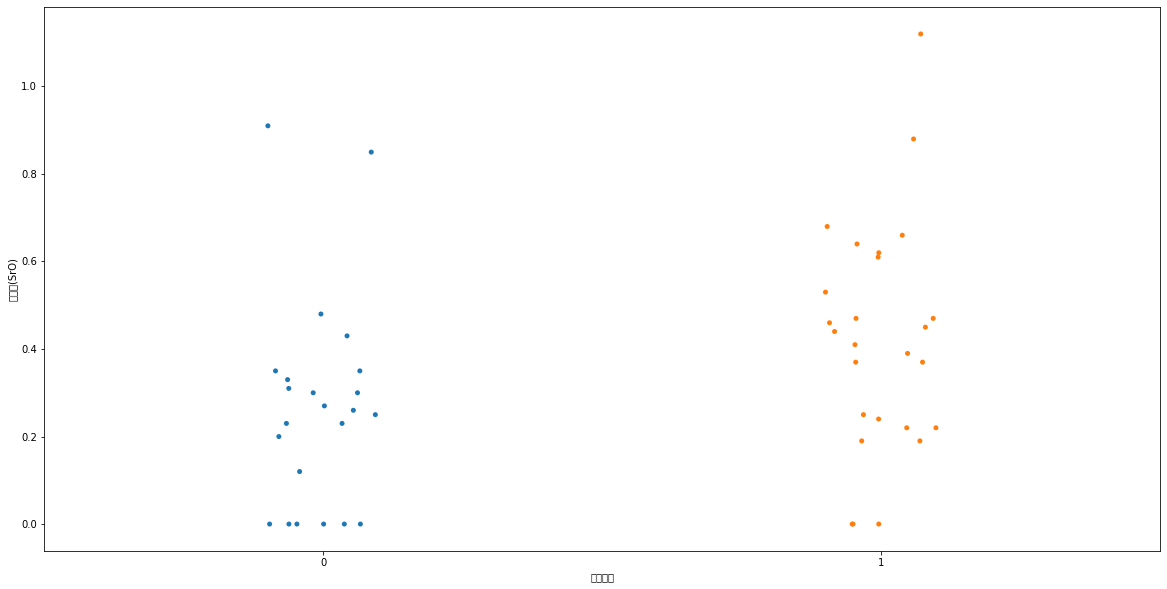

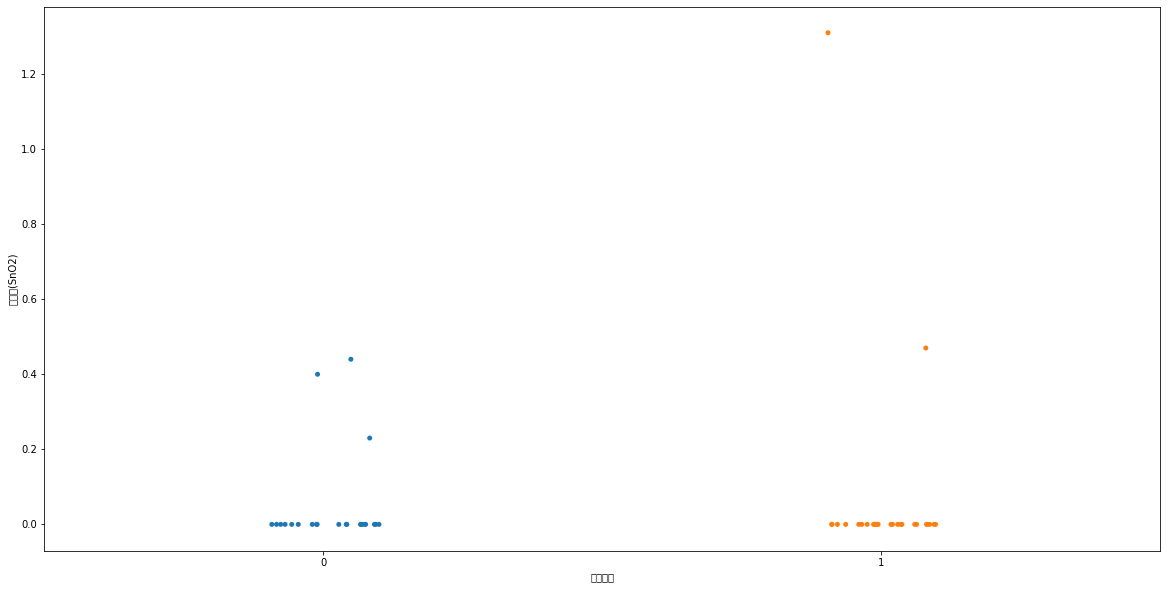

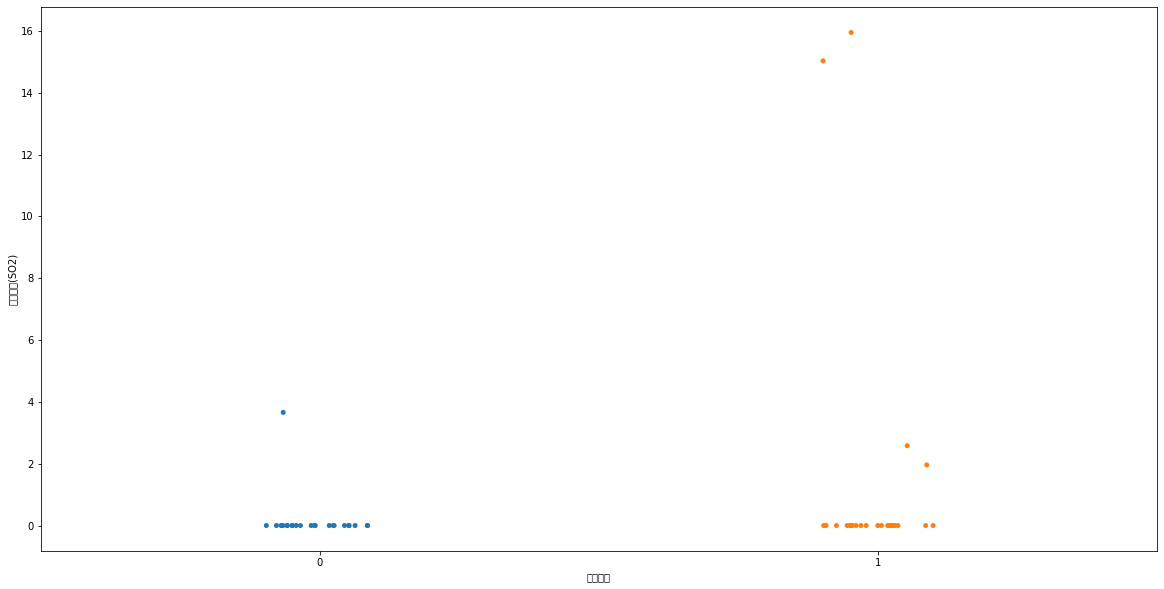

In [39]:
for col in chem_cols:
    plt.figure(figsize=(20, 10))
    sns.stripplot(x= '表面风化',y = col, data=data_2_type1)

In [40]:
data_changed = data_2.iloc[[9, 10, 26, 27, 53, 54, 55, 56], :]

In [41]:
data_changed = data_changed.sort_values(by = ['文物编号','表面风化'])

In [42]:
for col in chem_cols:
    data_changed[col+'_delta'] = data_changed[col]-data_changed.groupby('文物编号').shift(-1)[col]

In [43]:
for col in chem_cols:
    data_changed[col+'_rate'] = data_changed[col+'_delta']/data_changed[col]

In [44]:
data_changed

,文物采样点,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),文物编号,表面风化,类型,二氧化硅(SiO2)_delta,氧化钠(Na2O)_delta,氧化钾(K2O)_delta,氧化钙(CaO)_delta,氧化镁(MgO)_delta,氧化铝(Al2O3)_delta,氧化铁(Fe2O3)_delta,氧化铜(CuO)_delta,氧化铅(PbO)_delta,氧化钡(BaO)_delta,五氧化二磷(P2O5)_delta,氧化锶(SrO)_delta,氧化锡(SnO2)_delta,二氧化硫(SO2)_delta,二氧化硅(SiO2)_rate,氧化钠(Na2O)_rate,氧化钾(K2O)_rate,氧化钙(CaO)_rate,氧化镁(MgO)_rate,氧化铝(Al2O3)_rate,氧化铁(Fe2O3)_rate,氧化铜(CuO)_rate,氧化铅(PbO)_rate,氧化钡(BaO)_rate,五氧化二磷(P2O5)_rate,氧化锶(SrO)_rate,氧化锡(SnO2)_rate,二氧化硫(SO2)_rate
9,08,20.14,0.0,0.0,1.48,0.00,1.34,0.00,10.41,28.68,31.23,3.59,0.37,0.0,2.58,8,1,1,15.53,0.0,0.0,-1.71,0.00,0.23,0.00,7.27,-3.77,0.61,-3.97,-0.16,0.0,-12.45,0.771102,NaN,NaN,-1.155405,NaN,0.171642,NaN,0.698367,-0.131450,0.019533,-1.105850,-0.432432,NaN,-4.825581
10,08严重风化点,4.61,0.0,0.0,3.19,0.00,1.11,0.00,3.14,32.45,30.62,7.56,0.53,0.0,15.03,8,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,26,19.79,0.0,0.0,1.44,0.00,0.70,0.00,10.57,29.53,32.25,3.13,0.45,0.0,1.96,26,1,1,16.07,0.0,-0.4,-1.57,0.00,-0.48,0.00,6.97,-0.39,-3.20,-2.91,-0.17,0.0,-13.99,0.812026,NaN,-inf,-1.090278,NaN,-0.685714,NaN,0.659413,-0.013207,-0.099225,-0.929712,-0.377778,NaN,-7.137755
27,26严重风化点,3.72,0.0,0.4,3.01,0.00,1.18,0.00,3.60,29.92,35.45,6.04,0.62,0.0,15.95,26,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,49未风化点,54.61,0.0,0.3,2.08,1.20,6.50,1.27,0.45,23.02,4.19,4.32,0.30,0.0,0.00,49,0,1,25.82,0.0,0.3,-2.50,-0.27,1.12,-1.47,-0.25,-11.16,-1.91,-6.78,-0.16,0.0,0.00,0.472807,NaN,1.0,-1.201923,-0.22500,0.172308,-1.15748,-0.555556,-0.484796,-0.455847,-1.569444,-0.533333,NaN,NaN
53,49,28.79,0.0,0.0,4.58,1.47,5.38,2.74,0.70,34.18,6.10,11.10,0.46,0.0,0.00,49,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,50未风化点,45.02,0.0,0.0,3.12,0.54,4.16,0.00,0.70,30.61,6.22,6.34,0.23,0.0,0.00,50,0,1,27.04,0.0,0.0,-0.07,0.07,2.29,-0.33,-0.43,-13.39,-7.98,0.00,-0.43,0.0,0.00,0.600622,NaN,NaN,-0.022436,0.12963,0.550481,-inf,-0.614286,-0.437439,-1.282958,0.000000,-1.869565,NaN,NaN
55,50,17.98,0.0,0.0,3.19,0.47,1.87,0.33,1.13,44.00,14.20,6.34,0.66,0.0,0.00,50,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
rate_cols=[col for col in data_changed.columns if 'rate' in col]

In [46]:

data_changed.loc[[9, 26,54,56],rate_cols]

,二氧化硅(SiO2)_rate,氧化钠(Na2O)_rate,氧化钾(K2O)_rate,氧化钙(CaO)_rate,氧化镁(MgO)_rate,氧化铝(Al2O3)_rate,氧化铁(Fe2O3)_rate,氧化铜(CuO)_rate,氧化铅(PbO)_rate,氧化钡(BaO)_rate,五氧化二磷(P2O5)_rate,氧化锶(SrO)_rate,氧化锡(SnO2)_rate,二氧化硫(SO2)_rate
9,0.771102,NaN,NaN,-1.155405,NaN,0.171642,NaN,0.698367,-0.131450,0.019533,-1.105850,-0.432432,NaN,-4.825581
26,0.812026,NaN,-inf,-1.090278,NaN,-0.685714,NaN,0.659413,-0.013207,-0.099225,-0.929712,-0.377778,NaN,-7.137755
54,0.472807,NaN,1.0,-1.201923,-0.22500,0.172308,-1.15748,-0.555556,-0.484796,-0.455847,-1.569444,-0.533333,NaN,NaN
56,0.600622,NaN,NaN,-0.022436,0.12963,0.550481,-inf,-0.614286,-0.437439,-1.282958,0.000000,-1.869565,NaN,NaN


In [47]:
rate_dict={'二氧化硅(SiO2)':0.66,
 '氧化钠(Na2O)':0,
 '氧化钾(K2O)':0,
 '氧化钙(CaO)':-0.87,
 '氧化镁(MgO)':0,
 '氧化铝(Al2O3)':0.05,
 '氧化铁(Fe2O3)':-1.15,
 '氧化铜(CuO)':0,
 '氧化铅(PbO)':-0.25,
 '氧化钡(BaO)':-0.425,
 '五氧化二磷(P2O5)':-0.875,
 '氧化锶(SrO)':-0.75,
 '氧化锡(SnO2)':-0.775,
 '二氧化硫(SO2)':-5.9}

In [48]:
rate_dict

{'二氧化硅(SiO2)': 0.66,
 '氧化钠(Na2O)': 0,
 '氧化钾(K2O)': 0,
 '氧化钙(CaO)': -0.87,
 '氧化镁(MgO)': 0,
 '氧化铝(Al2O3)': 0.05,
 '氧化铁(Fe2O3)': -1.15,
 '氧化铜(CuO)': 0,
 '氧化铅(PbO)': -0.25,
 '氧化钡(BaO)': -0.425,
 '五氧化二磷(P2O5)': -0.875,
 '氧化锶(SrO)': -0.75,
 '氧化锡(SnO2)': -0.775,
 '二氧化硫(SO2)': -5.9}

In [50]:
#对未风化数据进行假设性检验
data_2_type0 = data_2[(data_2['类型']==0) & (data_2['表面风化']==0)]
data_2_type1 = data_2[(data_2['类型']==1) & (data_2['表面风化']==0)]

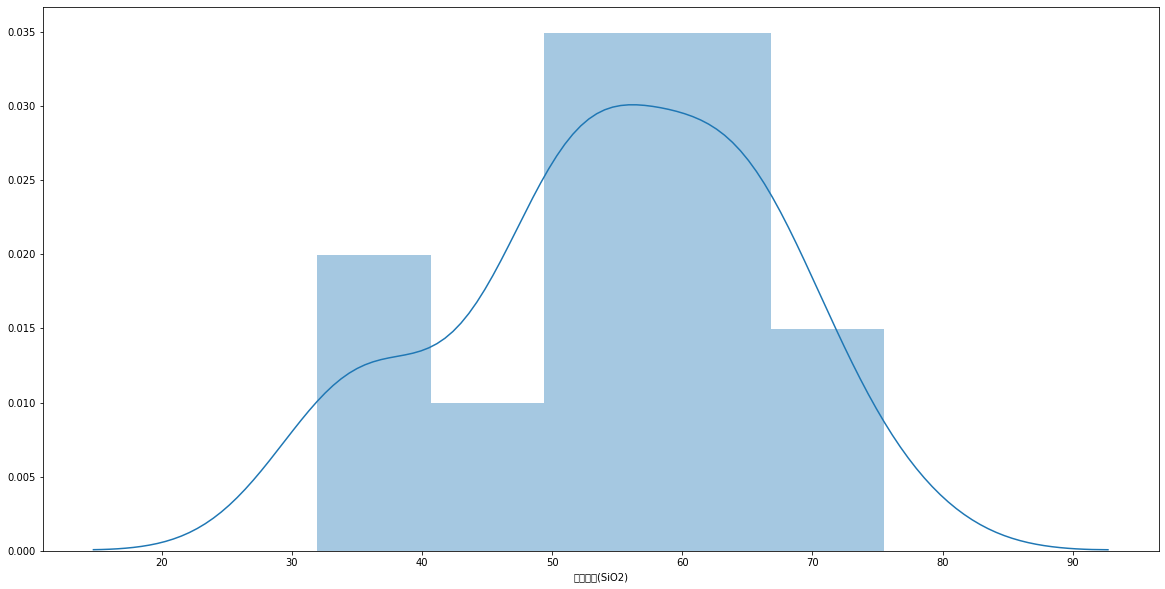

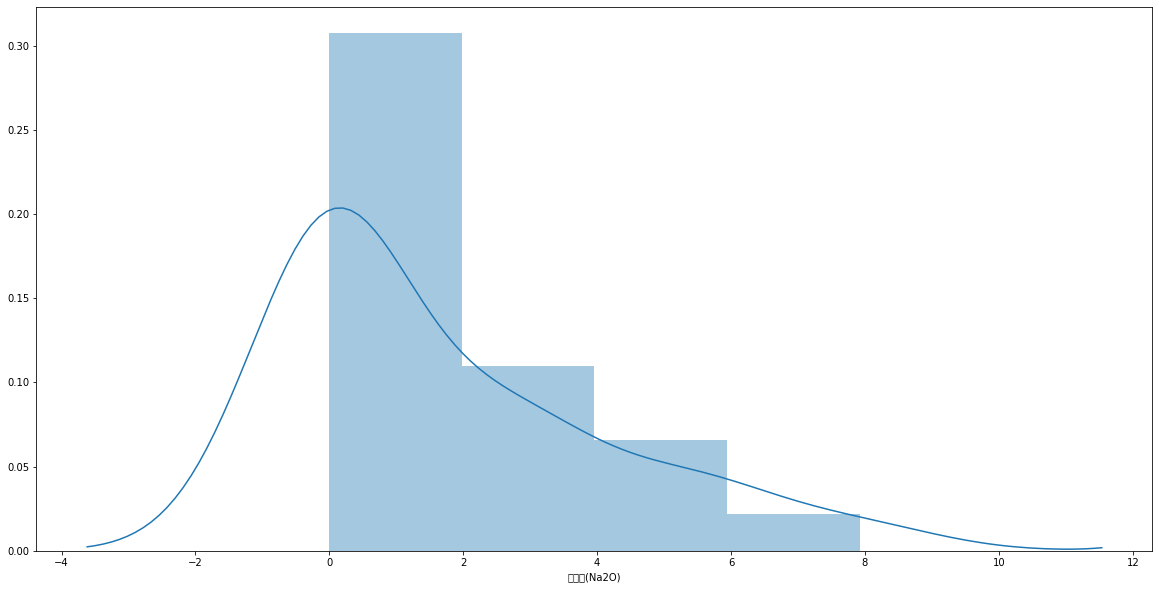

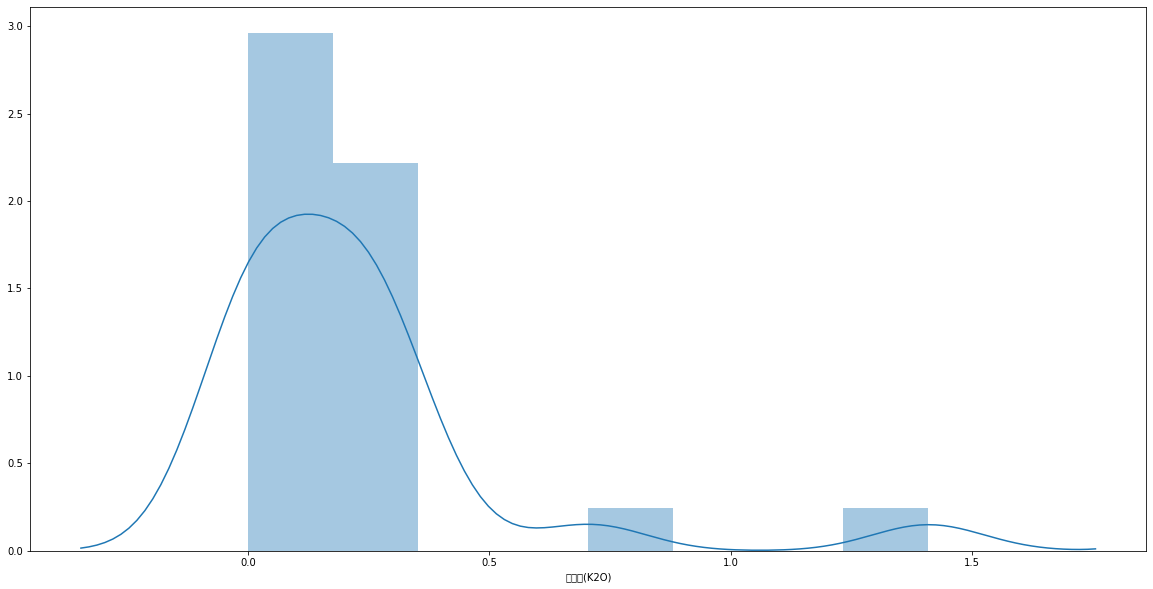

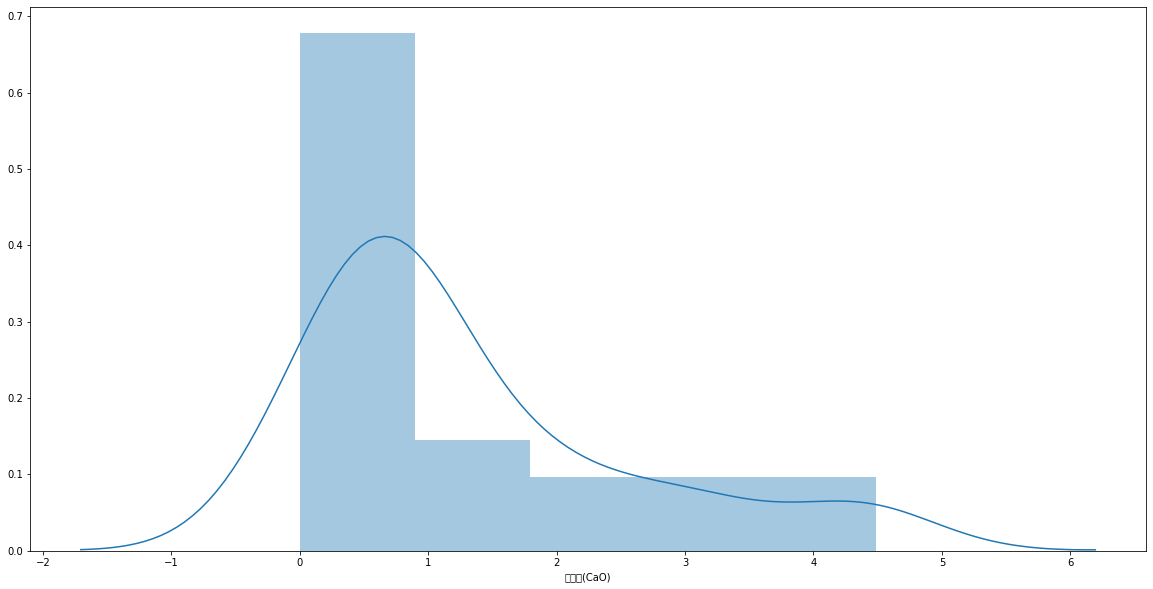

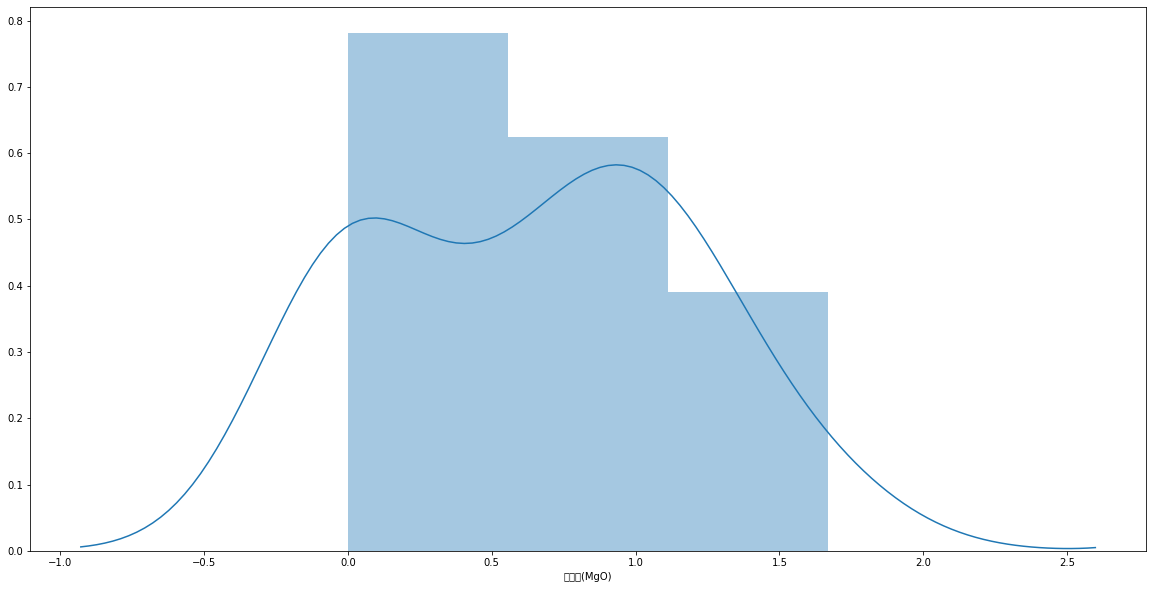

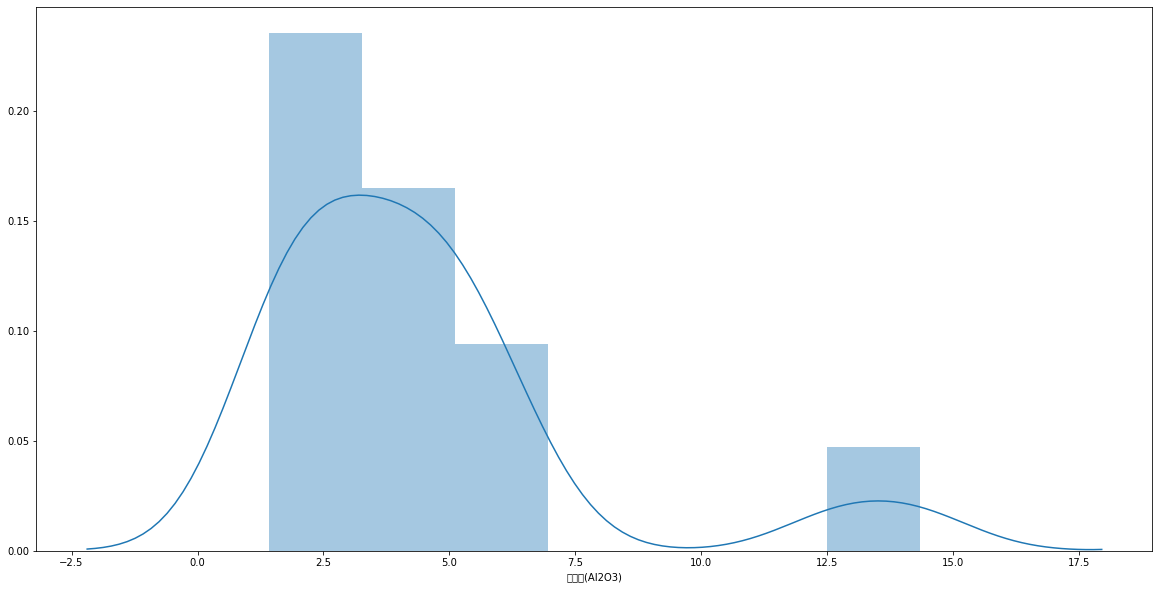

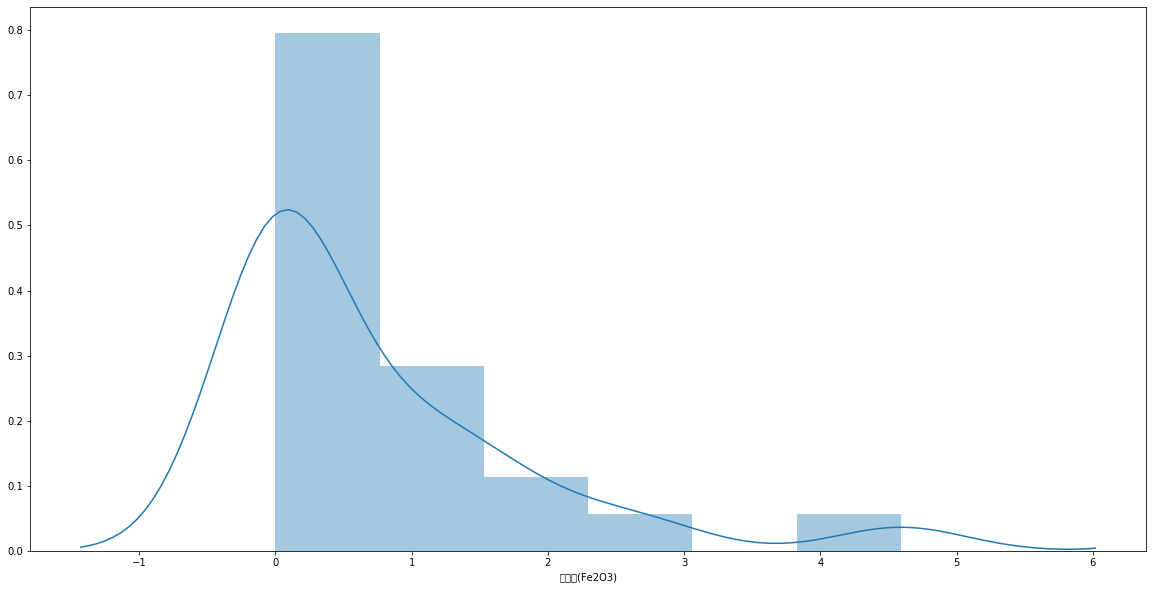

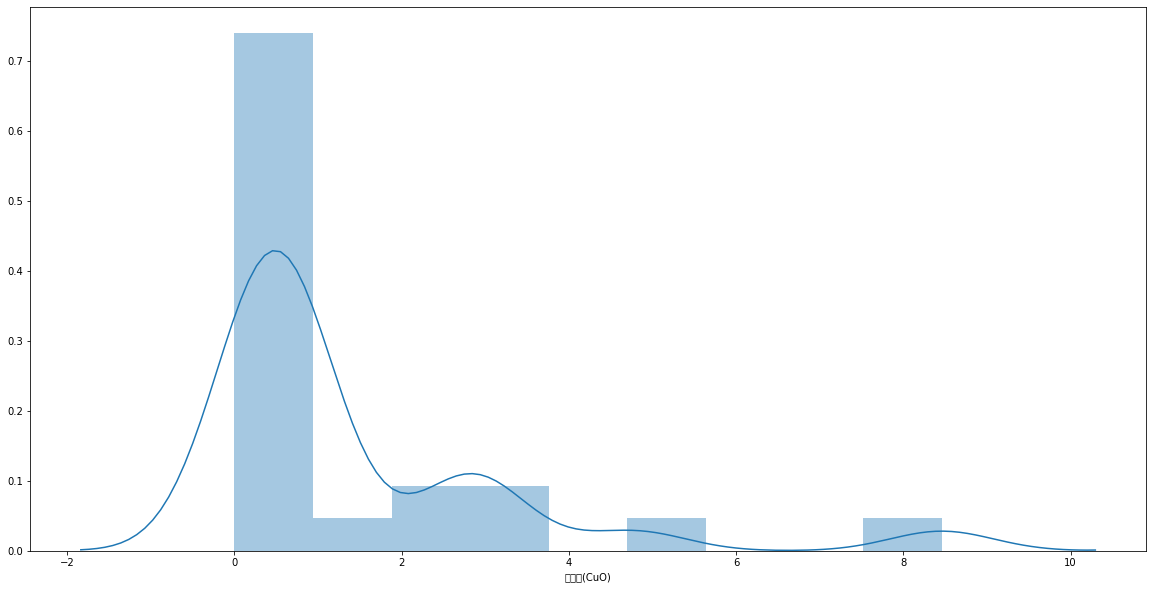

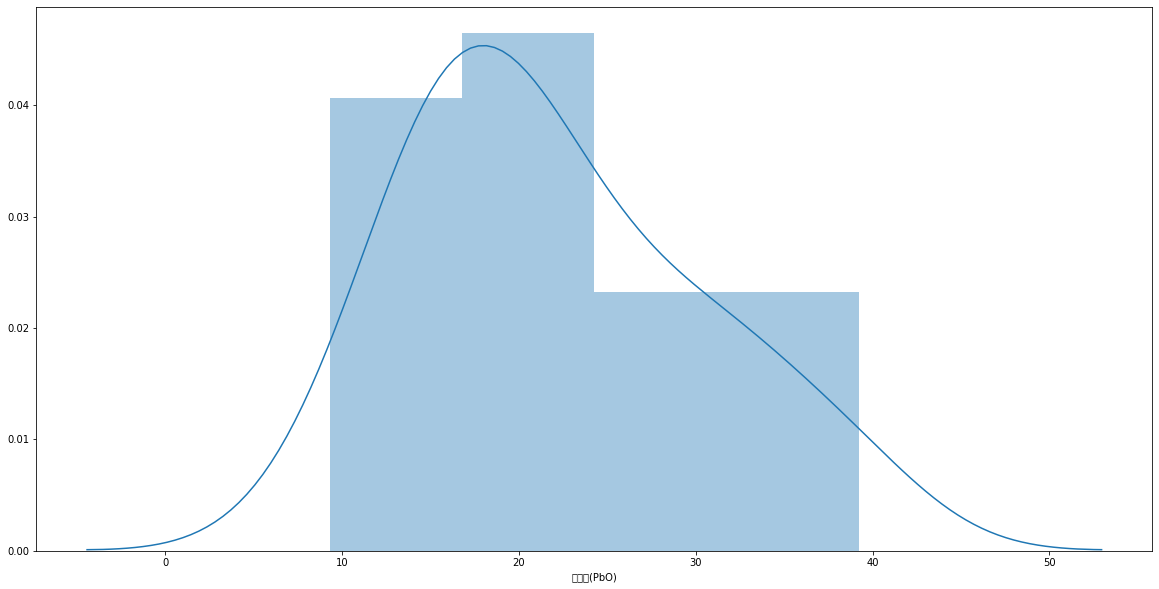

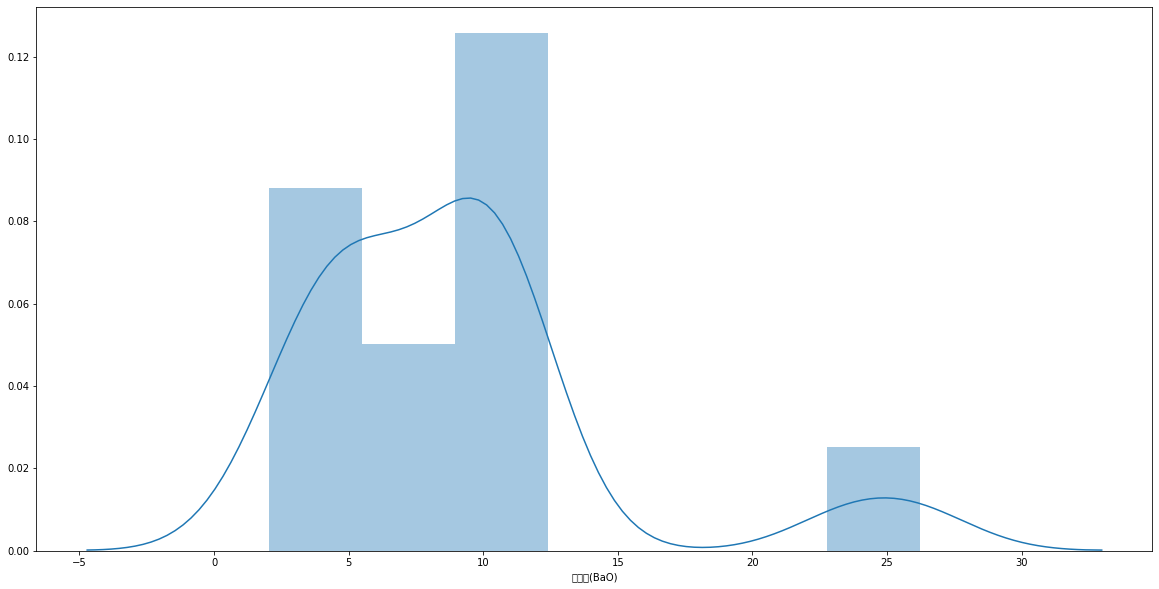

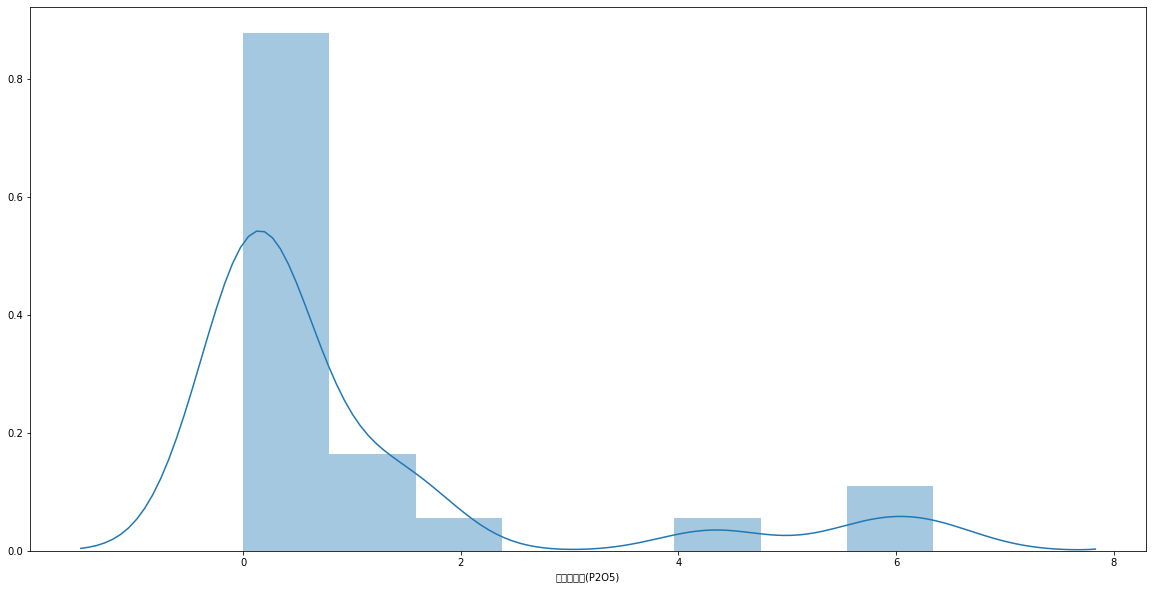

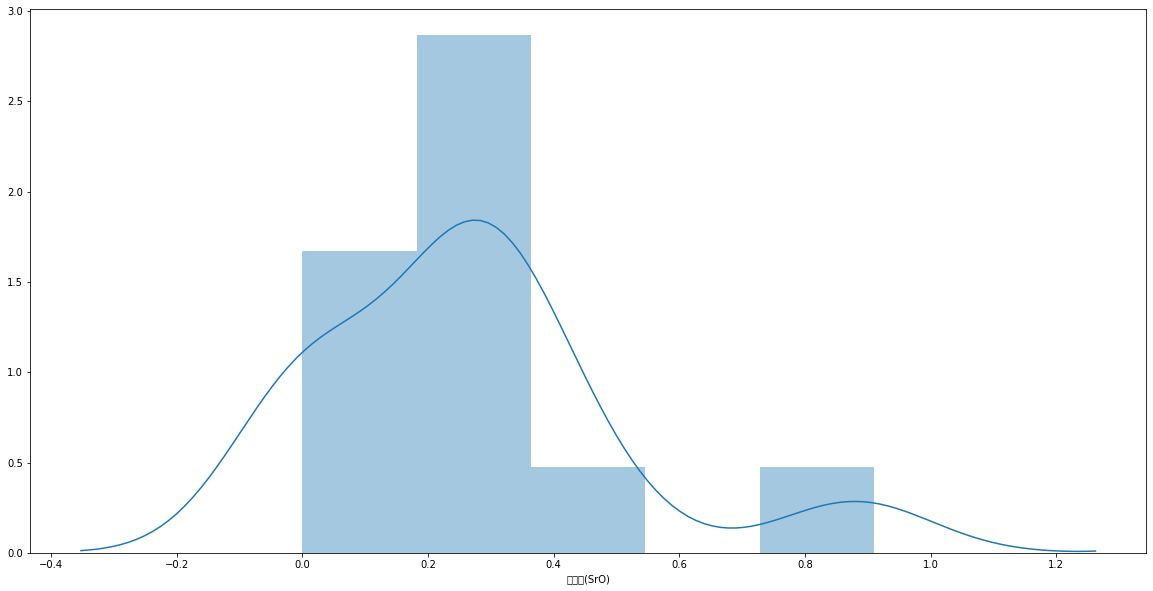

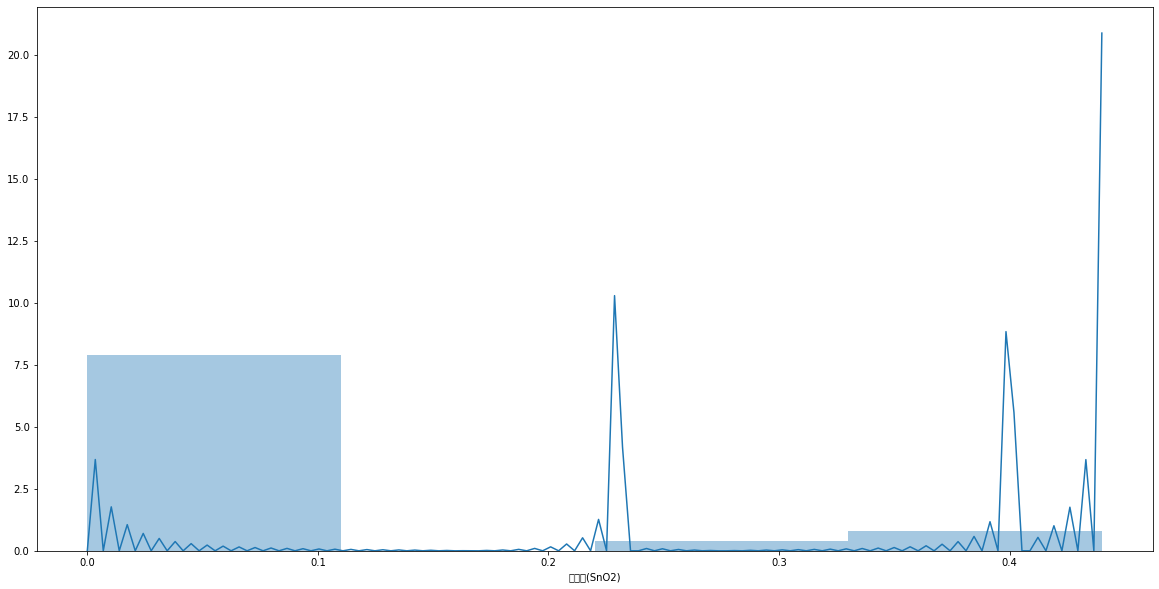

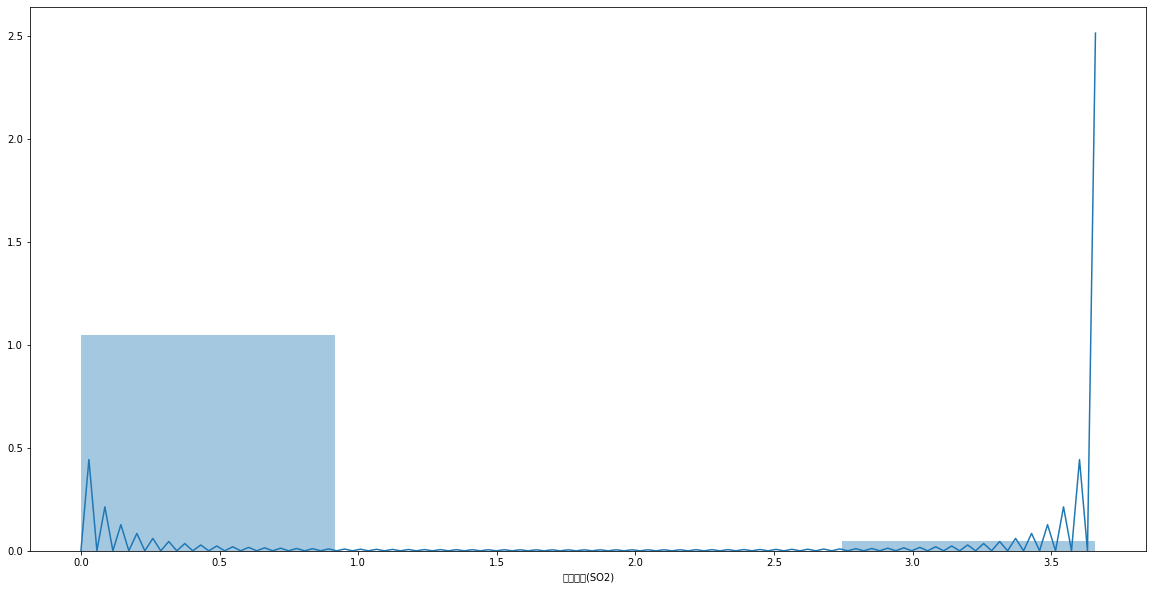

In [51]:
for col in chem_cols:
    plt.figure(figsize=(20, 10))
    sns.distplot(data_2_type1[col],hist=True, kde=True)
    plt.show()

,sumsquare_error,aic,bic,kl_div
gamma,0.022123,156.455927,-68.097655,inf
powerlognorm,0.022218,162.010603,-65.561546,inf
pareto,0.022287,158.692083,-68.009014,inf
burr12,0.022327,160.700066,-65.502844,inf
pearson3,0.022331,159.805127,-67.985644,inf


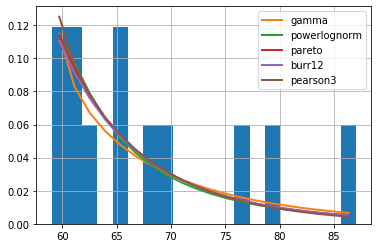

In [27]:
from fitter import Fitter
f = Fitter(data_2_type0['二氧化硅(SiO2)'], bins=20)
f.fit()
f.summary()

In [28]:
f.get_best()

{'gamma': (0.8075374650987821, 59.00999999999999, 12.387898885459395)}

In [50]:
data_2_fenhua1 = data_2[data_2['表面风化']==1]

In [29]:
from scipy import stats
llen = data_2_type0["二氧化硅(SiO2)"].shape[0]-1
mu = np.mean(data_2_type0["二氧化硅(SiO2)"])
std = np.std(data_2_type0["二氧化硅(SiO2)"], ddof=1)
se = std/np.sqrt(data_2_type0["二氧化硅(SiO2)"].shape[0])
interval = stats.t.interval(0.95, llen, mu, se)

In [53]:
ls0 = []
for col in chem_cols:
    llen = data_2_type0[col].shape[0]-1
    mu = np.mean(data_2_type0[col])
    std = np.std(data_2_type0[col], ddof=1)
    se = std/np.sqrt(data_2_type0[col].shape[0])
    interval = stats.t.interval(0.95, llen, mu, se)
    ls0.append(interval)
    print(col,interval)

二氧化硅(SiO2) (69.4497552104251, 83.8380225673527)
氧化钠(Na2O) (-0.07806778845718826, 1.0047344551238548)
氧化钾(K2O) (3.762183368789476, 9.041149964543859)
氧化钙(CaO) (2.199907685987223, 5.490092314012775)
氧化镁(MgO) (0.43102930562983616, 1.138970694370164)
氧化铝(Al2O3) (3.5266788107274047, 6.58665452260593)
氧化铁(Fe2O3) (0.5973410469622984, 2.1548811752599244)
氧化铜(CuO) (1.4134842107188739, 2.897626900392237)
氧化铅(PbO) (0.018766775013037917, 0.530122113875851)
氧化钡(BaO) (-0.019643512779763617, 0.8174212905575413)
五氧化二磷(P2O5) (0.3915044292000641, 1.6651622374666024)
氧化锶(SrO) (0.005963972629042837, 0.049591582926512716)
氧化锡(SnO2) (-0.14550915353812813, 0.40773137576035035)
二氧化硫(SO2) (-0.01037824748955539, 0.14593380304511094)


In [55]:
ls1 = []
for col in chem_cols:
    llen = data_2_type1[col].shape[0]-1
    mu = np.mean(data_2_type1[col])
    std = np.std(data_2_type1[col], ddof=1)
    se = std/np.sqrt(data_2_type1[col].shape[0])
    interval = stats.t.interval(0.95, llen, mu, se)
    ls1.append(interval)
    print(col,interval)

二氧化硅(SiO2) (33.51962036552167, 44.23140004264159)
氧化钠(Na2O) (0.3838028961913691, 1.4251766956453653)
氧化钾(K2O) (0.09433548196118141, 0.2526032935490227)
氧化钙(CaO) (1.580485908261768, 2.519514091738231)
氧化镁(MgO) (0.4645397206490381, 0.826480687514227)
氧化铝(Al2O3) (2.8032662857610706, 4.531835755055255)
氧化铁(Fe2O3) (0.3834922612455225, 0.9283444734483555)
氧化铜(CuO) (1.1700002544403685, 2.5891834190290197)
氧化铅(PbO) (29.05581450072627, 37.642552846212524)
氧化钡(BaO) (8.097362117915619, 12.883454208614996)
五氧化二磷(P2O5) (2.1697900675881394, 4.415516054860839)
氧化锶(SrO) (0.27227260272968046, 0.42364576461725834)
氧化锡(SnO2) (-0.0030177967245271636, 0.11934432733677204)
二氧化硫(SO2) (-0.10194804744200359, 1.701131720911391)


In [102]:
data_2_fenhua1[data_2_fenhua1['类型']==0]

,文物采样点,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),文物编号,表面风化,类型
8,07,92.63,0.0,0.00,1.07,0.00,1.98,0.17,3.24,0.0,0.0,0.61,0.0,0.0,0.0,7,1,0
11,09,95.02,0.0,0.59,0.62,0.00,1.32,0.32,1.55,0.0,0.0,0.35,0.0,0.0,0.0,9,1,0
12,10,96.77,0.0,0.92,0.21,0.00,0.81,0.26,0.84,0.0,0.0,0.00,0.0,0.0,0.0,10,1,0
14,12,94.29,0.0,1.01,0.72,0.00,1.46,0.29,1.65,0.0,0.0,0.15,0.0,0.0,0.0,12,1,0
22,22,92.35,0.0,0.74,1.66,0.64,3.50,0.35,0.55,0.0,0.0,0.21,0.0,0.0,0.0,22,1,0
28,27,92.72,0.0,0.00,0.94,0.54,2.51,0.20,1.54,0.0,0.0,0.36,0.0,0.0,0.0,27,1,0


In [103]:
chosen0 = data_2_fenhua1[data_2_fenhua1['类型']==0]
chosen1 = data_2_fenhua1[data_2_fenhua1['类型']==1]

In [108]:
#根据rate以及置信区间求之前
for i in range(len(chem_cols)):
    chosen0[chem_cols[i]] = (ls0[i][0]+ls0[i][1])/2
    chosen1[chem_cols[i]] = data_2_fenhua1[chem_cols[i]]/(1-rate_dict[chem_cols[i]])

In [269]:
#修正铅钡型：
for i in range(len(data_2_fenhua1[data_2_fenhua1['类型']==1])):
    for j in range(len(chem_cols)):
        if chosen1.iloc[i, j+1] < ls1[j][0]:
            chosen1.iloc[i, j+1] = ls1[j][0]
        elif chosen1.iloc[i, j+1] >ls1[j][1]:
            chosen1.iloc[i, j+1] = ls1[j][1]

In [588]:
data_2_fenhua1 = pd.concat([chosen0, chosen1]).sort_values(by='文物采样点')

In [590]:
data_2_fenhua1.to_csv("D:/浏览器/数模/C题/1.3.csv", encoding="utf-8")

In [65]:
rate_dict['二氧化硅(SiO2)']

0.66

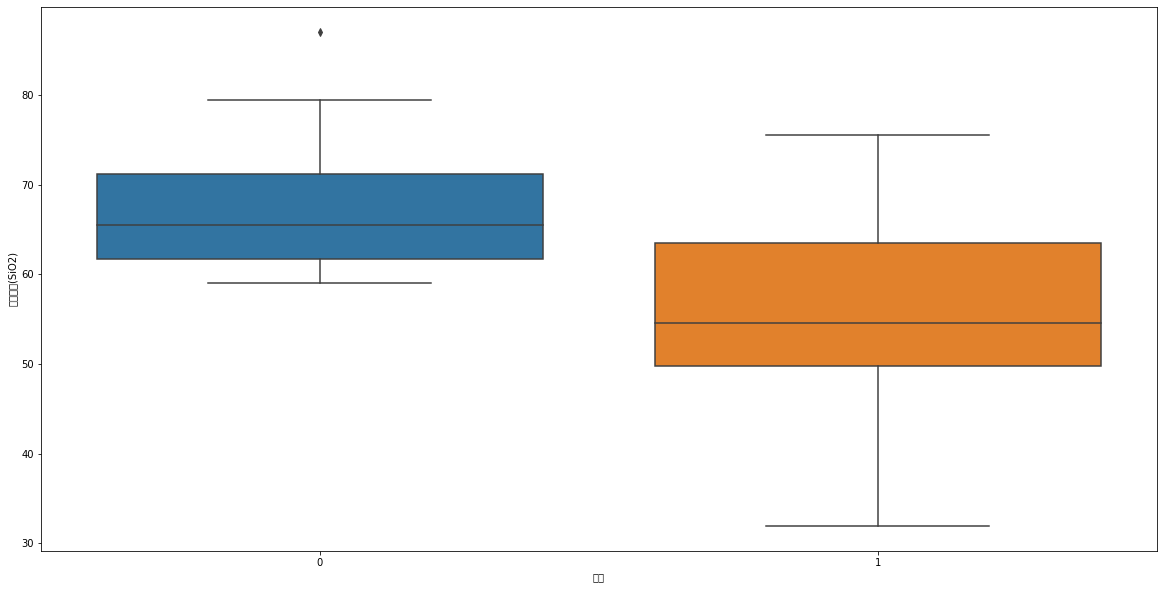

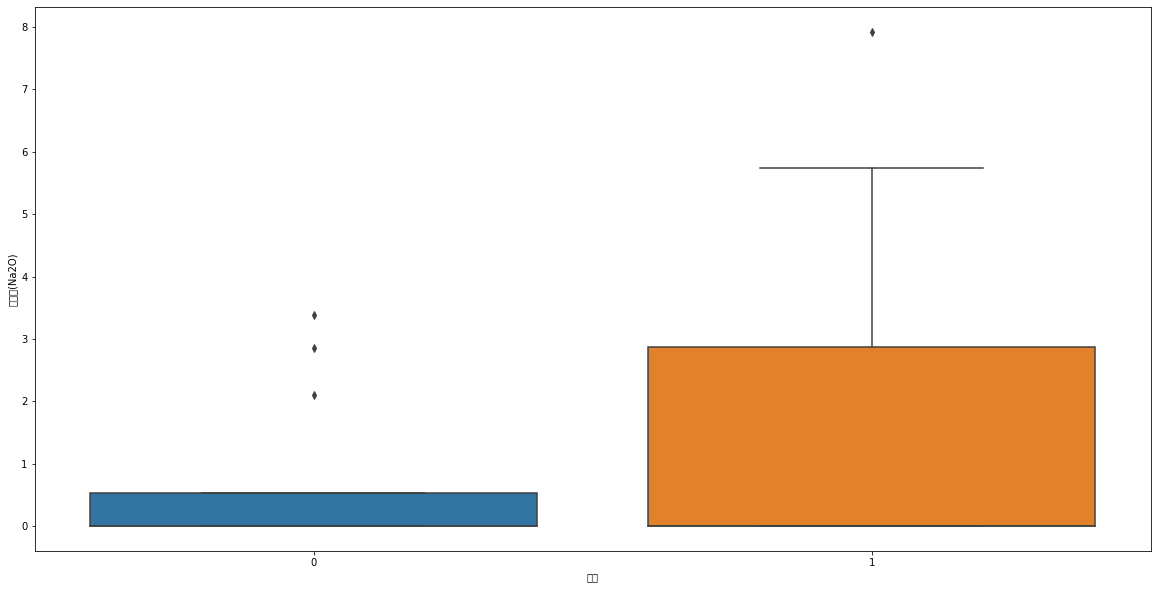

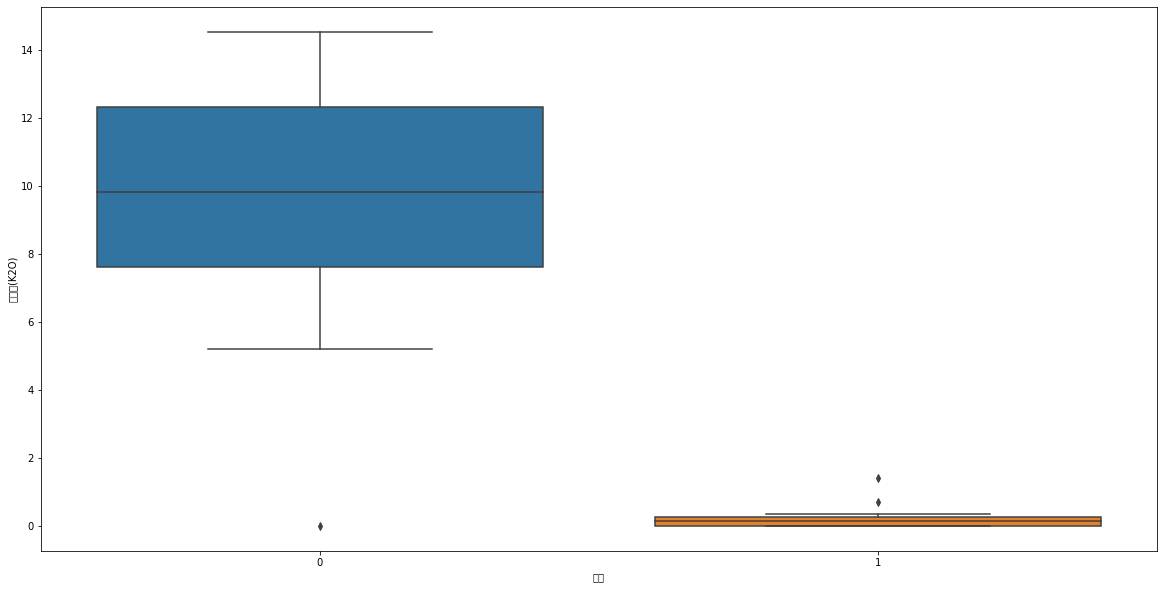

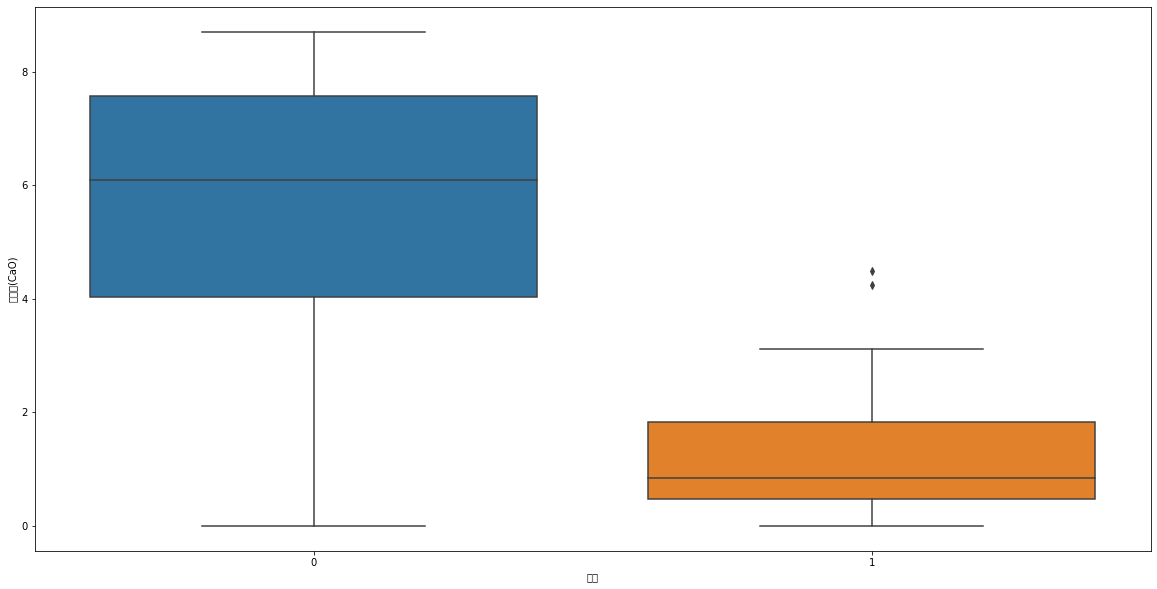

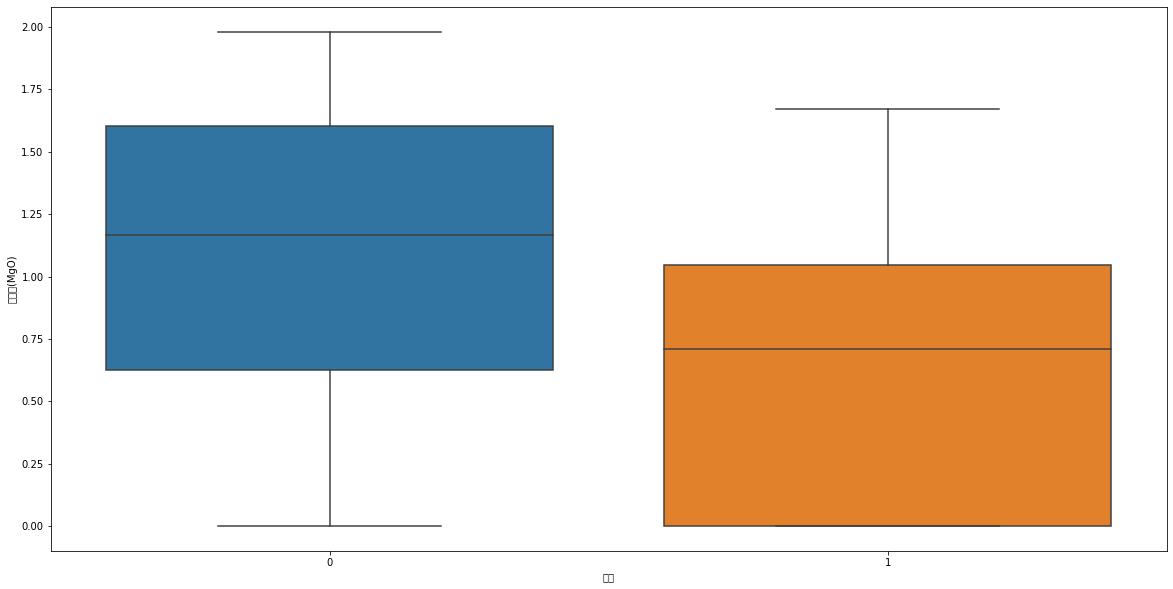

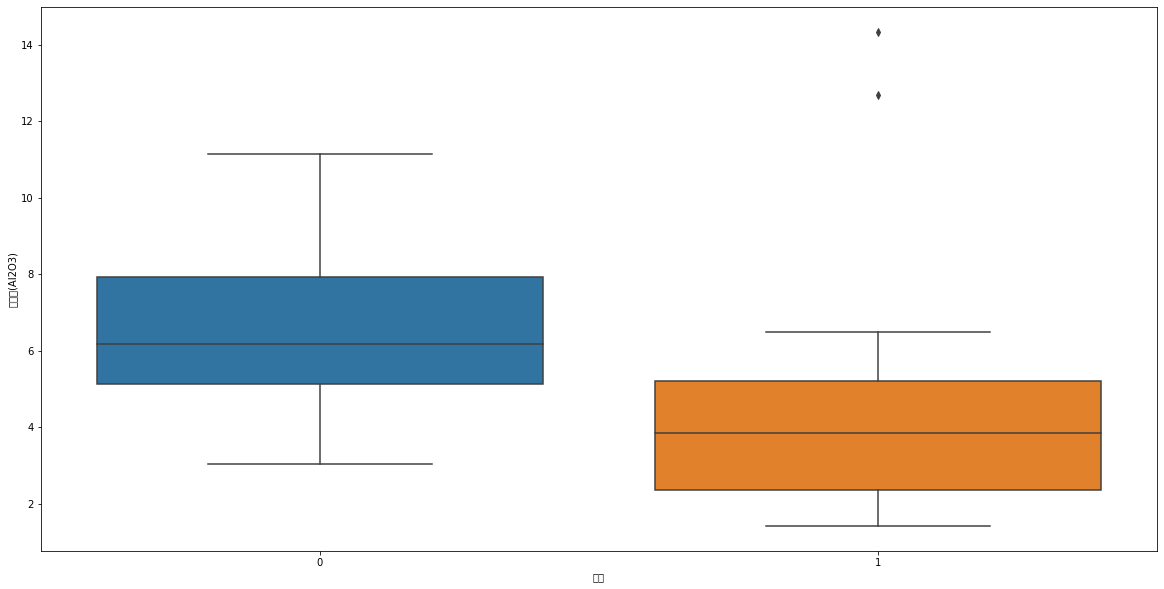

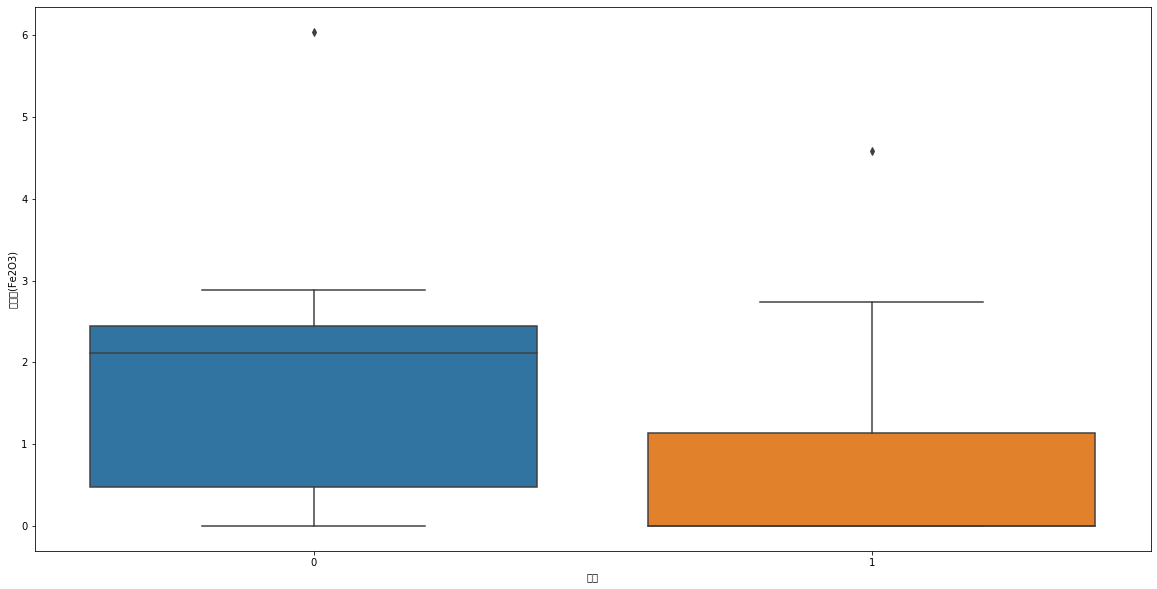

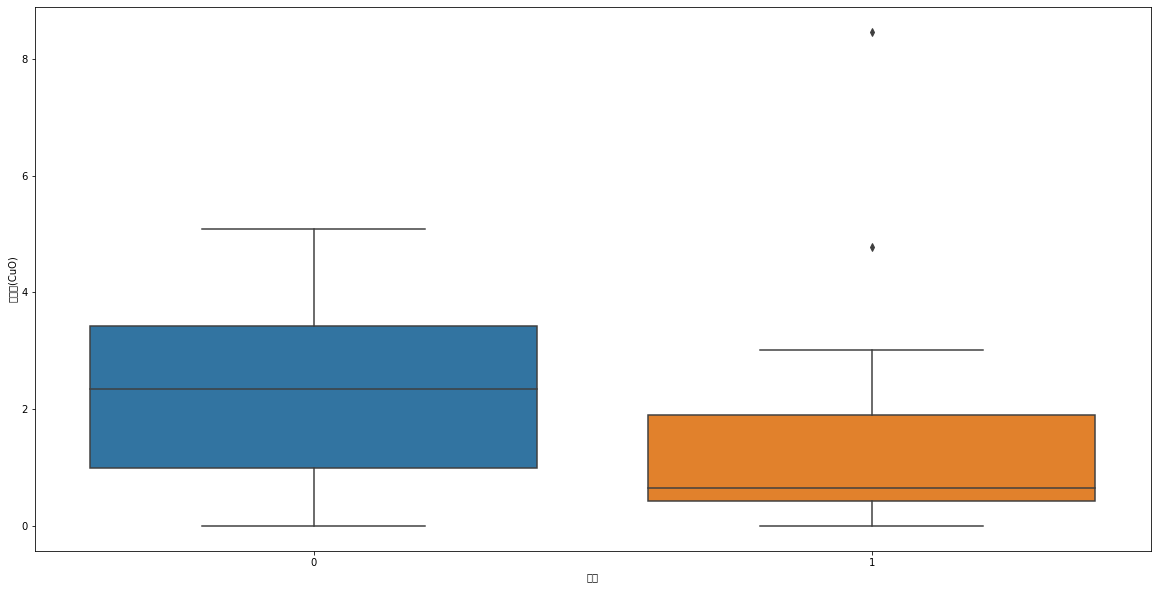

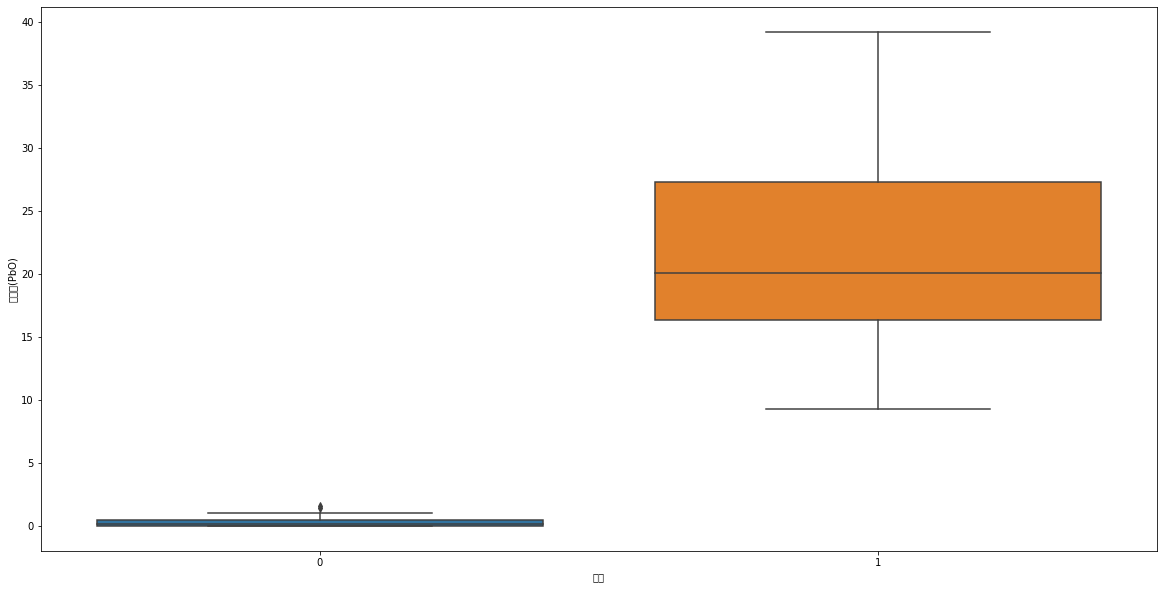

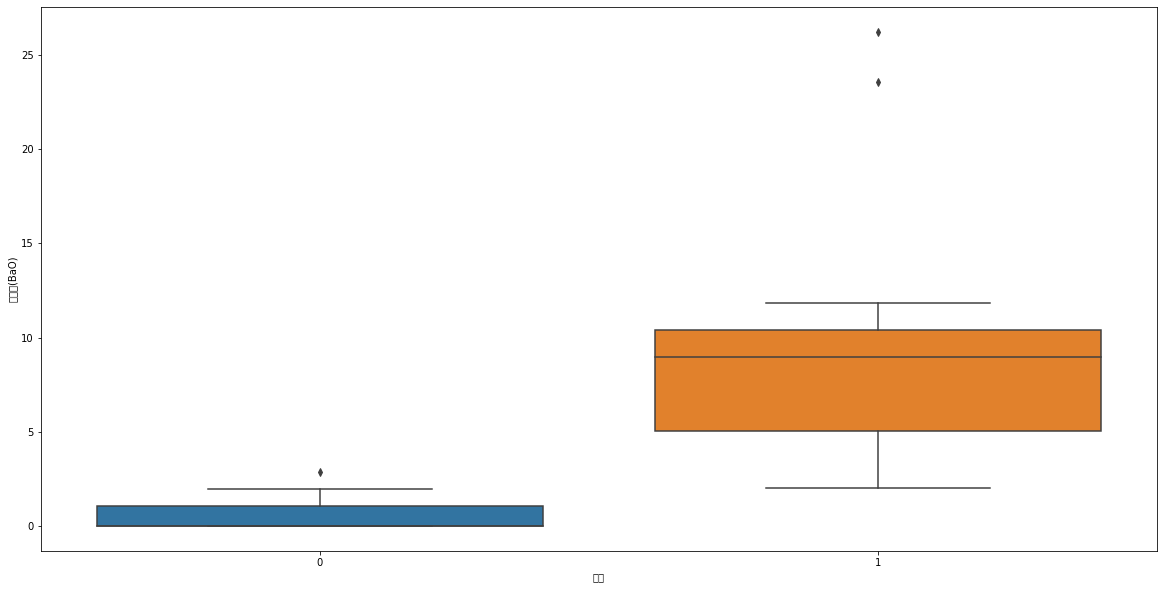

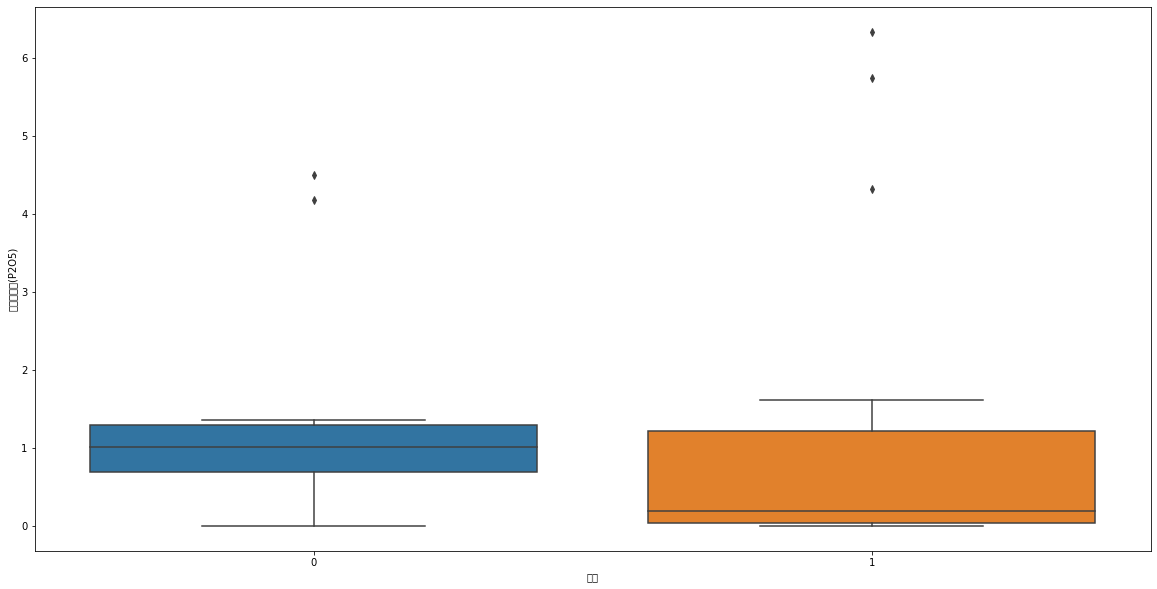

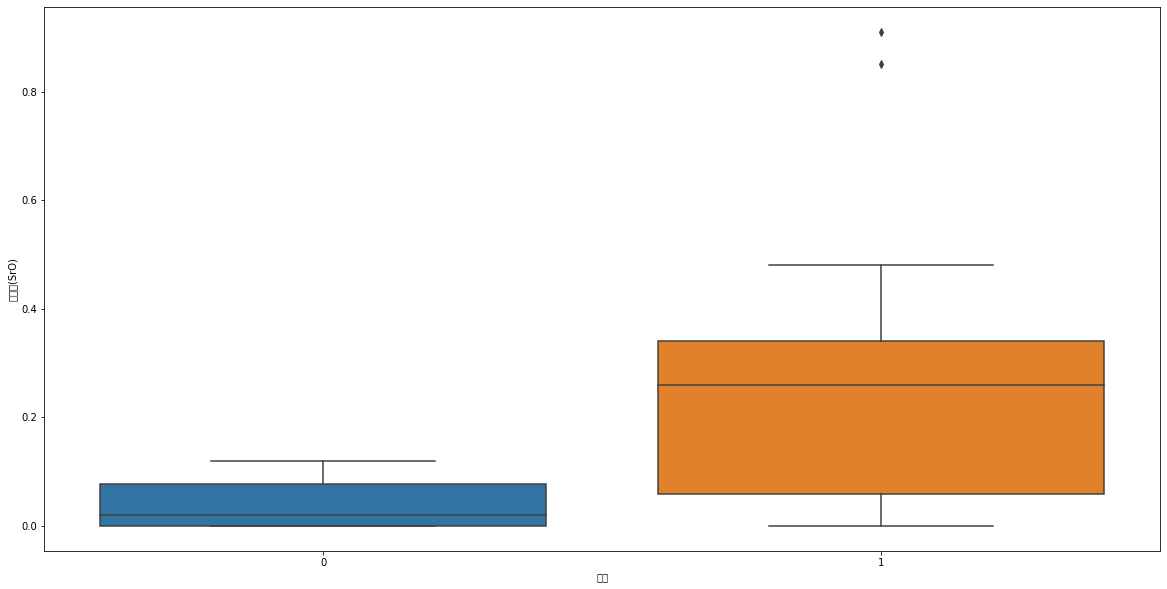

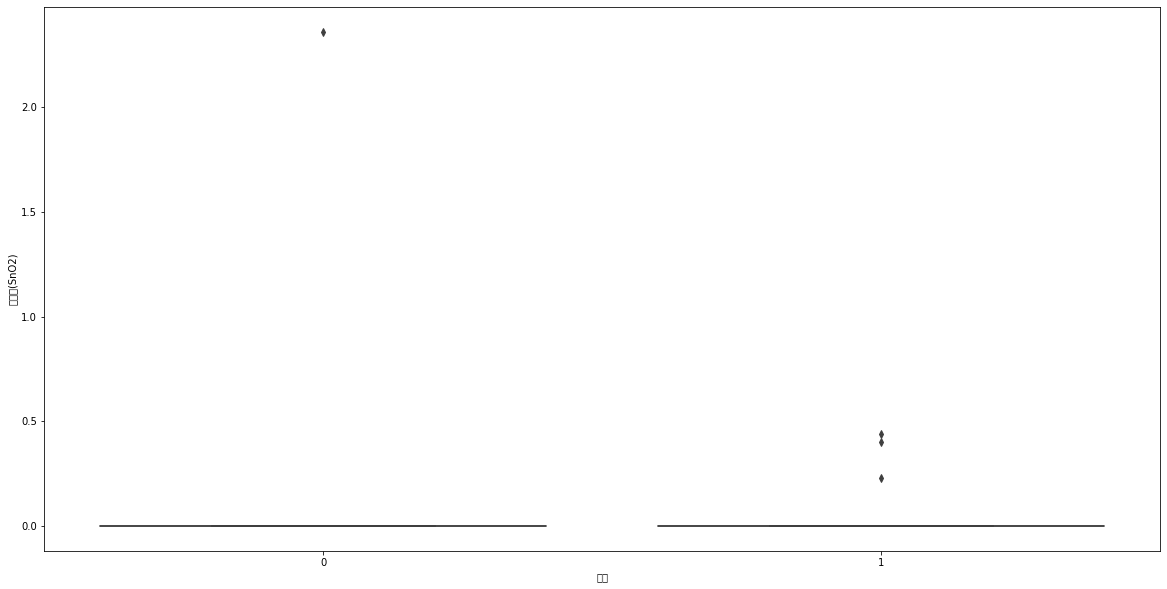

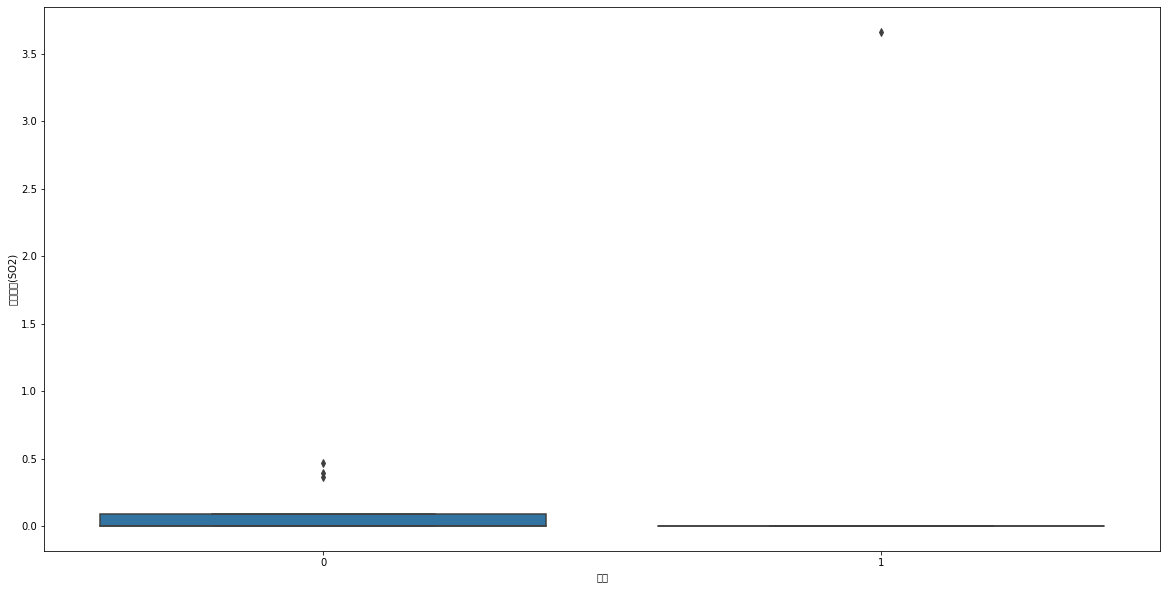

In [52]:
for col in chem_cols:
    plt.figure(figsize=(20, 10))
    sns.boxplot(x='类型',y=col,data = data_2[data_2['表面风化']==0])


In [160]:
data_2 = pd.merge(data_2, data_1[['文物编号','类型']], how='left', on='文物编号')

In [18]:
chem_cols = [col for col in data_2.columns if col not in ['文物采样点', '文物编号', '类型', '表面风化']]

In [169]:
cut_list = []

In [ ]:
for col in chem_cols:
    data_2[col],cut_bins=pd.cut(data_2[col],5,labels = range(5),retbins=True)
    cut_list.append(cut_bins)

In [171]:
cut_list

[array([ 3.62695, 22.33   , 40.94   , 59.55   , 78.16   , 96.77   ]),
 array([-0.00792,  1.584  ,  3.168  ,  4.752  ,  6.336  ,  7.92   ]),
 array([-0.01452,  2.904  ,  5.808  ,  8.712  , 11.616  , 14.52   ]),
 array([-0.0087,  1.74  ,  3.48  ,  5.22  ,  6.96  ,  8.7   ]),
 array([-0.00273,  0.546  ,  1.092  ,  1.638  ,  2.184  ,  2.73   ]),
 array([ 0.43611,  3.228  ,  6.006  ,  8.784  , 11.562  , 14.34   ]),
 array([-0.00604,  1.208  ,  2.416  ,  3.624  ,  4.832  ,  6.04   ]),
 array([-0.01057,  2.114  ,  4.228  ,  6.342  ,  8.456  , 10.57   ]),
 array([-0.07021, 14.042  , 28.084  , 42.126  , 56.168  , 70.21   ]),
 array([-0.03545,  7.09   , 14.18   , 21.27   , 28.36   , 35.45   ]),
 array([-0.01413,  2.826  ,  5.652  ,  8.478  , 11.304  , 14.13   ]),
 array([-0.00112,  0.224  ,  0.448  ,  0.672  ,  0.896  ,  1.12   ]),
 array([-0.00236,  0.472  ,  0.944  ,  1.416  ,  1.888  ,  2.36   ]),
 array([-0.01595,  3.19   ,  6.38   ,  9.57   , 12.76   , 15.95   ])]

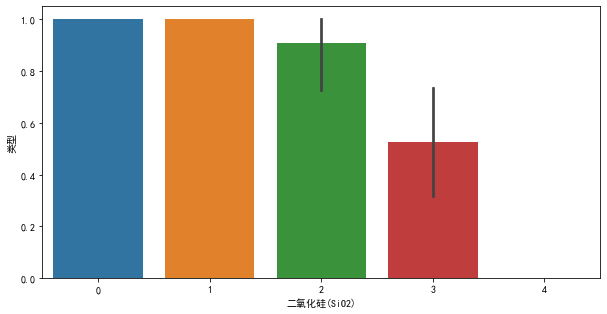

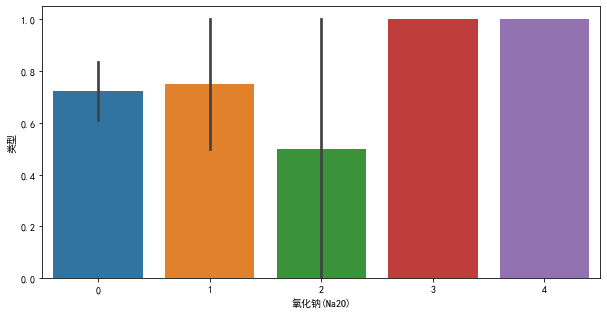

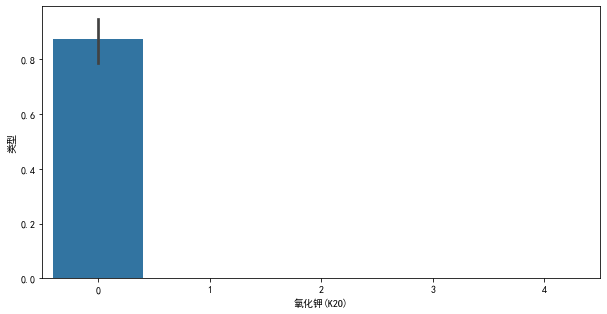

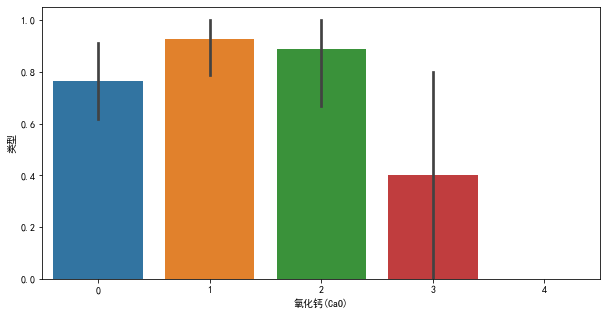

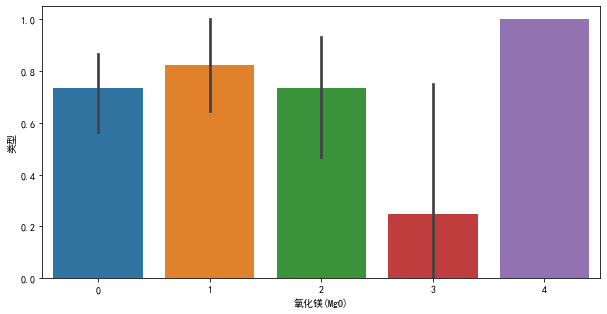

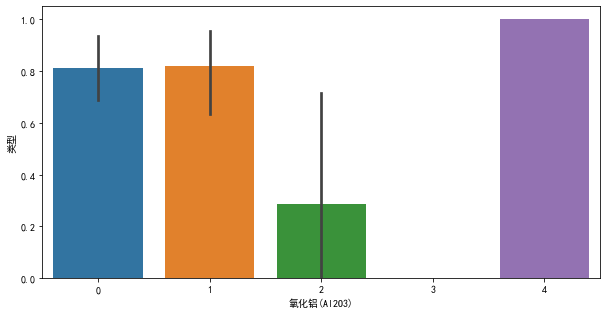

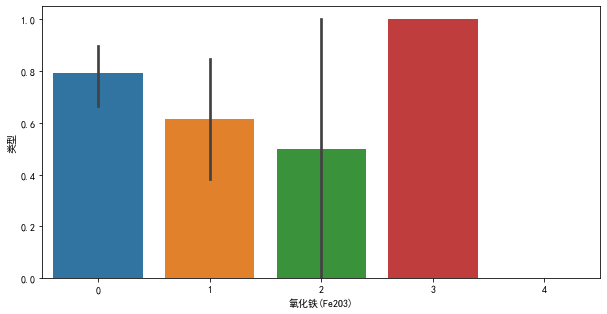

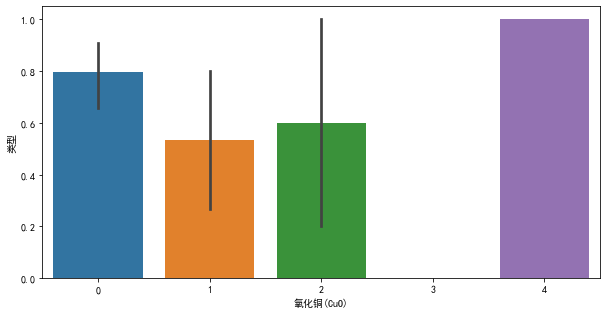

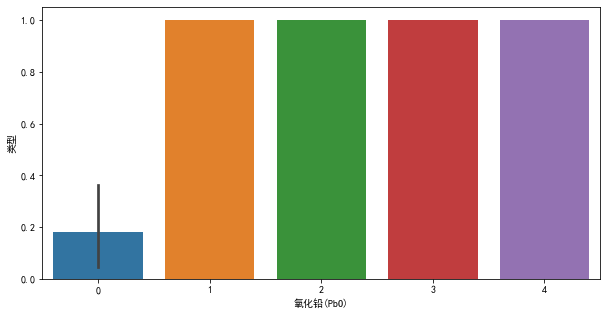

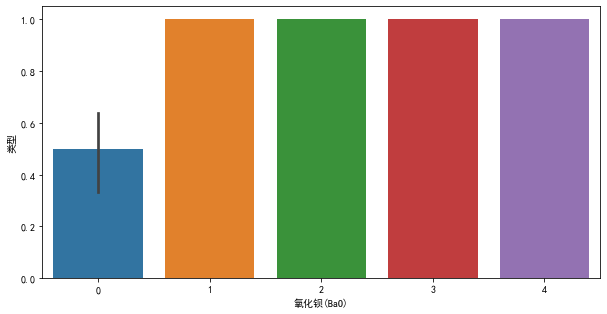

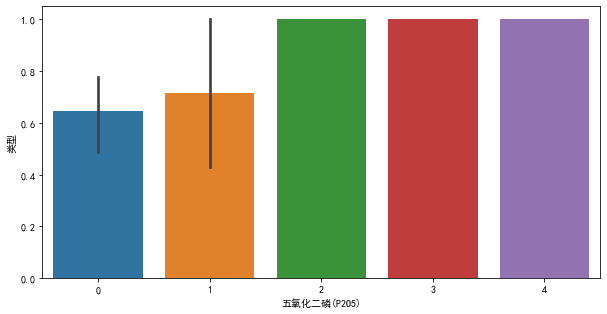

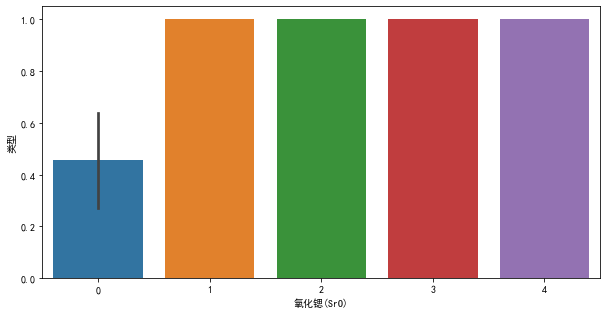

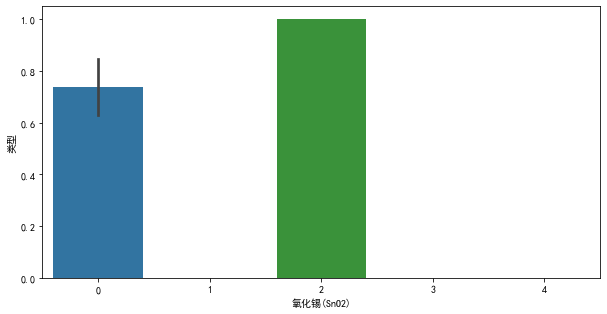

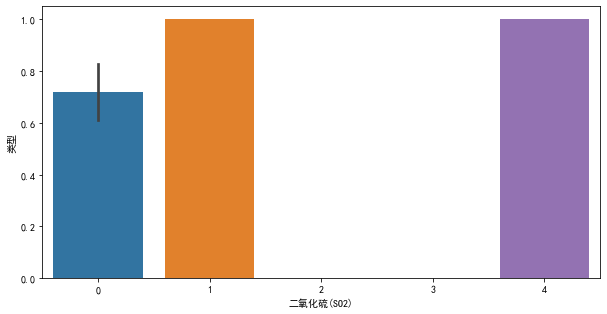

In [172]:
for col in chem_cols:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=col, y='类型', data=data_2)

In [174]:
#根据上修改
data_2['二氧化硅(SiO2)'] = data_2['二氧化硅(SiO2)'].replace([0], [1])

In [ ]:
data_2['二氧化硅(SiO2)'] = data_2['二氧化硅(SiO2)'].replace([0], [1])

In [184]:
chem_cols

['二氧化硅(SiO2)',
 '氧化钠(Na2O)',
 '氧化钾(K2O)',
 '氧化钙(CaO)',
 '氧化镁(MgO)',
 '氧化铝(Al2O3)',
 '氧化铁(Fe2O3)',
 '氧化铜(CuO)',
 '氧化铅(PbO)',
 '氧化钡(BaO)',
 '五氧化二磷(P2O5)',
 '氧化锶(SrO)',
 '氧化锡(SnO2)',
 '二氧化硫(SO2)']

In [181]:
data_2['氧化钠(Na2O)'] = data_2['氧化钠(Na2O)'].replace([4], 3)
data_2['氧化钾(K2O)'] = data_2['氧化钾(K2O)'].replace([3,4], [2, 2])
data_2['氧化镁(MgO)'] = data_2['氧化镁(MgO)'].replace([0], 1)
data_2['氧化铅(PbO)'] = data_2['氧化铅(PbO)'].replace([2, 3, 4], [1, 1, 1])
data_2['氧化钡(BaO)'] = data_2['氧化钡(BaO)'].replace([2, 3, 4], [1, 1, 1])
data_2['五氧化二磷(P2O5)'] = data_2['五氧化二磷(P2O5)'].replace([3,4], [2, 2])
data_2['氧化锶(SrO)'] = data_2['氧化锶(SrO)'].replace([2, 3, 4], [1, 1,1])
data_2['氧化锡(SnO2)'] = data_2['氧化锡(SnO2)'].replace([4], 3)
data_2['二氧化硫(SO2)'] = data_2['二氧化硫(SO2)'].replace([2], 3)

In [192]:
x_train = data_2[data_2['表面风化']==0][chem_cols]
y_train = data_2[data_2['表面风化']==0]['类型']

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
model1 = SelectKBest(chi2, k=6)#选择k个最佳特征
model1.fit_transform(x_train, y_train)

In [194]:
model1.scores_

array([2.07347140e+00, 1.28205128e-02, 2.27500000e+01, 2.41139601e+01,
       1.94663895e+00, 1.21263058e+01, 2.31570513e+00, 7.97888386e-01,
       1.10769231e+01, 8.30769231e+00, 6.41025641e-03, 7.38461538e+00,
       3.25000000e+00, 9.23076923e-01])

In [195]:
model1.pvalues_

array([1.49880033e-01, 9.09850033e-01, 1.84504140e-06, 9.07996575e-07,
       1.62949497e-01, 4.97155073e-04, 1.28073211e-01, 3.71725458e-01,
       8.74087211e-04, 3.94775186e-03, 9.36186293e-01, 6.57841361e-03,
       7.14234577e-02, 3.36668368e-01])

In [187]:
data_2_type0 = data_2[(data_2['类型']==0)&(data_2['表面风化']==0)].reset_index()
data_2_type1 = data_2[(data_2['类型']==1)&(data_2['表面风化']==0)].reset_index()

In [158]:
# 归一化函数
def Normalization(x):
    return (x-min(x))/(max(x)-min(x))

In [189]:
for col in xcols:
    data_2_type0[col] = Normalization(data_2_type0[col])
    data_2_type1[col] = Normalization(data_2_type1[col])

In [190]:
#高钾类：
#氧化钙(CaO)  氧化铝(Al2O3)
data_2_type0['氧化钙(CaO)'] = data_2_type0['氧化钙(CaO)']*4

In [191]:
data_2_type0['氧化铝(Al2O3)'] = data_2_type0['氧化铝(Al2O3)']*4

In [192]:
#铅钡类：
#氧化钠(Na2O)  五氧化二磷(P2O5)
data_2_type1['氧化钠(Na2O)'] = data_2_type1['氧化钠(Na2O)']*4

In [164]:
#data_2_type1['五氧化二磷(P2O5)'] = data_2_type1['五氧化二磷(P2O5)']/4

In [193]:
data_2_type1['氧化铜(CuO)'] = data_2_type1['氧化铜(CuO)']*4


In [352]:
# no_consider = [col for col in chem_cols if col not in ['氧化钙(CaO)', '氧化锡(SnO2)', '氧化铝(Al2O3)']]
# data_2_type0[no_consider] = data_2_type0[no_consider]

In [524]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [525]:
k_means = KMeans(n_clusters=2, random_state=10)
k_means.fit(x)

KMeans(n_clusters=2, random_state=10)

In [526]:
y_predict = k_means.predict(x)

In [527]:
y_predict

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

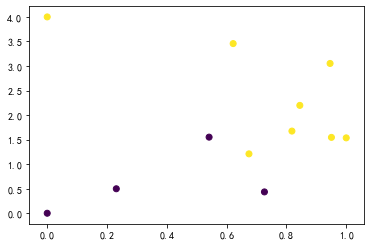

In [528]:
plt.scatter(x.loc[:,'氧化钙(CaO)'], x.loc[:,'氧化铝(Al2O3)'], c=y_predict)

In [529]:
x['y_pred'] = y_predict

In [530]:
y_predict

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

In [531]:
for col in xcols:
    data_2_type0.astype(float)

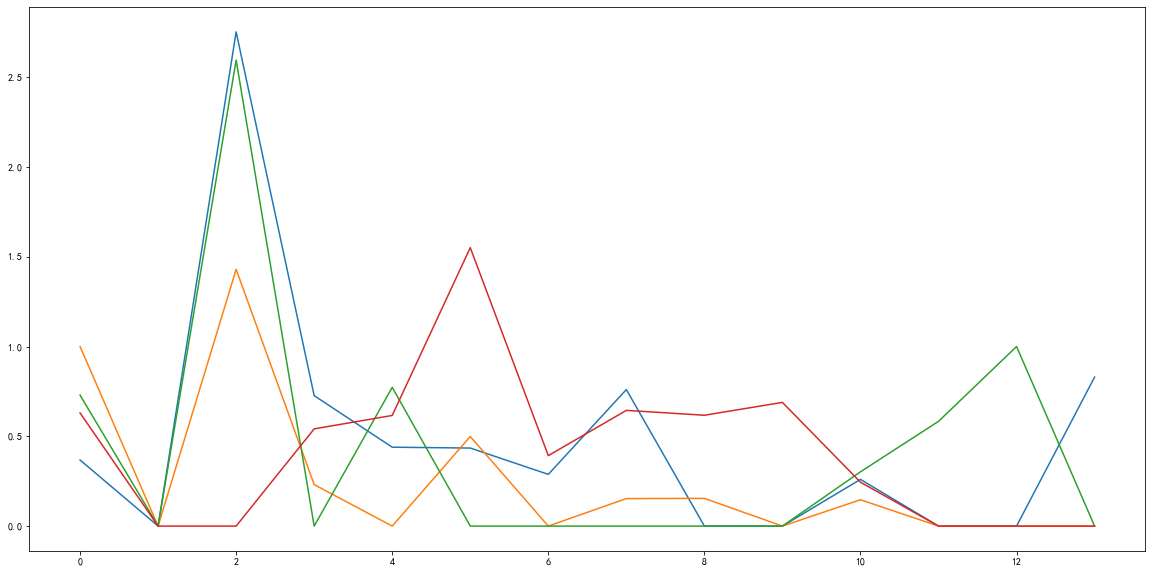

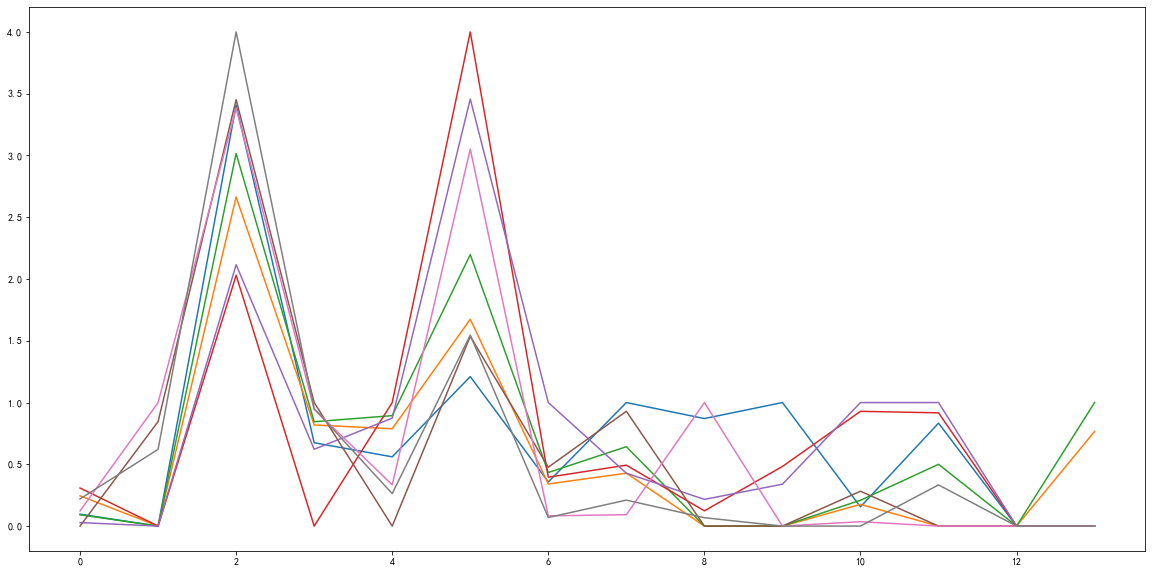

<Figure size 1440x720 with 0 Axes>

In [532]:
for i in range(3):
    plt.figure(figsize=(20, 10))
    t = x[x['y_pred']==i]
    for j in range(len(t)):
        plt.plot(range(len(xcols)), t[xcols].iloc[j])

In [331]:
#系统聚类

In [194]:
from sklearn.cluster import AgglomerativeClustering
from itertools import cycle

In [195]:
ac = AgglomerativeClustering(linkage='complete', n_clusters=3)
ac.fit(data_2_type0[xcols])

AgglomerativeClustering(linkage='complete', n_clusters=3)

In [196]:
labels = ac.labels_

In [197]:
data_2_type0['pre'] = labels

In [198]:
ac = AgglomerativeClustering(linkage='complete', n_clusters=3)
ac.fit(data_2_type1[xcols])


AgglomerativeClustering(linkage='complete', n_clusters=3)

In [199]:
labels = ac.labels_

In [200]:
data_2_type1['pre'] = labels

In [203]:
data_2_type0['亚类'] = data_2_type0['pre']
data_2_type1['亚类'] = data_2_type1['pre']

In [228]:
data_2_type = pd.concat([data_2_type0, data_2_type1], axis=0)

In [230]:
del data_2_type['index']

In [175]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

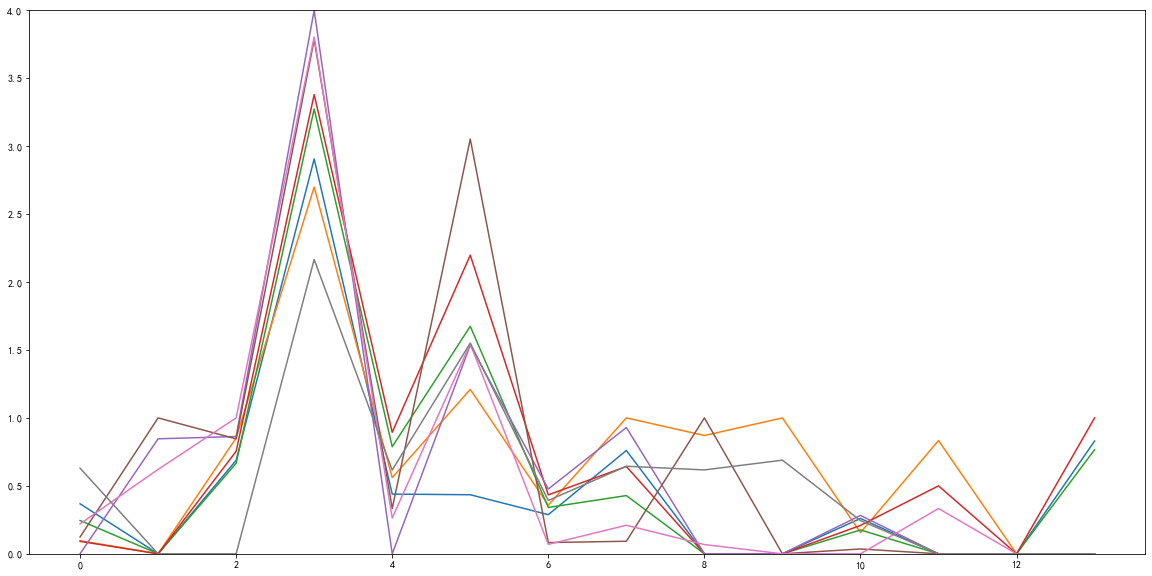

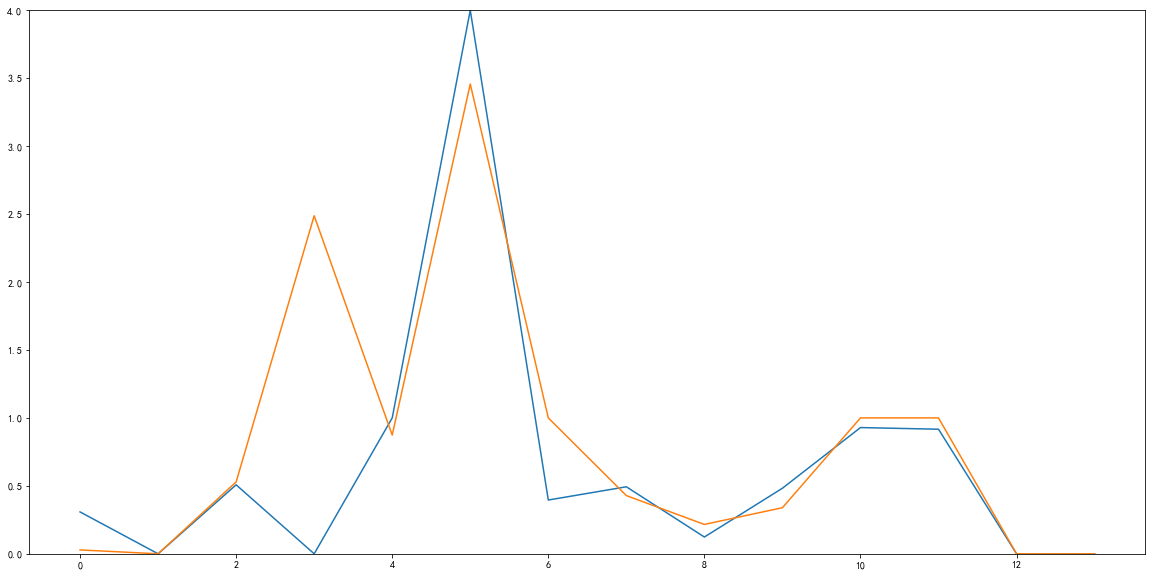

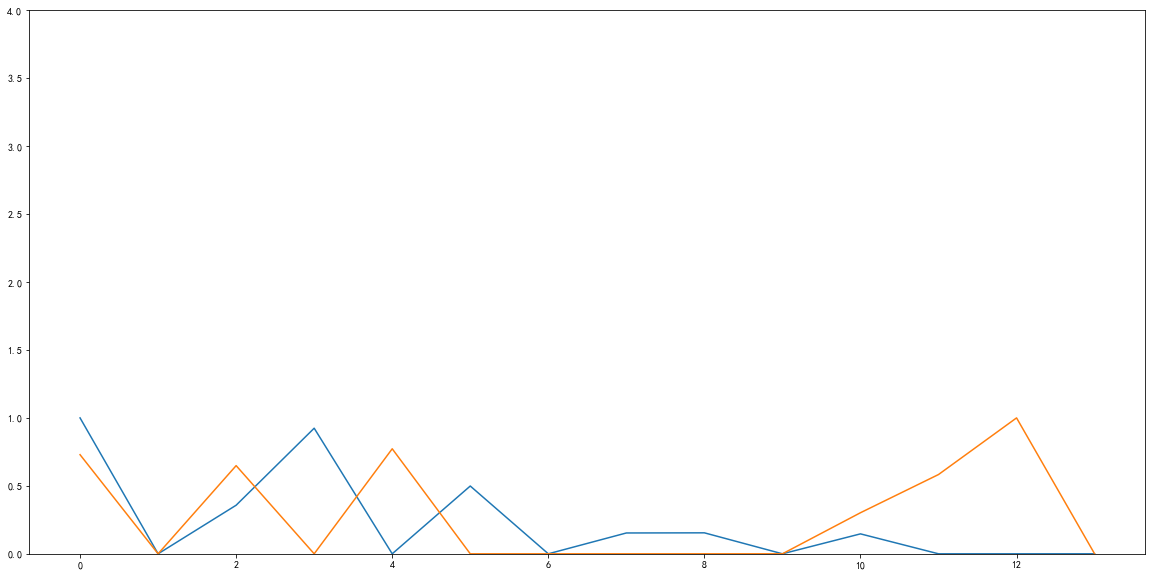

In [177]:
for i in range(3):
    plt.figure(figsize=(20, 10))
    plt.ylim(0, 4)
    t = data_2_type0[data_2_type0['pre']==i]
    for j in range(len(t)):
        plt.plot(range(len(xcols)), t[xcols].iloc[j])

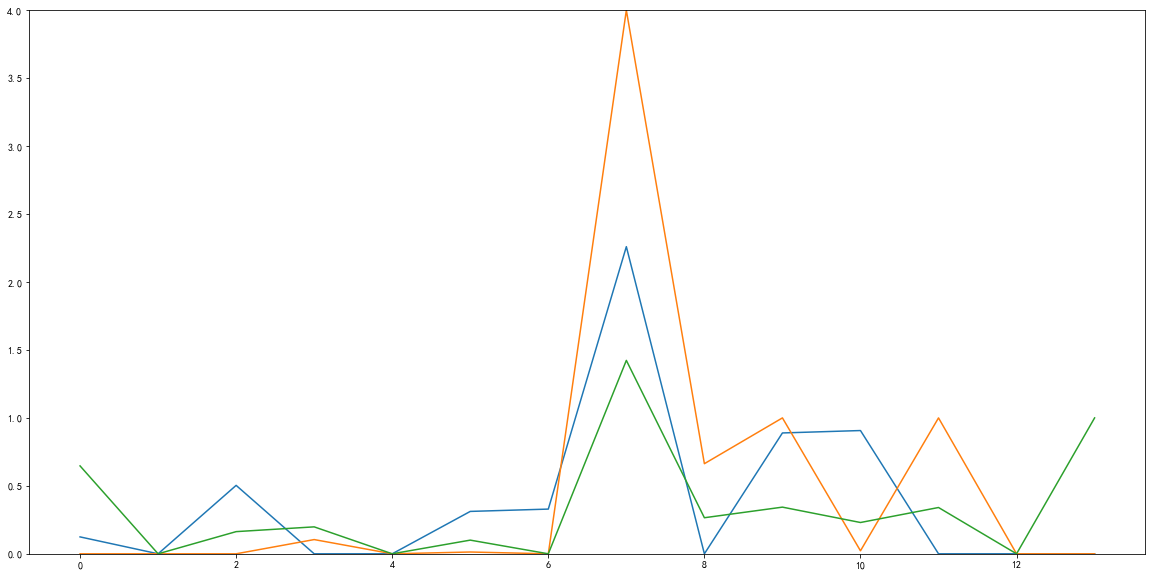

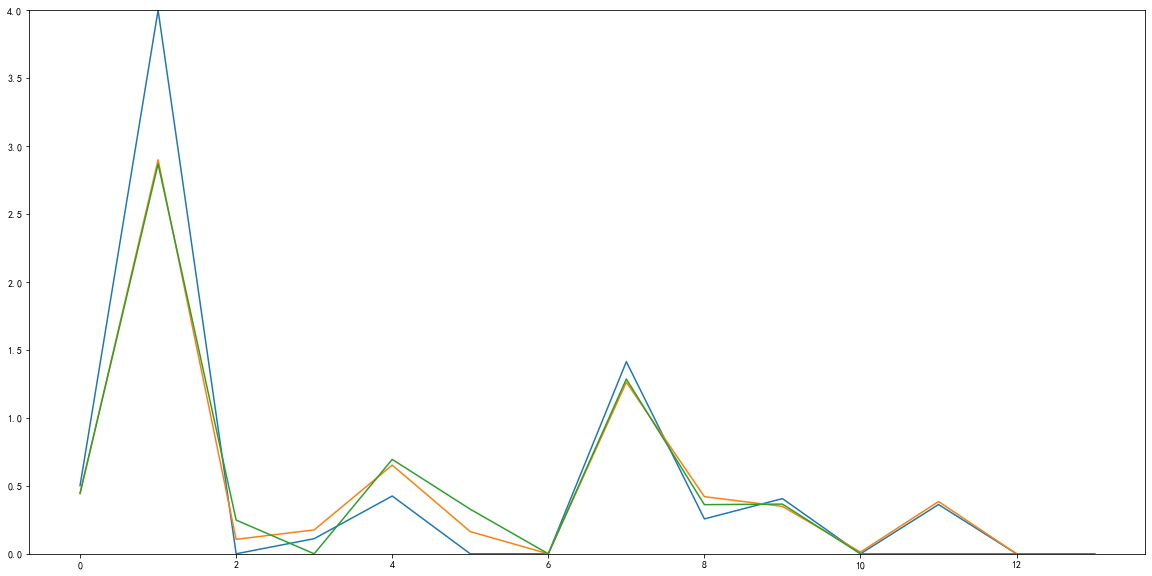

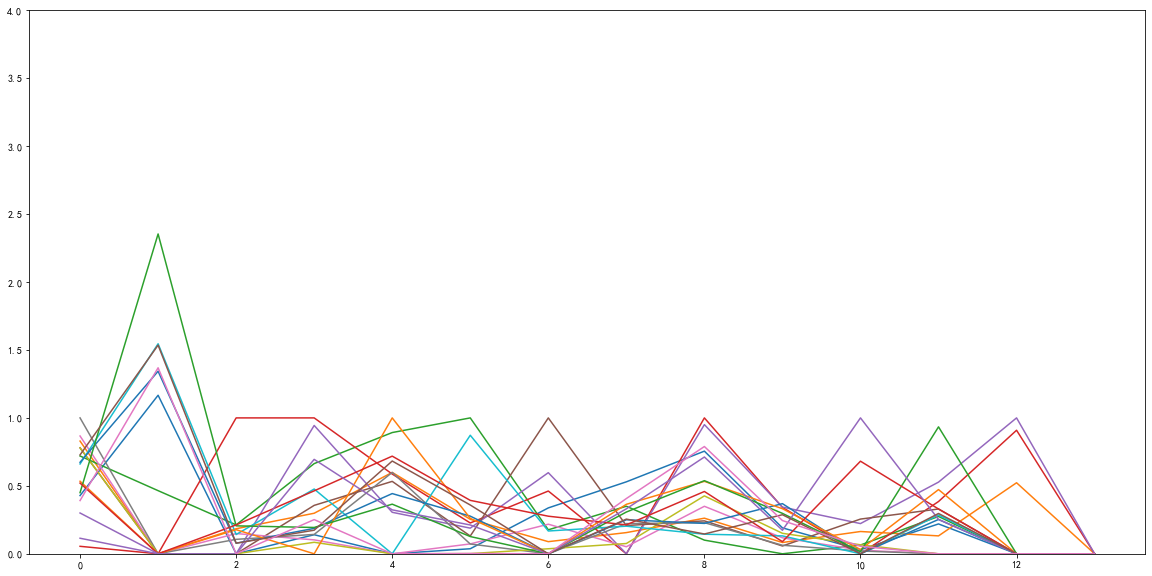

In [183]:
for i in range(3):
    plt.figure(figsize=(20, 10))
    plt.ylim(0, 4)
    t = data_2_type1[data_2_type1['pre']==i]
    for j in range(len(t)):
        plt.plot(range(len(xcols)), t[xcols].iloc[j])

In [ ]:
data_2_type = pd.concat([data_2_type0,data_2_type1], axis=0).reset_index()

In [684]:
import random
data_2_type0[xcols]+= random.gauss(0, 0.1)

In [685]:
data_2_type0

,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),文物编号,表面风化,类型,pre,pre_y
0,0.219242,-0.148804,0.539212,2.756943,0.290590,0.285764,0.139275,0.611510,-0.148804,-0.148804,0.111196,-0.148804,-0.148804,0.680983,1,0,0,0,0
1,0.851196,-0.148804,0.208634,0.775334,-0.148804,0.349961,-0.148804,0.004438,0.005517,-0.148804,-0.002137,-0.148804,-0.148804,-0.148804,3,0,0,2,2
2,-0.052513,-0.148804,0.703124,2.550046,0.411802,1.061072,0.208812,0.851196,0.721566,0.851196,0.006751,0.684529,-0.148804,-0.148804,3,0,0,0,0
3,0.096203,-0.148804,0.517174,3.124759,0.639075,1.525270,0.192255,0.279487,-0.148804,-0.148804,0.026751,-0.148804,-0.148804,0.617153,4,0,0,0,0
4,-0.057149,-0.148804,0.605328,3.230506,0.745135,2.048727,0.284971,0.493632,-0.148804,-0.148804,0.060085,0.351196,-0.148804,0.851196,5,0,0,0,0
5,0.159327,-0.148804,0.358772,-0.148804,0.851196,3.851196,0.246891,0.344320,-0.025347,0.333713,0.780085,0.767863,-0.148804,-0.148804,6,0,0,1,1
6,-0.120273,-0.148804,0.380121,2.338552,0.724933,3.307986,0.851196,0.279487,0.067245,0.190357,0.851196,0.851196,-0.148804,-0.148804,6,0,0,1,1
7,-0.148804,0.697350,0.714144,3.851196,-0.148804,1.386998,0.328017,0.780469,-0.148804,-0.148804,0.133418,-0.148804,-0.148804,-0.148804,13,0,0,0,0
8,-0.025409,0.851196,0.696926,3.635104,0.184529,2.903048,-0.066023,-0.056466,0.851196,-0.148804,-0.113249,-0.148804,-0.148804,-0.148804,14,0,0,0,0
9,0.071239,0.472498,0.851196,3.653495,0.113822,1.396875,-0.079268,0.061412,-0.080903,-0.148804,-0.148804,0.184529,-0.148804,-0.148804,16,0,0,0,0


In [686]:
from sklearn.cluster import AgglomerativeClustering
from itertools import cycle

In [687]:
ac = AgglomerativeClustering(linkage='complete', n_clusters=3)
ac.fit(data_2_type0[xcols])


AgglomerativeClustering(linkage='complete', n_clusters=3)

In [688]:
labels = ac.labels_

In [692]:
sklearn.metrics.mean_squared_error(data_2_type0['pre'], data_2_type0['pre_y'])

0.0

In [891]:
#首先预测大类型：高钾？铅钡？
X_cols = [col for col in data_2.columns if col not in ['文物编号', '表面风化', '类型', '文物采样点']]
X = data_2[X_cols]
y = data_2['类型']
from sklearn.model_selection import train_test_split
X_train, x_var, y_train, y_var = train_test_split(
X, y, test_size=0.2, random_state=10)
from lightgbm import LGBMClassifier
params = {'feature_fraction':0.6,'learning_rate': 0.1, 'n_estimators':100,'early_stop_round':100, 'max_depth': 4, 'l2_leaf_reg': 10, 'bootstrap_type':'Bernoulli','random_seed':2022,
                  'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
lgbm = LGBMClassifier(iterations=200, **params, eval_metric='AUC')
lgbm.fit(X_train, y_train, eval_set=(x_var, y_var),
                  verbose=1)
y_pre=lgbm.predict(x_var)

[LightGBM] [Warning] Unknown parameter: od_wait
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: bootstrap_type
[LightGBM] [Warning] Unknown parameter: early_stop_round
[LightGBM] [Warning] Unknown parameter: allow_writing_files
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: od_type
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[1]	valid_0's binary_logloss: 0.609916
[2]	valid_0's binary_logloss: 0.549908
[3]	valid_0's binary_logloss: 0.507372
[4]	valid_0's binary_logloss: 0.45301
[5]	valid_0's binary_logloss: 0.40111
[6]	valid_0's binary_logloss: 0.359924
[7]	valid_0's binary_logloss: 0.326547
[8]	valid_0's binary_logloss: 0.299128
[9]	valid_0's binary_logloss: 0.291738
[10]	valid_0's binary_logloss: 0.277009
[11]	valid_0's binary_logloss: 0.257752
[12]	valid_0's binary_lo

In [892]:
f1_score(y_pre, y_var)

0.9411764705882353

In [893]:
y_pre

array([0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1], dtype=int64)

In [894]:
cat =  CatBoostClassifier(iterations=100, depth=5,learning_rate=0.5, loss_function='Logloss',
                            logging_level='Verbose')

In [895]:
cat.fit(X_train, y_train, eval_set=(x_var, y_var),
                  verbose=1)

0:	learn: 0.5281581	test: 0.5357715	best: 0.5357715 (0)	total: 16ms	remaining: 1.59s
1:	learn: 0.3989646	test: 0.4143811	best: 0.4143811 (1)	total: 17ms	remaining: 833ms
2:	learn: 0.3373054	test: 0.3669489	best: 0.3669489 (2)	total: 18.2ms	remaining: 589ms
3:	learn: 0.2754132	test: 0.3147280	best: 0.3147280 (3)	total: 19.3ms	remaining: 464ms
4:	learn: 0.2321457	test: 0.2837652	best: 0.2837652 (4)	total: 20.1ms	remaining: 382ms
5:	learn: 0.1993369	test: 0.2641005	best: 0.2641005 (5)	total: 20.7ms	remaining: 324ms
6:	learn: 0.1736007	test: 0.2440235	best: 0.2440235 (6)	total: 21.2ms	remaining: 282ms
7:	learn: 0.1549078	test: 0.2160060	best: 0.2160060 (7)	total: 21.8ms	remaining: 250ms
8:	learn: 0.1424416	test: 0.2022910	best: 0.2022910 (8)	total: 22.3ms	remaining: 226ms
9:	learn: 0.1230380	test: 0.1824566	best: 0.1824566 (9)	total: 22.9ms	remaining: 206ms
10:	learn: 0.1119388	test: 0.1702567	best: 0.1702567 (10)	total: 23.5ms	remaining: 190ms
11:	learn: 0.1056008	test: 0.1619925	best: 0.

In [896]:
y_pre = cat.predict(x_var)

In [897]:
f1_score(y_var, y_pre)

1.0

In [898]:
y_pre

array([0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=int64)

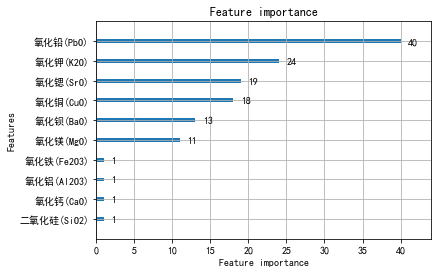

In [136]:
from lightgbm import plot_importance
plot_importance(lgbm)

In [899]:
from sklearn.svm import SVC 
svc = SVC(kernel='rbf', probability=True) 
svc.fit(X_train, y_train) 

SVC(probability=True)

In [900]:
y_pre = svc.predict(x_var)

In [901]:
f1_score(y_var, y_pre)

1.0

In [147]:
x_test = data_3[chem_cols]

In [150]:
data_3['类型'] = cat.predict(x_test)

In [152]:
data_3 = data_3.fillna(0)

In [255]:
data_3_needs = data_3[data_3['表面风化']=='风化' ]

In [265]:
data_3_needs_0 = data_3_needs[data_3_needs['类型']==0]
data_3_needs_1 = data_3_needs[data_3_needs['类型']==1]


In [266]:
#根据rate以及置信区间求之前
for i in range(len(chem_cols)):
    data_3_needs_0[chem_cols[i]] = (ls0[i][0]+ls0[i][1])/2
    data_3_needs_1[chem_cols[i]] = data_3_needs_1[chem_cols[i]]/(1-rate_dict[chem_cols[i]])


In [270]:
data_3_needs_1

,文物编号,表面风化,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),类型
1,A2,风化,111.029412,0.0,0.00,4.080214,0.00,2.452632,0.000000,0.00,27.440,0.000000,7.610667,0.00,0.000000,0.0,1
4,A5,风化,189.088235,1.2,0.37,0.877005,2.34,13.421053,0.376744,0.94,9.784,1.515789,0.101333,0.12,0.276056,0.0,1


In [280]:
 #修正铅钡型：
for i in range(len(data_3_needs_1)):
    for j in range(len(chem_cols)):
        if data_3_needs_1.iloc[i, j+2] < ls1[j][0]:
            data_3_needs_1.iloc[i, j+2] = ls1[j][0]
        elif data_3_needs_1.iloc[i, j+2] >ls1[j][1]:
            data_3_needs_1.iloc[i, j+2] = ls1[j][1]

In [281]:
data_3_needs = pd.concat([data_3_needs_0, data_3_needs_1])

In [289]:
data_3

,文物编号,表面风化,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),类型
0,A1,无风化,78.45,0.0,0.00,6.08,1.86,7.23,2.15,2.11,0.00,0.00,1.06,0.03,0.00,0.51,0
1,A2,风化,37.75,0.0,0.00,7.63,0.00,2.33,0.00,0.00,34.30,0.00,14.27,0.00,0.00,0.00,1
2,A3,无风化,31.95,0.0,1.36,7.19,0.81,2.93,7.06,0.21,39.58,4.69,2.68,0.52,0.00,0.00,1
3,A4,无风化,35.47,0.0,0.79,2.89,1.05,7.07,6.45,0.96,24.28,8.31,8.45,0.28,0.00,0.00,1
4,A5,风化,64.29,1.2,0.37,1.64,2.34,12.75,0.81,0.94,12.23,2.16,0.19,0.21,0.49,0.00,1
5,A6,风化,93.17,0.0,1.35,0.64,0.21,1.52,0.27,1.73,0.00,0.00,0.21,0.00,0.00,0.00,0
6,A7,风化,90.83,0.0,0.98,1.12,0.00,5.06,0.24,1.17,0.00,0.00,0.13,0.00,0.00,0.11,0
7,A8,无风化,51.12,0.0,0.23,0.89,0.00,2.12,0.00,9.01,21.24,11.34,1.46,0.31,0.00,2.26,1


In [291]:
data_3 = pd.concat([data_3_needs, data_3[data_3['表面风化']=='无风化']]).sort_values(by = '文物编号')

In [425]:
data_3

,文物编号,表面风化,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),类型
0,A1,无风化,78.450000,0.000000,0.000000,6.080000,1.860000,7.230000,2.150000,2.110000,0.000000,0.000000,1.060000,0.030000,0.000000,0.510000,0
1,A2,风化,44.231400,1.425177,0.252603,1.580486,0.826481,2.803266,0.928344,1.170000,29.055815,12.883454,4.415516,0.423646,0.119344,0.000000,1
2,A3,无风化,31.950000,0.000000,1.360000,7.190000,0.810000,2.930000,7.060000,0.210000,39.580000,4.690000,2.680000,0.520000,0.000000,0.000000,1
3,A4,无风化,35.470000,0.000000,0.790000,2.890000,1.050000,7.070000,6.450000,0.960000,24.280000,8.310000,8.450000,0.280000,0.000000,0.000000,1
4,A5,风化,44.231400,1.425177,0.252603,1.580486,0.826481,2.803266,0.928344,1.170000,29.055815,12.883454,4.415516,0.423646,0.119344,0.000000,1
5,A6,风化,76.643889,0.463333,6.401667,3.845000,0.785000,5.056667,1.376111,2.155556,0.274444,0.398889,1.028333,0.027778,0.131111,0.067778,0
6,A7,风化,76.643889,0.463333,6.401667,3.845000,0.785000,5.056667,1.376111,2.155556,0.274444,0.398889,1.028333,0.027778,0.131111,0.067778,0
7,A8,无风化,51.120000,0.000000,0.230000,0.890000,0.000000,2.120000,0.000000,9.010000,21.240000,11.340000,1.460000,0.310000,0.000000,2.260000,1


In [334]:
data_2_type = data_2[data_2['亚类'].isnull()==False]

In [512]:
data_2_type = pd.merge(data_2[data_2['亚类'].isnull()==False], data_2_type[['类型', '文物采样点']],how = 'left', on ='文物采样点' )

In [513]:
data_2_type = data_2_type.fillna(0)

In [393]:
from sklearn.ensemble import RandomForestClassifier

In [399]:
rfc1 = RandomForestClassifier()
rfc2 = RandomForestClassifier()

In [397]:
data_2_type0 = data_2_type[data_2_type['类型']==0]

In [398]:
data_2_type1 = data_2_type[data_2_type['类型']==1]

In [401]:
X_0 = data_2_type0[chem_cols]
y_0 = data_2_type0['亚类']

In [434]:
X_1 = data_2_type1[chem_cols]
y_1 = data_2_type1['亚类']

In [435]:
from sklearn.model_selection import train_test_split
X_train_0, x_var_0, y_train_0, y_var_0 = train_test_split(
X_0, y_0, test_size=0.2, random_state=10)

In [436]:
from sklearn.model_selection import train_test_split
X_train_1, x_var_1, y_train_1, y_var_1 = train_test_split(
X_1, y_1, test_size=0.2, random_state=10)

In [437]:
rfc1.fit(X_train_0, y_train_0)

RandomForestClassifier()

In [438]:
y_pre_0=rfc1.predict(x_var_0)

In [439]:
y_var_0

2    0.0
6    1.0
7    0.0
Name: 亚类, dtype: float64

In [445]:
accuracy_score(y_pre_0, y_var_0)

0.6666666666666666

In [440]:
rfc2.fit(X_train_1, y_train_1)

RandomForestClassifier()

In [441]:
y_pre_1 = rfc2.predict(x_var_1)

In [443]:
y_pre_1

array([2., 1., 2., 2., 2.])

In [444]:
accuracy_score(y_pre_1, y_var_1)

0.8

In [416]:
y_var_1

2    0.0
6    1.0
7    0.0
Name: 亚类, dtype: float64

In [446]:
data_3_needs_0 = data_3[data_3['类型']==0]
test0=rfc1.predict(data_3_needs_0[chem_cols])

In [447]:
data_3_needs_1 = data_3[data_3['类型']==1]

In [448]:
test1 = rfc2.predict(data_3_needs_1[chem_cols])

In [450]:
data_3_needs_0['亚类'] = test0
data_3_needs_1['亚类'] = test1


In [453]:
data_3_needs = pd.concat([data_3_needs_0, data_3_needs_1]).sort_values(by = '文物编号')

In [484]:
x = torch.tensor(data_2_type[chem_cols].values).reshape(35, 14)

In [485]:
x = x=x.float()

In [486]:
x = x.unsqueeze(1)

torch.Size([35, 1, 14])

In [864]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3,stride=1,padding = 1) #2*2*32
        self.mp1 = nn.MaxPool2d(kernel_size=2,stride=2)#1132
        self.conv2 = nn.Conv2d(16,64, kernel_size=3,stride =1)#  2 2 64
        self.mp2 = nn.MaxPool2d(kernel_size=2,stride=2) #1 1 64
        self.fc1= nn.Linear(32,32)#32 32 32
        self.dp1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(14*4*4,10)

    def forward(self, x):
        out = self.conv1(x)    
        #out shape(batch,16,5,5)
        out = out.view(-1, 14*4*4)     #out shape()
        out = self.fc2(out)                  #out shape(batch,10)
        return out

In [865]:
net = CNN()

In [866]:
data_2_type0 = data_2_type[data_2_type['类型']==0]
X_0 = data_2_type0[chem_cols]
y_0 = data_2_type0['亚类']

In [867]:
from sklearn.model_selection import train_test_split
X_train_0, x_var_0, y_train_0, y_var_0 = train_test_split(
X_0, y_0, test_size=0.2, random_state=10)

In [868]:
X_train_0 = torch.tensor(X_train_0.values)

In [869]:
X_train_0 = X_train_0.float()

In [870]:
X_train_0 = X_train_0.unsqueeze(1)

In [871]:
X_train_0.shape

torch.Size([9, 1, 14])

In [875]:
X_train_0

tensor([[[6.7650e+01, 0.0000e+00, 7.3700e+00, 0.0000e+00, 1.9800e+00,
          1.1150e+01, 2.3900e+00, 2.5100e+00, 2.0000e-01, 1.3800e+00,
          4.1800e+00, 1.1000e-01, 0.0000e+00, 0.0000e+00]],

        [[7.6680e+01, 0.0000e+00, 0.0000e+00, 4.7100e+00, 1.2200e+00,
          6.1900e+00, 2.3700e+00, 3.2800e+00, 1.0000e+00, 1.9700e+00,
          1.1000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[6.2470e+01, 3.3800e+00, 1.2280e+01, 8.2300e+00, 6.6000e-01,
          9.2300e+00, 5.0000e-01, 4.7000e-01, 1.6200e+00, 0.0000e+00,
          1.6000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[7.9460e+01, 0.0000e+00, 9.4200e+00, 0.0000e+00, 1.5300e+00,
          3.0500e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.3600e+00, 7.0000e-02, 2.3600e+00, 0.0000e+00]],

        [[6.5880e+01, 0.0000e+00, 9.6700e+00, 7.1200e+00, 1.5600e+00,
          6.4400e+00, 2.0600e+00, 2.1800e+00, 0.0000e+00, 0.0000e+00,
          7.9000e-01, 0.0000e+00, 0.0000e+00, 3.6000e-01

In [872]:
import torch.optim as optim
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#常用优化方法有
#1.Stochastic Gradient Descent (SGD)
#2.Momentum
#3.AdaGrad
#4.RMSProp
#5.Adam (momentum+adaGrad)   效果较好

In [873]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), std =(0.5, 0.5, 0.5))])

In [ ]:
inputs, labels = X_train_0,torch.tensor(y_train_0.values)
# zeros the paramster gradients
optimizer.zero_grad()        

# forward + backward + optimize
outputs = net(inputs)
loss = criterion(outputs, labels)  # 计算loss
loss.backward()     # loss 求导
optimizer.step()    # 更新参数

# print statistics
running_loss += loss.item()  # tensor.item()  获取tensor的数值

print('Finished Training')

In [786]:
data_2_type0['亚类']

0     0.0
1     2.0
2     0.0
3     0.0
4     0.0
5     1.0
6     1.0
7     0.0
8     0.0
9     0.0
10    2.0
12    0.0
Name: 亚类, dtype: float64

In [908]:
accuracy_score(y_pred_0, y_var_0)

89.89372